In [1]:
%%capture
cd ..

In [2]:
# Toggle for hiding and showing notebook code

from IPython.display import HTML, Javascript, display
from ipywidgets import widgets

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle();"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [3]:
%load_ext autoreload
%autoreload 2

import dill
import matplotlib.pyplot as plt

from dreamcoder.domains.list.handwrittenProperties import handWrittenProperties, getHandwrittenPropertiesFromTemplates
from dreamcoder.domains.list.makeListTasks import joshTasks
from dreamcoder.domains.list.propSim import getPropertySimTasksMatrix, getPriorDistributionsOfProperties, createSimilarTasksDf, getPropSimGrammars
from dreamcoder.domains.list.runUtils import *
from dreamcoder.domains.list.utilsProperties import enumerationProxy
from dreamcoder.grammar import Grammar


# Load relevant tasks, properties and helmholtz frontiers
tasks = joshTasks("3")
properties = getHandwrittenPropertiesFromTemplates(tasks, filterEquivalent=True)
fileName = "data/prop_sig/helmholtz_frontiers/josh_rich_0_10_enumerated/13742_with_josh_fleet_0_10-inputs.pkl"
helmholtzFrontiers = dill.load(open(fileName, "rb"))
valuesToInt = {"allFalse":0, "allTrue":1, "mixed":2}

# Compute prior probabilities (over tasks) for property values
taskPropertyMatrix = getPropertySimTasksMatrix(tasks, properties, valuesToInt)
helmholtzTasksPropertyMatrix = getPropertySimTasksMatrix([f.task for f in helmholtzFrontiers], properties, valuesToInt)
propertyToPriorDistribution = getPriorDistributionsOfProperties(properties, taskPropertyMatrix, valuesToInt)

114 out of 214 properties after filtering


## Standard vs Long input property signatures

In [64]:
standard_input_tasks = joshTasks("fleet_0_10")
standard_input_tasks = [t for t in standard_input_tasks if t.name not in ["c073", "c076", "c077"]]
long_input_tasks = joshTasks("3_long_inputs_0_10")
properties_long_input = getHandwrittenPropertiesFromTemplates(long_input_tasks, filterEquivalent=True)
properties_standard_input = getHandwrittenPropertiesFromTemplates(standard_input_tasks, filterEquivalent=True)

6489 out of 10441 properties after filtering
168 out of 181 properties after filtering


### Properties with different values

In [17]:
valuesToInt = {"allTrue":1, "allFalse":0, "mixed":0}
stand_matrix = getPropertySimTasksMatrix(standard_input_tasks, properties_standard_input, valuesToInt)
long_matrix = getPropertySimTasksMatrix(long_input_tasks, properties_standard_input, valuesToInt)

In [19]:
def show_different_value_properties(task_index):
    
    def print_signatures(signature_a, signature_b, properties, values_to_int):
        int_to_value = {i:v for v,i in values_to_int.items()}
        assert len(signature_a) == len(signature_b)
        assert len(signature_a) == len(properties)
        for i,p in enumerate(properties):
            if signature_a[i] != signature_b[i]:
                print("{}: {} vs {}".format(p.name, int_to_value[signature_a[i]], int_to_value[signature_b[i]]))
            
    print("\nProgram: {}\n{}".format(standard_input_tasks[task_index].program, standard_input_tasks[task_index].describe()))
    print("\nProgram: {}\n{}".format(long_input_tasks[task_index].program, long_input_tasks[task_index].describe()))
    print_signatures(stand_matrix[task_index, :], long_matrix[task_index, :], properties_standard_input, valuesToInt)
    
show_different_value_properties(50)


Program: (lambda (++ (repeat (first $0) 5) $0))
c051 : list(int) -> list(int)
f([9, 9, 9, 9]) = [9, 9, 9, 9, 9, 9, 9, 9, 9]
f([4, 1]) = [4, 4, 4, 4, 4, 4, 1]
f([5, 7, 0, 7, 3, 5, 8]) = [5, 5, 5, 5, 5, 5, 7, 0, 7, 3, 5, 8]
f([8]) = [8, 8, 8, 8, 8, 8]
f([2, 4, 5, 1, 3, 6, 8, 0]) = [2, 2, 2, 2, 2, 2, 4, 5, 1, 3, 6, 8, 0]
f([5, 4, 4, 4, 2, 2, 5]) = [5, 5, 5, 5, 5, 5, 4, 4, 4, 2, 2, 5]
f([2, 6, 4, 0, 8, 7, 0, 0, 9]) = [2, 2, 2, 2, 2, 2, 6, 4, 0, 8, 7, 0, 0, 9]
f([6, 7, 6, 6, 7, 7]) = [6, 6, 6, 6, 6, 6, 7, 6, 6, 7, 7]
f([1, 9, 3, 8, 8, 1, 3, 3, 3]) = [1, 1, 1, 1, 1, 1, 9, 3, 8, 8, 1, 3, 3, 3]
f([3, 3, 2, 6, 4]) = [3, 3, 3, 3, 3, 3, 3, 2, 6, 4]
f([0, 1, 1]) = [0, 0, 0, 0, 0, 0, 1, 1]

Program: (lambda (++ (repeat (first $0) 5) $0))
051_1 : list(int) -> list(int)
f([2, 6, 0, 8, 9, 1, 1, 1, 2, 7, 8, 3, 1, 9, 4, 5, 4, 2, 1, 7, 6, 3, 9, 8, 2, 3, 2, 5, 2, 7, 6, 0, 0, 5, 9, 6, 5, 5, 8, 4, 8, 5, 1, 2, 9, 1, 0, 2, 3, 7, 7, 5, 4, 1, 0]) = [2, 2, 2, 2, 2, 2, 6, 0, 8, 9, 1, 1, 1, 2, 7, 8, 3, 1, 9, 4, 5

### Resulting differences in conditional grammars

In [21]:
# Run Propsim
args = {'resume': None, 'iterations': 1, 'enumerationTimeout': 10, 'unconditionalEnumerationTimeout': None, 'topK': 2, 'pseudoCounts': 30.0, 'aic': 1.0, 'structurePenalty': 1.0, 'arity': 3, 'CPUs': 96, 'cuda': True, 'maximumFrontier': 10, 'reuseRecognition': False, 'useRecognitionModel': True, 'ensembleSize': 1, 'useDSL': True, 'noConsolidation': False, 'testingTimeout': 0, 'testEvery': 1, 'seed': 0, 'activation': 'tanh', 'solver': 'ocaml', 'compressor': 'ocaml', 'matrixRank': None, 'mask': False, 'biasOptimal': False, 'contextual': False, 'taskBatchSize': None, 'taskSplit': None, 'taskReranker': 'default', 'storeTaskMetrics': True, 'rewriteTaskMetrics': False, 'auxiliaryLoss': False, 'parallelTest': False, 'addFullTaskMetrics': False, 'trainset': 'S12', 'doshaping': False, 'dopruning': False, 'skiptesting': False, 'epochs': 99999, 'libraryName': 'josh_rich_0_10', 'propSamplingPrimitives': 'same', 'dataset': 'josh_3_long_inputs_0_10', 'extractor': 'prop_sig', 'hidden': 64, 'propSim': False, 'helmEnumerationTimeout': 1, 'propNumIters': 1, 'hmfSeed': None, 'numHelmFrontiers': None, 'maxFractionSame': 1.0, 'helmholtzFrontiers': 'josh_rich_0_10_enumerated/13742_with_josh_fleet_0_10-inputs.pkl', 'propFilename': None, 'filterSimilarProperties': False, 'computePriorFromTasks': False, 'nSim': 50, 'propPseudocounts': 1, 'onlyUseTrueProperties': True, 'save': False, 'verbose': False, 'weightByPrior': False, 'weightedSim': False, 'taskSpecificInputs': False, 'singleTask': False, 'debug': False, 'propCPUs': 96, 'propSolver': 'ocaml', 'propEnumerationTimeout': 1, 'propUseConjunction': False, 'propAddZeroToNinePrims': False, 'propScoringMethod': 'unique_task_signature', 'propDreamTasks': False, 'propToUse': 'handwritten', 'propSamplingGrammarWeights': 'uniform', 'propUseEmbeddings': False, 'featureExtractor': None}
args["onlyUseTrueProperties"] = True
args["computePriorFromTasks"] = False
args["taskSpecificInputs"] = True
args["verbose"] = True

prims = get_primitives(args["libraryName"])
baseGrammar = Grammar.uniform([p for p in prims])
for t in standard_input_tasks + long_input_tasks:
    # parses program string and also executes to check that I/O matches parsed program
    t.parse_program(prims)

task2FittedGrammars = []

for tasks in [standard_input_tasks]:
    task2FittedGrammar, _, _ = getPropSimGrammars(
       baseGrammar,
       tasks,
       tasks,  
       helmholtzFrontiers, 
       properties_standard_input, 
       args["onlyUseTrueProperties"], 
       args["nSim"], 
       args["propPseudocounts"], 
       args["weightedSim"], 
       compressSimilar=False, 
       weightByPrior=False, 
       recomputeTasksWithTaskSpecificInputs=args["taskSpecificInputs"],
       computePriorFromTasks=args["computePriorFromTasks"], 
       filterSimilarProperties=args["filterSimilarProperties"], 
       maxFractionSame=args["maxFractionSame"], 
       valuesToInt=valuesToInt,
       propSimIteration=0,
       verbose=args["verbose"])
    task2FittedGrammars.append(task2FittedGrammar)


------------------------------------------------ Task c001 ----------------------------------------------------
c001 : list(int) -> list(int)
f([2, 4, 3, 2]) = [3]
f([9, 6, 9, 8, 6]) = [9]
f([0, 0, 0, 0, 0]) = [0]
f([8, 1, 8]) = [8]
f([5, 7, 5, 7, 5]) = [5]
f([1, 1, 1, 1]) = [1]
f([7, 9, 3, 4]) = [3]
f([7, 7, 7]) = [7]
f([5, 3, 6]) = [6]
f([2, 2, 2, 8]) = [2]
f([0, 6, 4, 4, 0, 6, 4]) = [4]
Dropping 1608 out of 13742 due to error when executing on specified inputs
Creating Similar Task Matrix
Finished Creating Similar Task Matrix with size: (12134, 6)
propertyToPriorDistribution (2, 6)
new shape of propertyToPriorDistribution: (2, 6)
new shape of propertySimTasksMatrix: (12134, 6)
6 Highest scoring properties:
0.014007910349373764 -> output_idx_0_equals_input_idx_2 (allTrue)
0.11346407382992749 -> output_list_length_1 (allTrue)
0.35934410019775875 -> output_contains_input_idx_2 (allTrue)
0.37129202373104814 -> output_shorter_than_input (allTrue)
0.5200230718523401 -> output_els_in_inpu


Program (-14.129518055583603): (lambda (slice 5 5 $0))

Task similarity score: 7.357527874305062
Helmholtz : list(int) -> list(int)
f([0, 5]) = []
f([5, 6, 1, 3, 2, 0, 7, 8, 9, 4]) = [1]
f([6, 7, 8, 1, 4, 3, 0, 5, 9, 2]) = [8]
f([7, 4, 3, 9, 5, 8, 2, 1, 6]) = [3]
f([4, 6]) = []
f([3, 9]) = []
f([4, 7, 1, 2, 6, 3, 8, 9, 0, 5]) = [1]
f([5, 7]) = []
f([9, 6, 2, 5, 8, 7, 3, 4, 1, 0]) = [2]
f([8]) = []
f([7, 9, 0, 2, 1, 8, 6, 3, 5, 4]) = [0]

Program (-14.129518055583603): (lambda (slice 3 3 $0))

Task similarity score: 7.357527874305062
Helmholtz : list(int) -> list(int)
f([0, 5]) = []
f([5, 6, 1, 3, 2, 0, 7, 8, 9, 4]) = [4]
f([6, 7, 8, 1, 4, 3, 0, 5, 9, 2]) = [2]
f([7, 4, 3, 9, 5, 8, 2, 1, 6]) = []
f([4, 6]) = []
f([3, 9]) = []
f([4, 7, 1, 2, 6, 3, 8, 9, 0, 5]) = [5]
f([5, 7]) = []
f([9, 6, 2, 5, 8, 7, 3, 4, 1, 0]) = [0]
f([8]) = []
f([7, 9, 0, 2, 1, 8, 6, 3, 5, 4]) = [4]

Program (-14.129518055583603): (lambda (cut_slice 1 9 $0))

Task similarity score: 7.357527874305062
Helmholtz : lis


Program (-17.79307970171325): (lambda (unique (singleton (nth 7 $0))))
Helmholtz : list(int) -> list(int)
f([7, 2, 3, 9, 0, 4, 5, 6]) = [5]
f([6, 1, 6, 4, 4, 7, 0, 4, 6, 1]) = [0]
f([0, 5, 7, 4, 9, 1, 3, 6, 7, 8]) = [3]
f([6, 8, 5, 0, 2, 9, 8, 2]) = [8]
f([1, 0, 8, 6, 7, 2, 9, 3, 5, 4]) = [9]
f([1, 3, 1, 1, 5, 5, 1, 9, 1, 3]) = [1]
f([6, 9, 0, 8, 2, 8, 2, 3, 2]) = [2]
f([5, 2, 0, 3, 1, 8, 9, 4, 9, 5]) = [9]
f([0, 6, 4, 3, 2, 7, 6, 1]) = [6]
f([0, 8, 7, 8, 0, 8, 7, 0, 0, 8]) = [7]
f([9, 3, 0, 4, 3, 6, 4, 8, 7]) = [4]

Grammar after fitting for task c003:
-1.009817	t0	$_
0.000000	bool	true
0.000000	bool	false
0.000000	int -> int -> bool	gt?
0.000000	int -> int -> bool	lt?
0.000000	int -> bool	is-even
0.000000	int -> bool	is-odd
0.000000	bool -> bool -> bool	and
0.000000	bool -> bool -> bool	or
0.000000	bool -> bool	not
0.000000	t0 -> t0 -> bool	eq?
0.000000	(t0 -> t1) -> list(t0) -> list(list(t0))	group
0.000000	list(t0) -> t0 -> bool	is_in
-1.180442	int -> list(t0) -> list(t0)	drop
-1.


------------------------------------------------ Task c005 ----------------------------------------------------
c005 : list(int) -> list(int)
f([2, 1, 9, 6, 7, 0, 4, 5, 3]) = [9]
f([7, 2, 1, 8, 0, 6, 3, 5, 9, 4]) = [5]
f([5, 1, 7, 6, 9, 8, 2, 0, 3, 4]) = [8]
f([9, 1, 6, 4, 7, 5, 3, 8, 2, 0]) = [0]
f([4, 1, 9, 6, 3, 2, 5, 0, 8, 7]) = [3]
f([4, 8, 5, 6, 2, 7, 1, 0, 3, 9]) = [2]
f([6, 1, 2, 8, 5, 4, 7, 9, 3, 0]) = [7]
f([2, 6, 3, 7, 4, 8, 1, 9, 5, 0]) = [3]
f([8, 2, 9, 3, 7, 6, 0, 5, 1, 4]) = [1]
f([3, 9, 4, 5, 1, 8, 2, 0, 6, 7]) = [5]
f([1, 6, 5, 8, 3, 4, 2, 7, 0, 9]) = [6]
Dropping 663 out of 13742 due to error when executing on specified inputs
Creating Similar Task Matrix
Finished Creating Similar Task Matrix with size: (13079, 4)
propertyToPriorDistribution (2, 4)
new shape of propertyToPriorDistribution: (2, 4)
new shape of propertySimTasksMatrix: (13079, 4)
4 Highest scoring properties:
0.13416405473587648 -> output_list_length_1 (allTrue)
0.6147083556303035 -> output_shorter_than

0.14848979591836733 -> output_idx_0_equals_input_idx_0 (allTrue)
0.3564897959183673 -> output_contains_input_idx_0 (allTrue)
0.3603265306122449 -> output_contains_input_idx_1 (allTrue)
0.3749387755102041 -> output_shorter_than_input (allTrue)
0.5133877551020408 -> output_els_in_input (allTrue)
0.9999183673469387 -> all_output_els_mod_1_equals_0 (allTrue)

Found program solution for task c006: (lambda (take 2 $0))

50 Most Similar Prop Sig Tasks
--------------------------------------------------------------------------------

Task similarity score: 22.82852159701102
Helmholtz : list(int) -> list(int)
f([7, 8, 5, 7]) = [7, 8]
f([3, 1, 1, 1, 3, 1, 1]) = [3, 1]
f([8, 0, 8, 7, 4, 0, 4]) = [8, 0]
f([2, 0, 4, 6, 5]) = [2, 0]
f([9, 9, 9]) = [9, 9]
f([4, 3, 3, 5, 5]) = [4, 3]
f([9, 7, 7]) = [9, 7]
f([2, 2, 2, 2, 2]) = [2, 2]
f([0, 4, 0, 0, 0, 4]) = [0, 4]
f([5, 5, 1, 5, 7, 7]) = [5, 5]
f([6, 8, 5]) = [6, 8]

Program (-10.728320673921449): (lambda (take 2 $0))

Task similarity score: 22.82852159

Helmholtz : list(int) -> list(int)
f([0, 2, 2, 0]) = [0, 2]
f([]) = []
f([1]) = [1]
f([3, 3, 1, 9, 8]) = [3, 3]
f([7, 8, 5]) = [7, 8]
f([9, 9, 1, 4, 1, 1, 4, 4, 4, 4]) = [9, 9]
f([7]) = [7]
f([2]) = [2]
f([8]) = [8]
f([6, 6, 6, 6]) = [6, 6]
f([5, 0, 0]) = [5, 0]

Program (-10.728320673921449): (lambda (take 2 $0))
Helmholtz : list(int) -> list(int)
f([0, 2, 2, 0]) = [0, 2, 2, 0]
f([]) = []
f([1]) = [1]
f([3, 3, 1, 9, 8]) = [8, 9, 1, 3, 3]
f([7, 8, 5]) = [5, 8, 7]
f([9, 9, 1, 4, 1, 1, 4, 4, 4, 4]) = [4, 4, 4, 4, 1, 1, 4, 1, 9, 9]
f([7]) = [7]
f([2]) = [2]
f([8]) = [8]
f([6, 6, 6, 6]) = [6, 6, 6, 6]
f([5, 0, 0]) = [0, 0, 5]

Grammar after fitting for task c007:
-0.748207	t0	$_
0.000000	(t0 -> t1) -> list(t0) -> list(list(t0))	group
-0.559616	bool	true
-0.847298	bool	false
-1.252763	int -> bool	is-even
-1.791759	int	4
-1.791759	int	9
-1.925291	int	2
-1.925291	int	3
-1.945910	int -> int -> bool	gt?
-1.945910	int -> int -> bool	lt?
-1.945910	int -> bool	is-odd
-1.945910	bool -> bool -> bool

Helmholtz : list(int) -> list(int)
f([1, 3, 9, 8, 1, 6, 7]) = [1, 3, 9, 8, 1, 6]
f([9, 2, 2, 6, 9, 9, 2, 9]) = [9, 2, 2, 6, 9, 9]
f([3, 7, 7, 0, 3, 8, 5]) = [3, 7, 7, 0, 3, 8]
f([0, 4, 4, 0, 9, 0, 4]) = [0, 4, 4, 0, 9, 0]
f([4, 0, 5, 6, 5, 0, 5]) = [4, 0, 5, 6, 5, 0]
f([4, 4, 5, 8, 3, 5, 0, 0, 0]) = [4, 4, 5, 8, 3, 5]
f([9, 0, 9, 0, 0, 9, 0]) = [9, 0, 9, 0, 0, 9]
f([3, 5, 5, 8, 9, 6, 4, 0]) = [3, 5, 5, 8, 9, 6]
f([8, 7, 9, 0, 1, 9, 3, 4, 6]) = [8, 7, 9, 0, 1, 9]
f([4, 4, 4, 4, 4, 4, 4, 4, 4, 4]) = [4, 4, 4, 4, 4, 4]
f([0, 7, 0, 2, 3, 6, 7, 9]) = [0, 7, 0, 2, 3, 6]

Program (-17.53071543724576): (lambda (take (+ 2 4) $0))
Helmholtz : list(int) -> list(int)
f([1, 3, 9, 8, 1, 6, 7]) = [1, 3, 9, 8, 1, 6]
f([9, 2, 2, 6, 9, 9, 2, 9]) = [9, 2, 2, 6, 9, 9]
f([3, 7, 7, 0, 3, 8, 5]) = [3, 7, 7, 0, 3, 8]
f([0, 4, 4, 0, 9, 0, 4]) = [0, 4, 4, 0, 9, 0]
f([4, 0, 5, 6, 5, 0, 5]) = [4, 0, 5, 6, 5, 0]
f([4, 4, 5, 8, 3, 5, 0, 0, 0]) = [4, 4, 5, 8, 3, 5]
f([9, 0, 9, 0, 0, 9, 0]) = [9, 0, 9, 0, 0, 9]
f([3,

-5.241747	list(t0) -> t1 -> (int -> t0 -> t1 -> t1) -> t1	foldi

------------------------------------------------ Task c010 ----------------------------------------------------
c010 : list(int) -> list(int)
f([2, 3, 2, 7, 6]) = [3, 2]
f([3, 9, 8, 6, 5, 1]) = [9, 8, 6]
f([1, 2, 4, 5, 0, 8, 9, 7, 8]) = [2]
f([5, 5, 5, 1, 1, 5]) = [5, 5, 1, 1, 5]
f([0, 2]) = []
f([9, 7, 0, 9, 7, 9, 9, 4, 0, 7]) = [7, 0, 9, 7, 9, 9, 4, 0, 7]
f([3, 8, 3, 3, 8, 3, 3]) = [8, 3, 3]
f([6, 2, 6, 1, 3, 6, 2, 9]) = [2, 6, 1, 3, 6, 2]
f([1, 0, 2, 1, 2]) = [0]
f([8, 2, 5, 7, 1, 5, 5, 8, 8, 8]) = [2, 5, 7, 1, 5, 5, 8, 8]
f([4, 4, 4, 4, 4, 4, 4, 4, 4]) = [4, 4, 4, 4]
Dropping 1819 out of 13742 due to error when executing on specified inputs
Creating Similar Task Matrix
Finished Creating Similar Task Matrix with size: (11923, 3)
propertyToPriorDistribution (2, 3)
new shape of propertyToPriorDistribution: (2, 3)
new shape of propertySimTasksMatrix: (11923, 3)
3 Highest scoring properties:
0.33920335429769394 -> output_s


Found program solution for task c011: (lambda (slice 2 4 $0))

50 Most Similar Prop Sig Tasks
--------------------------------------------------------------------------------

Task similarity score: 40.69353633965189
Helmholtz : list(int) -> list(int)
f([6, 1, 3, 0, 4, 9]) = [1, 3, 0]
f([7, 2, 4, 2, 4, 7, 2, 2, 4]) = [2, 4, 2]
f([6, 8, 6, 9, 9, 8, 8, 6]) = [8, 6, 9]
f([1, 1, 4, 0, 3, 1, 3, 5, 0]) = [1, 4, 0]
f([5, 8, 5, 8, 3, 8, 7, 3, 7]) = [8, 5, 8]
f([1, 9, 3, 0, 2, 8, 5]) = [9, 3, 0]
f([5, 1, 1, 8, 1, 6, 7, 2, 7]) = [1, 1, 8]
f([0, 0, 3, 3, 7]) = [0, 3, 3]
f([9, 2, 6, 4, 6, 2, 0]) = [2, 6, 4]
f([3, 3, 6, 0]) = [3, 6, 0]
f([5, 7, 5, 9, 7, 6, 8, 5, 6, 8]) = [7, 5, 9]

Program (-14.129518055583603): (lambda (slice 2 4 $0))

Task similarity score: 40.69353633965189
Helmholtz : list(int) -> list(int)
f([6, 1, 3, 0, 4, 9]) = [1, 3, 0]
f([7, 2, 4, 2, 4, 7, 2, 2, 4]) = [2, 4, 2]
f([6, 8, 6, 9, 9, 8, 8, 6]) = [8, 6, 9]
f([1, 1, 4, 0, 3, 1, 3, 5, 0]) = [1, 4, 0]
f([5, 8, 5, 8, 3, 8, 7, 3, 7]


Program (-10.728320673921449): (lambda (droplast 9 $0))

Task similarity score: 4.6371420313283
Helmholtz : list(int) -> list(int)
f([3, 3, 4, 7, 6]) = []
f([7, 8, 2, 0, 4, 2]) = []
f([6]) = []
f([2, 9, 4]) = []
f([6, 8]) = []
f([1, 6, 1]) = []
f([0, 8, 0, 8, 8, 0, 8]) = []
f([8]) = []
f([5, 5, 5]) = []
f([9, 3, 2, 6]) = []
f([4, 4]) = []

Program (-10.728320673921449): (lambda (drop 7 $0))

Task similarity score: 4.6371420313283
Helmholtz : list(int) -> list(int)
f([3, 3, 4, 7, 6]) = []
f([7, 8, 2, 0, 4, 2]) = []
f([6]) = []
f([2, 9, 4]) = []
f([6, 8]) = []
f([1, 6, 1]) = []
f([0, 8, 0, 8, 8, 0, 8]) = []
f([8]) = []
f([5, 5, 5]) = []
f([9, 3, 2, 6]) = []
f([4, 4]) = []

Program (-10.728320673921449): (lambda (droplast 7 $0))
Helmholtz : list(int) -> list(int)
f([3, 3, 4, 7, 6]) = []
f([7, 8, 2, 0, 4, 2]) = []
f([6]) = []
f([2, 9, 4]) = []
f([6, 8]) = []
f([1, 6, 1]) = []
f([0, 8, 0, 8, 8, 0, 8]) = []
f([8]) = []
f([5, 5, 5]) = []
f([9, 3, 2, 6]) = []
f([4, 4]) = []

Grammar after fit


Program (-14.129518055583603): (lambda (cut_slice 1 2 $0))

Task similarity score: 61.851451608706505
Helmholtz : list(int) -> list(int)
f([8, 5, 5, 8, 8, 5, 5, 5]) = [5, 8, 8, 5, 5, 5]
f([9, 9, 4, 4, 9, 3, 1, 1, 9]) = [4, 4, 9, 3, 1, 1, 9]
f([6, 4, 2, 4, 0, 0, 8, 7, 5]) = [2, 4, 0, 0, 8, 7, 5]
f([3, 2, 0, 3, 4, 4, 6, 6]) = [0, 3, 4, 4, 6, 6]
f([9, 8, 7, 4, 1, 3, 2, 0, 6, 5]) = [7, 4, 1, 3, 2, 0, 6, 5]
f([7, 8, 6, 6, 9, 5, 4, 1, 9, 4]) = [6, 6, 9, 5, 4, 1, 9, 4]
f([3, 7, 9, 1, 3, 0, 5]) = [9, 1, 3, 0, 5]
f([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]) = [0, 0, 0, 0, 0, 0, 0, 0]
f([7, 4, 4, 4, 4, 7, 7, 7, 7]) = [4, 4, 4, 7, 7, 7, 7]
f([9, 0, 5, 2, 1, 2, 6, 0, 6]) = [5, 2, 1, 2, 6, 0, 6]
f([4, 0, 6, 8, 8, 1, 6, 4, 0]) = [6, 8, 8, 1, 6, 4, 0]

Program (-17.336321299217534): (lambda (drop 2 (filteri (lambda (lambda false)) $0)))
Helmholtz : list(int) -> list(int)
f([8, 5, 5, 8, 8, 5, 5, 5]) = [5, 8, 8, 5, 5]
f([9, 9, 4, 4, 9, 3, 1, 1, 9]) = [4, 4, 9, 3, 1]
f([6, 4, 2, 4, 0, 0, 8, 7, 5]) = [2, 4, 0, 0, 


------------------------------------------------ Task c015 ----------------------------------------------------
c015 : list(int) -> list(int)
f([3, 4, 5, 5, 4, 3, 3]) = [4, 3]
f([1, 3, 9, 2, 0, 5, 7, 5, 7, 1]) = [9, 2, 0]
f([4, 5, 6, 6, 4, 6, 9, 9]) = [6, 9]
f([1, 1, 3, 2, 3, 4, 5, 6, 5, 1]) = [3]
f([1, 5, 8, 3, 6, 2, 4, 8, 0]) = [8, 3, 6, 2, 4]
f([6, 7, 0, 1, 3, 5, 9, 4, 2, 8]) = [4, 2]
f([2, 4, 9, 0, 7, 6, 0, 9, 0, 4]) = [0, 7, 6]
f([7, 8, 2, 1, 7, 8, 7, 7, 7, 7]) = [7, 7]
f([5, 6, 2, 9, 8, 8, 9, 3, 1]) = [9, 3]
f([1, 4, 7, 7, 5, 1, 9, 5, 7]) = [7, 7, 5, 1]
f([1, 2, 9, 3, 1, 4, 0, 1, 2, 8]) = [9, 3]
Dropping 1067 out of 13742 due to error when executing on specified inputs
Creating Similar Task Matrix
Finished Creating Similar Task Matrix with size: (12675, 3)
propertyToPriorDistribution (2, 3)
new shape of propertyToPriorDistribution: (2, 3)
new shape of propertySimTasksMatrix: (12675, 3)
3 Highest scoring properties:
0.49846178117851225 -> output_els_in_input (allTrue)
0.508006626

0.15878434637801833 -> output_idx_0_equals_input_idx_0 (allTrue)
0.3357202331390508 -> output_contains_input_idx_0 (allTrue)
0.9999167360532889 -> all_output_els_mod_1_equals_0 (allTrue)

Found program solution for task c016: (lambda (replaceEl 2 8 $0))

50 Most Similar Prop Sig Tasks
--------------------------------------------------------------------------------

Task similarity score: 16.849042598714924
Helmholtz : list(int) -> list(int)
f([1, 1, 0, 2]) = [1, 8, 0, 2]
f([6, 1, 2, 4, 3, 5, 3, 9, 0, 7]) = [6, 8, 2, 4, 3, 5, 3, 9, 0, 7]
f([5, 5, 5]) = [5, 8, 5]
f([8, 1, 9, 6, 0, 7, 5]) = [8, 8, 9, 6, 0, 7, 5]
f([9, 2]) = [9, 8]
f([5, 9, 4, 4, 5, 0]) = [5, 8, 4, 4, 5, 0]
f([3, 6, 1, 4, 0, 5, 2, 7]) = [3, 8, 1, 4, 0, 5, 2, 7]
f([9, 1, 8, 7, 2, 1, 0, 5, 7]) = [9, 8, 8, 7, 2, 1, 0, 5, 7]
f([1, 1, 2, 2, 9, 9, 2]) = [1, 8, 2, 2, 9, 9, 2]
f([2, 6, 7, 3, 1]) = [2, 8, 7, 3, 1]
f([6, 6, 4, 4, 6, 6, 6, 4, 6, 4]) = [6, 8, 4, 4, 6, 6, 6, 4, 6, 4]

Program (-14.129518055583603): (lambda (replaceEl 2


Task similarity score: 3.1225284530702293
Helmholtz : list(int) -> list(int)
f([9, 1, 7, 7]) = [9, 1, 7, 7]
f([9, 2, 1, 6, 4, 0]) = [9, 2, 1, 6, 4, 0]
f([0]) = [0]
f([1, 4, 2, 5, 3, 9, 7, 2]) = [1, 4, 2, 5, 3, 9, 7, 2]
f([0, 2, 2]) = [0, 2, 2]
f([9]) = [9]
f([3, 3]) = [3, 3]
f([5, 7, 2, 4, 0]) = [5, 7, 2, 4, 0]
f([7]) = [7]
f([6]) = [6]
f([]) = []

Program (-10.728320673921449): (lambda (takelast 9 $0))

Task similarity score: 3.1225284530702293
Helmholtz : list(int) -> list(int)
f([9, 1, 7, 7]) = [9, 1, 7, 7]
f([9, 2, 1, 6, 4, 0]) = [9, 2, 1, 6, 4, 0]
f([0]) = [0]
f([1, 4, 2, 5, 3, 9, 7, 2]) = [1, 4, 2, 5, 3, 9, 7, 2]
f([0, 2, 2]) = [0, 2, 2]
f([9]) = [9]
f([3, 3]) = [3, 3]
f([5, 7, 2, 4, 0]) = [5, 7, 2, 4, 0]
f([7]) = [7]
f([6]) = [6]
f([]) = []

Program (-10.728320673921449): (lambda (cut_vals 8 $0))

Task similarity score: 3.1225284530702293
Helmholtz : list(int) -> list(int)
f([9, 1, 7, 7]) = [1, 1, 1, 1]
f([9, 2, 1, 6, 4, 0]) = [1, 1, 1, 1, 1, 1]
f([0]) = [1]
f([1, 4, 2, 5, 3, 9


Task similarity score: 38.25829241037872
Helmholtz : list(int) -> list(int)
f([7, 7, 7, 7, 7, 7, 7]) = [7, 7, 7, 7, 7, 7, 7, 3]
f([8, 8, 6, 8, 5, 1, 4, 0, 5]) = [8, 8, 6, 8, 5, 1, 4, 0, 5, 3]
f([5, 3, 2, 8, 4, 6]) = [5, 3, 2, 8, 4, 6, 3]
f([9, 9, 3, 0, 0, 9, 0, 0, 9, 3]) = [9, 9, 3, 0, 0, 9, 0, 0, 9, 3, 3]
f([9, 3, 1, 8, 3, 9, 3, 3, 1]) = [9, 3, 1, 8, 3, 9, 3, 3, 1, 3]
f([0, 6, 0, 6, 6, 6]) = [0, 6, 0, 6, 6, 6, 3]
f([6, 1, 1, 6, 1, 6, 4]) = [6, 1, 1, 6, 1, 6, 4, 3]
f([0, 9, 7, 8, 1, 4, 2, 5, 3, 8]) = [0, 9, 7, 8, 1, 4, 2, 5, 3, 8, 3]
f([8, 8, 5, 0, 5, 8]) = [8, 8, 5, 0, 5, 8, 3]
f([6, 5, 9, 6, 9, 9, 5, 8]) = [6, 5, 9, 6, 9, 9, 5, 8, 3]
f([7, 5, 7, 7, 0, 5, 7, 5, 5]) = [7, 5, 7, 7, 0, 5, 7, 5, 5, 3]

Program (-17.79307970171325): (lambda (splice $0 1 (singleton 3)))

Task similarity score: 38.25829241037872
Helmholtz : list(int) -> list(int)
f([7, 7, 7, 7, 7, 7, 7]) = [7, 7, 7, 7, 7, 3, 7, 7]
f([8, 8, 6, 8, 5, 1, 4, 0, 5]) = [8, 8, 6, 8, 5, 3, 1, 4, 0, 5]
f([5, 3, 2, 8, 4, 6]) = [5, 3,


Program (-10.786428304728728): (lambda (mapi (lambda (lambda 1)) $0))

Task similarity score: 3.5361251858802656
Helmholtz : list(int) -> list(int)
f([4, 5, 5, 0, 4, 2]) = [8, 8, 8, 8, 8, 8]
f([6, 6]) = [8, 8]
f([3, 7, 2, 0, 4, 9, 8]) = [8, 8, 8, 8, 8, 8, 8]
f([1, 1, 7, 4, 0, 8, 9, 0]) = [8, 8, 8, 8, 8, 8, 8, 8]
f([4, 3, 5, 8, 3, 2, 7, 9, 1]) = [8, 8, 8, 8, 8, 8, 8, 8, 8]
f([6, 6, 6, 6]) = [8, 8, 8, 8]
f([8, 2, 6, 7, 9]) = [8, 8, 8, 8, 8]
f([7, 1, 8, 6, 5, 0, 4, 5, 3, 9]) = [8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
f([9, 9, 9, 2, 0, 2, 3]) = [8, 8, 8, 8, 8, 8, 8]
f([]) = []
f([1, 1, 8]) = [8, 8, 8]

Program (-10.786428304728728): (lambda (mapi (lambda (lambda 8)) $0))

Task similarity score: 3.5361251858802656
Helmholtz : list(int) -> list(int)
f([4, 5, 5, 0, 4, 2]) = [3, 3, 3, 3, 3, 3]
f([6, 6]) = [3, 3]
f([3, 7, 2, 0, 4, 9, 8]) = [3, 3, 3, 3, 3, 3, 3]
f([1, 1, 7, 4, 0, 8, 9, 0]) = [3, 3, 3, 3, 3, 3, 3, 3]
f([4, 3, 5, 8, 3, 2, 7, 9, 1]) = [3, 3, 3, 3, 3, 3, 3, 3, 3]
f([6, 6, 6, 6]) = [3, 3, 3, 


Program (-15.143137131418321): (lambda (mapi (lambda (lambda (second $2))) $0))

Task similarity score: 12.196271689631935
Helmholtz : list(int) -> list(int)
f([7, 7, 7, 9]) = [7, 7, 7, 9]
f([8, 7, 6, 8, 9, 4, 3]) = [8, 7, 6, 8, 9, 4, 3]
f([9, 9, 2, 3, 3, 3, 2, 1, 1]) = [9, 9, 2, 3, 3, 3, 2, 1, 1]
f([8, 9, 7, 2, 7, 0]) = [8, 9, 7, 2, 7, 0]
f([8, 5]) = [8, 5]
f([1, 3, 1, 4, 1, 1, 1, 6, 4, 0]) = [1, 3, 1, 4, 1, 1, 1, 0, 4, 0]
f([2, 2, 0, 2, 0, 2, 0, 0, 0]) = [2, 2, 0, 2, 0, 2, 0, 0, 0]
f([9, 4, 3, 7, 8]) = [9, 4, 3, 7, 8]
f([0, 5, 3, 5, 7, 7, 9, 9]) = [0, 5, 3, 5, 7, 7, 9, 0]
f([2, 2, 5, 5, 2, 5, 8]) = [2, 2, 5, 5, 2, 5, 8]
f([5, 9, 6]) = [5, 9, 6]

Program (-17.79307970171325): (lambda (replaceEl 8 (min $0) $0))
Helmholtz : list(int) -> list(int)
f([7, 7, 7, 9]) = [7, 7, 7, 9]
f([8, 7, 6, 8, 9, 4, 3]) = [8, 7, 6, 8, 9, 4, 3]
f([9, 9, 2, 3, 3, 3, 2, 1, 1]) = [9, 9, 2, 3, 3, 3, 2, 1, 1]
f([8, 9, 7, 2, 7, 0]) = [8, 9, 7, 2, 7, 0]
f([8, 5]) = [8, 5]
f([1, 3, 1, 4, 1, 1, 1, 6, 4, 0]) = [1, 


Program (-17.336321299217534): (lambda (cons 8 (filteri (lambda (lambda false)) $0)))

Task similarity score: 25.795744948436266
Helmholtz : list(int) -> list(int)
f([1, 6, 9, 3]) = [8, 1, 6, 9, 3]
f([7, 4]) = [8, 7, 4]
f([0, 2, 3]) = [8, 0, 2, 3]
f([7, 9, 1, 2, 6, 3, 0, 4, 7, 5]) = [8, 7, 9, 1, 2, 6, 3, 0, 4, 7, 5]
f([0, 8, 6, 4, 0]) = [8, 0, 8, 6, 4, 0]
f([4, 9, 5, 1, 7, 3]) = [8, 4, 9, 5, 1, 7, 3]
f([1, 8, 1, 1, 6, 2, 1, 4, 4, 3]) = [8, 1, 8, 1, 1, 6, 2, 1, 4, 4, 3]
f([2, 9, 1, 7, 4, 6, 0]) = [8, 2, 9, 1, 7, 4, 6, 0]
f([9, 2, 1, 9, 3, 3, 1, 8, 9, 2]) = [8, 9, 2, 1, 9, 3, 3, 1, 8, 9, 2]
f([5, 5, 5, 5, 5, 5, 5, 5]) = [8, 5, 5, 5, 5, 5, 5, 5, 5]
f([6, 6, 0, 5, 2, 6, 0, 3, 2]) = [8, 6, 6, 0, 5, 2, 6, 0, 3, 2]

Program (-17.336321299217534): (lambda (filter (lambda true) (cons 8 $0)))
Helmholtz : list(int) -> list(int)
f([1, 6, 9, 3]) = [1, 8, 6, 9, 3]
f([7, 4]) = [7, 8, 4]
f([0, 2, 3]) = [0, 8, 2, 3]
f([7, 9, 1, 2, 6, 3, 0, 4, 7, 5]) = [7, 8, 9, 1, 2, 6, 3, 0, 4, 7, 5]
f([0, 8, 6, 4, 0


Program (-17.53071543724576): (lambda (cons (- 8 3) $0))

Task similarity score: 25.976373185375504
Helmholtz : list(int) -> list(int)
f([6, 5, 3, 3]) = [5, 6, 5, 3, 3]
f([8, 4, 4, 4, 8, 4]) = [5, 8, 4, 4, 4, 8, 4]
f([1, 1]) = [5, 1, 1]
f([0, 2, 6]) = [5, 0, 2, 6]
f([1, 9, 0, 9, 1]) = [5, 1, 9, 0, 9, 1]
f([1, 7, 3, 0, 1, 2, 1, 3, 0, 3]) = [5, 1, 7, 3, 0, 1, 2, 1, 3, 0, 3]
f([7, 6, 1, 9, 6, 8, 3, 6]) = [5, 7, 6, 1, 9, 6, 8, 3, 6]
f([7, 4, 3, 1, 2, 1, 8]) = [5, 7, 4, 3, 1, 2, 1, 8]
f([6, 4, 9, 5, 2, 7, 8, 2, 4]) = [5, 6, 4, 9, 5, 2, 7, 8, 2, 4]
f([6, 0, 2, 0, 4, 8, 1, 7, 5, 3]) = [5, 6, 0, 2, 0, 4, 8, 1, 7, 5, 3]
f([9, 8, 6, 1, 5, 1, 4, 4, 3, 2]) = [5, 9, 8, 6, 1, 5, 1, 4, 4, 3, 2]

Program (-17.53071543724576): (lambda (cons (mod 5 10) $0))
Helmholtz : list(int) -> list(int)
f([6, 5, 3, 3]) = [6, 5, 5, 3, 3]
f([8, 4, 4, 4, 8, 4]) = [8, 5, 4, 4, 4, 8, 4]
f([1, 1]) = [1, 5, 1]
f([0, 2, 6]) = [0, 5, 2, 6]
f([1, 9, 0, 9, 1]) = [1, 5, 9, 0, 9, 1]
f([1, 7, 3, 0, 1, 2, 1, 3, 0, 3]) = [1, 5, 7


Program (-14.129518055583603): (lambda (insert 5 2 $0))

Task similarity score: 22.224670740064106
Helmholtz : list(int) -> list(int)
f([2, 0, 5, 4]) = [2, 8, 0, 5, 4]
f([0, 2, 7, 9, 5, 8, 6, 3, 0, 9]) = [0, 8, 2, 7, 9, 5, 8, 6, 3, 0, 9]
f([9, 7, 6, 1, 2]) = [9, 8, 7, 6, 1, 2]
f([8, 8]) = [8, 8, 8]
f([7, 0, 2]) = [7, 8, 0, 2]
f([1, 1, 1, 1, 1, 1]) = [1, 8, 1, 1, 1, 1, 1]
f([3, 7, 3, 7, 3, 3, 2, 2, 7, 3]) = [3, 8, 7, 3, 7, 3, 3, 2, 2, 7, 3]
f([9, 7, 2, 3, 0, 1, 6, 8, 4]) = [9, 8, 7, 2, 3, 0, 1, 6, 8, 4]
f([7, 4, 5, 9, 9, 5, 8]) = [7, 8, 4, 5, 9, 9, 5, 8]
f([0, 2, 9, 8, 0, 0, 5, 9, 2, 9]) = [0, 8, 2, 9, 8, 0, 0, 5, 9, 2, 9]
f([5, 2, 2, 6, 1, 9, 4, 2]) = [5, 8, 2, 2, 6, 1, 9, 4, 2]

Program (-14.129518055583603): (lambda (insert 8 2 $0))
Helmholtz : list(int) -> list(int)
f([2, 0, 5, 4]) = [2, 0, 0, 5, 4]
f([0, 2, 7, 9, 5, 8, 6, 3, 0, 9]) = [0, 0, 2, 7, 9, 5, 8, 6, 3, 0, 9]
f([9, 7, 6, 1, 2]) = [9, 0, 7, 6, 1, 2]
f([8, 8]) = [8, 0, 8]
f([7, 0, 2]) = [7, 0, 0, 2]
f([1, 1, 1, 1, 1, 1]) = [


Program (-14.129518055583603): (lambda (insert 5 2 $0))

Task similarity score: 22.657380499982477
Helmholtz : list(int) -> list(int)
f([8, 7, 4, 1]) = [8, 8, 7, 4, 1]
f([0, 8, 3]) = [0, 8, 8, 3]
f([9, 9, 4, 9, 6, 1]) = [9, 8, 9, 4, 9, 6, 1]
f([7, 6, 0, 7, 6]) = [7, 8, 6, 0, 7, 6]
f([5, 2]) = [5, 8, 2]
f([6, 7, 1, 3, 5, 6, 9, 0, 4, 3]) = [6, 8, 7, 1, 3, 5, 6, 9, 0, 4, 3]
f([9, 9, 2, 0, 0, 1, 2, 8, 4, 2]) = [9, 8, 9, 2, 0, 0, 1, 2, 8, 4, 2]
f([4, 3, 4, 3, 8, 4, 4, 3]) = [4, 8, 3, 4, 3, 8, 4, 4, 3]
f([0, 9, 9, 2, 6, 0, 1, 4, 6]) = [0, 8, 9, 9, 2, 6, 0, 1, 4, 6]
f([6, 0, 6, 5, 0, 5, 7]) = [6, 8, 0, 6, 5, 0, 5, 7]
f([3, 1, 6, 8, 2, 9, 4, 5, 0, 7]) = [3, 8, 1, 6, 8, 2, 9, 4, 5, 0, 7]

Program (-14.129518055583603): (lambda (insert 8 2 $0))
Helmholtz : list(int) -> list(int)
f([8, 7, 4, 1]) = [8, 0, 7, 4, 1]
f([0, 8, 3]) = [0, 0, 8, 3]
f([9, 9, 4, 9, 6, 1]) = [9, 0, 9, 4, 9, 6, 1]
f([7, 6, 0, 7, 6]) = [7, 0, 6, 0, 7, 6]
f([5, 2]) = [5, 0, 2]
f([6, 7, 1, 3, 5, 6, 9, 0, 4, 3]) = [6, 0, 7, 1, 


Grammar after fitting for task c025:
-0.763351	t0	$_
-0.693147	(t0 -> t1) -> list(t0) -> list(list(t0))	group
-0.788457	bool	false
-1.011601	bool	true
-1.662548	int -> list(t0) -> list(t0)	take
-1.704748	int -> bool	is-even
-1.704748	int -> bool	is-odd
-1.704748	bool -> bool	not
-1.890850	int	1
-2.098490	int	2
-2.265544	int -> int -> int	/
-2.397895	int -> int -> bool	gt?
-2.397895	int -> int -> bool	lt?
-2.397895	bool -> bool -> bool	and
-2.397895	bool -> bool -> bool	or
-2.397895	t0 -> t0 -> bool	eq?
-2.397895	list(t0) -> t0 -> bool	is_in
-2.556366	t0 -> list(t0)	singleton
-2.583998	int	5
-2.583998	int -> int -> int	mod
-2.717529	int	7
-2.807680	int -> int -> list(t0) -> list(t0)	cut_slice
-2.807680	(int -> t0 -> bool) -> list(t0) -> list(t0)	filteri
-2.871680	int	4
-2.871680	int	8
-2.871680	int	9
-3.044522	list(t0) -> t0	first
-3.054001	int	10
-3.277145	int	3
-3.277145	int	6
-3.277145	int -> int -> int	-
-3.367296	list(t0)	empty
-3.367296	int -> list(t0) -> list(t0)	droplast
-3.367


------------------------------------------------ Task c027 ----------------------------------------------------
c027 : list(int) -> list(int)
f([0, 0, 9, 0]) = [0, 9, 0]
f([8, 8, 4, 1, 8, 4, 1, 4]) = [8, 4, 1, 8, 4, 1, 4]
f([6, 4, 6, 2, 3, 3]) = [6, 4, 2, 3, 3]
f([1, 2, 5, 1, 3, 2, 5]) = [1, 2, 1, 3, 2, 5]
f([9, 9, 7, 7, 7, 6, 6, 7, 2]) = [9, 7, 7, 7, 6, 6, 7, 2]
f([6, 5, 8, 0, 4, 8, 1, 9, 3, 2]) = [6, 5, 0, 4, 8, 1, 9, 3, 2]
f([5, 7, 6, 1, 0, 8, 3]) = [5, 7, 1, 0, 8, 3]
f([6, 6, 1]) = [6, 1]
f([9, 4, 0, 5, 9, 4, 5, 0, 0]) = [9, 4, 5, 9, 4, 5, 0, 0]
f([5, 5, 7, 7, 2]) = [5, 7, 7, 2]
f([2, 3, 9, 9, 8, 3, 8, 6]) = [2, 3, 9, 8, 3, 8, 6]
Dropping 1466 out of 13742 due to error when executing on specified inputs
Creating Similar Task Matrix
Finished Creating Similar Task Matrix with size: (12276, 6)
propertyToPriorDistribution (2, 6)
new shape of propertyToPriorDistribution: (2, 6)
new shape of propertySimTasksMatrix: (12276, 6)
6 Highest scoring properties:
0.1598794591953087 -> output_id

new shape of propertySimTasksMatrix: (12378, 5)
5 Highest scoring properties:
0.16276252019386106 -> output_idx_0_equals_input_idx_0 (allTrue)
0.33529886914378026 -> output_contains_input_idx_0 (allTrue)
0.3907108239095315 -> output_shorter_than_input (allTrue)
0.5096930533117933 -> output_els_in_input (allTrue)
0.999919224555735 -> all_output_els_mod_1_equals_0 (allTrue)

50 Most Similar Prop Sig Tasks
--------------------------------------------------------------------------------

Task similarity score: 9.044022025738123
Helmholtz : list(int) -> list(int)
f([1, 2, 0, 6]) = [1, 2]
f([3, 2, 5, 8, 0, 9, 5]) = [3, 2]
f([5, 7, 1, 9, 0, 6, 2, 8, 4, 7]) = [5, 7]
f([3, 1, 4]) = [3, 1]
f([3, 0, 7, 6, 9, 4]) = [3, 0]
f([5, 0, 6, 1, 2]) = [5, 0]
f([2, 4, 0, 9, 5, 3, 6, 8, 1]) = [2, 4]
f([7, 8, 0, 1, 0, 3]) = [7, 8]
f([4, 2, 9, 1, 8, 7, 6]) = [4, 2]
f([3, 5, 0, 7, 9, 2, 8, 4]) = [3, 5]
f([5, 2, 7, 9, 6, 4, 1, 0, 8, 3]) = [5, 2]

Program (-10.728320673921449): (lambda (take 2 $0))

Task similari


Program (-10.728320673921449): (lambda (singleton (second $0)))

Task similarity score: 3.6464788875981284
Helmholtz : list(int) -> list(int)
f([8, 1, 9, 9]) = [9]
f([2, 2]) = [2]
f([5, 1, 0, 0, 5, 8, 1, 8, 3, 0]) = [0]
f([6, 6, 6]) = [6]
f([7, 0, 4, 1, 7]) = [7]
f([5, 9, 1, 3, 0, 0, 3]) = [3]
f([5, 2, 2, 2, 5, 2]) = [2]
f([2, 3, 1, 6, 0, 9, 5, 7, 4, 8]) = [8]
f([7, 4]) = [4]
f([7, 5, 1, 9, 4, 4, 4, 8]) = [8]
f([2, 7, 6, 2, 0, 6, 7, 6, 5]) = [5]

Program (-10.728320673921449): (lambda (singleton (last $0)))

Task similarity score: 3.6464788875981284
Helmholtz : list(int) -> list(int)
f([8, 1, 9, 9]) = [1]
f([2, 2]) = [2]
f([5, 1, 0, 0, 5, 8, 1, 8, 3, 0]) = [0]
f([6, 6, 6]) = [6]
f([7, 0, 4, 1, 7]) = [0]
f([5, 9, 1, 3, 0, 0, 3]) = [0]
f([5, 2, 2, 2, 5, 2]) = [2]
f([2, 3, 1, 6, 0, 9, 5, 7, 4, 8]) = [0]
f([7, 4]) = [4]
f([7, 5, 1, 9, 4, 4, 4, 8]) = [1]
f([2, 7, 6, 2, 0, 6, 7, 6, 5]) = [0]

Program (-10.728320673921449): (lambda (singleton (min $0)))

Task similarity score: 3.646478887598


Grammar after fitting for task c030:
-0.673729	t0	$_
0.000000	int -> bool	is-even
0.000000	(t0 -> t1) -> list(t0) -> list(list(t0))	group
-0.693147	bool	true
-0.693147	bool	false
-0.693147	int -> int -> bool	gt?
-0.693147	int -> int -> bool	lt?
-0.693147	int -> bool	is-odd
-0.693147	bool -> bool -> bool	and
-0.693147	bool -> bool -> bool	or
-0.693147	bool -> bool	not
-0.693147	t0 -> t0 -> bool	eq?
-0.693147	list(t0) -> t0 -> bool	is_in
-1.479626	int -> int -> list(t0) -> list(t0)	slice
-1.933934	int	1
-2.116256	int	2
-2.116256	int	8
-2.116256	int	9
-2.472930	int	6
-2.472930	int	7
-2.535679	int -> list(t0) -> list(t0)	droplast
-2.627081	int	0
-2.627081	int	4
-2.669210	t0 -> list(t0)	singleton
-2.809403	int	3
-2.809403	int	5
-2.809403	int	10
-2.823361	int -> list(t0) -> list(t0)	drop
-2.823361	int -> int -> list(t0) -> list(t0)	cut_slice
-3.228826	t0 -> int -> list(t0)	repeat
-3.725693	list(int) -> int	max
-3.725693	list(int) -> int	min
-3.921973	int -> list(t0) -> list(t0)	cut_idx
-3.9

-5.192957	list(t0) -> t1 -> (int -> t0 -> t1 -> t1) -> t1	foldi

------------------------------------------------ Task c032 ----------------------------------------------------
c032 : list(int) -> list(int)
f([0, 1, 7, 9, 3]) = [0, 1, 7]
f([7, 6, 4, 4, 1, 8, 3]) = [4, 4, 1, 8, 3]
f([6, 3, 2, 9, 9, 2, 6, 2]) = [2, 9, 9, 2, 6, 2]
f([0, 9, 4, 6, 8, 2, 5, 7, 1]) = [0, 9, 4, 6, 8, 2, 5]
f([3, 7, 0, 5, 1, 4, 8, 6, 2, 9]) = [3, 7, 0, 5, 1, 4, 8, 6]
f([8, 9, 9]) = [8]
f([0, 8, 5, 4, 6, 1]) = [0, 8, 5, 4]
f([4, 7, 3, 3]) = [3, 3]
f([9, 8, 2, 9, 3, 6, 5, 8, 1]) = [2, 9, 3, 6, 5, 8, 1]
f([7, 7, 5, 5, 0, 7, 0, 5]) = [5, 5, 0, 7, 0, 5]
f([7, 2, 6, 0, 1, 1, 3, 4, 9, 8]) = [7, 2, 6, 0, 1, 1, 3, 4]
Dropping 1433 out of 13742 due to error when executing on specified inputs
Creating Similar Task Matrix
Finished Creating Similar Task Matrix with size: (12309, 3)
propertyToPriorDistribution (2, 3)
new shape of propertyToPriorDistribution: (2, 3)
new shape of propertySimTasksMatrix: (12309, 3)
3 Highest sc

0.33808059556562553 -> output_contains_input_idx_1 (allTrue)
0.3411555267842693 -> output_contains_input_idx_3 (allTrue)
0.35725845606085127 -> output_contains_input_idx_0 (allTrue)
0.35968603333872795 -> output_contains_input_idx_2 (allTrue)
0.48834762906619195 -> output_els_in_input (allTrue)
0.9999190807574041 -> all_output_els_mod_1_equals_0 (allTrue)

Found program solution for task c033: (lambda (swap 4 1 $0))

50 Most Similar Prop Sig Tasks
--------------------------------------------------------------------------------

Task similarity score: 48.15747722868977
Helmholtz : list(int) -> list(int)
f([8, 1, 8, 5, 5, 2]) = [5, 1, 8, 8, 5, 2]
f([7, 9, 1, 5, 6, 3, 0]) = [5, 9, 1, 7, 6, 3, 0]
f([7, 8, 6, 5, 6, 7, 7, 5, 6, 5]) = [5, 8, 6, 7, 6, 7, 7, 5, 6, 5]
f([1, 9, 6, 2]) = [2, 9, 6, 1]
f([7, 8, 4, 6, 1, 2, 9, 5]) = [6, 8, 4, 7, 1, 2, 9, 5]
f([0, 3, 2, 1, 0, 0, 1, 7, 4]) = [1, 3, 2, 0, 0, 0, 1, 7, 4]
f([2, 1, 9, 9, 3, 9, 3, 2]) = [9, 1, 9, 2, 3, 9, 3, 2]
f([6, 4, 6, 4, 8, 8, 5]) = [4

0.058024088541666664 -> output_idx_2_equals_input_idx_1 (allTrue)
0.13810221354166666 -> output_idx_0_equals_input_idx_0 (allTrue)
0.15177408854166666 -> input_els_in_output (allTrue)
0.15633138020833334 -> output_same_length_as_input (allTrue)
0.3251953125 -> output_contains_input_idx_0 (allTrue)
0.3369140625 -> output_contains_input_idx_1 (allTrue)
0.3427734375 -> output_contains_input_idx_2 (allTrue)
0.4954427083333333 -> output_els_in_input (allTrue)
0.9999186197916666 -> all_output_els_mod_1_equals_0 (allTrue)

Found program solution for task c034: (lambda (swap 2 3 $0))

50 Most Similar Prop Sig Tasks
--------------------------------------------------------------------------------

Task similarity score: 33.07831538634867
Helmholtz : list(int) -> list(int)
f([1, 9, 1, 4]) = [1, 1, 9, 4]
f([7, 1, 8, 6, 3, 5, 9, 4]) = [7, 8, 1, 6, 3, 5, 9, 4]
f([6, 1, 2, 7, 4]) = [6, 2, 1, 7, 4]
f([9, 0, 2]) = [9, 2, 0]
f([3, 1, 4, 2, 6, 5, 9, 7, 0, 8]) = [3, 4, 1, 2, 6, 5, 9, 7, 0, 8]
f([9, 7, 6, 

Dropping 1418 out of 13742 due to error when executing on specified inputs
Creating Similar Task Matrix
Finished Creating Similar Task Matrix with size: (12324, 12)
propertyToPriorDistribution (2, 12)
new shape of propertyToPriorDistribution: (2, 12)
new shape of propertySimTasksMatrix: (12324, 12)
12 Highest scoring properties:
0.0029206555249067013 -> output_idx_3_equals_input_idx_0 (allTrue)
0.006165828330358592 -> output_idx_0_equals_input_idx_3 (allTrue)
0.020444588674346908 -> output_idx_1_equals_input_idx_2 (allTrue)
0.058169722537725135 -> output_idx_2_equals_input_idx_1 (allTrue)
0.15812104494564336 -> output_same_length_as_input (allTrue)
0.1863540483530748 -> input_els_in_output (allTrue)
0.3549407755963005 -> output_contains_input_idx_3 (allTrue)
0.35924062956352426 -> output_contains_input_idx_2 (allTrue)
0.36832711341878954 -> output_contains_input_idx_0 (allTrue)
0.3691384066201525 -> output_contains_input_idx_1 (allTrue)
0.49140029206555247 -> output_els_in_input (allTr

new shape of propertySimTasksMatrix: (12302, 8)
8 Highest scoring properties:
0.1555591677503251 -> input_els_in_output (allTrue)
0.1580786736020806 -> output_same_length_as_input (allTrue)
0.31022431729518857 -> output_contains_input_idx_2 (allTrue)
0.3359882964889467 -> output_contains_input_idx_0 (allTrue)
0.3441970091027308 -> output_contains_input_idx_1 (allTrue)
0.3530559167750325 -> output_contains_input_idx_3 (allTrue)
0.5060143042912874 -> output_els_in_input (allTrue)
0.9999187256176854 -> all_output_els_mod_1_equals_0 (allTrue)

50 Most Similar Prop Sig Tasks
--------------------------------------------------------------------------------

Task similarity score: 17.510943358298725
Helmholtz : list(int) -> list(int)
f([1, 4, 0, 4]) = [4, 0, 4, 1]
f([6, 0, 8, 2, 5, 2, 1, 7, 3, 4]) = [4, 3, 7, 1, 2, 5, 2, 8, 0, 6]
f([9, 6, 9, 6, 9, 6]) = [6, 9, 6, 9, 6, 9]
f([5, 8, 5, 8, 3, 6, 1]) = [1, 6, 3, 8, 5, 8, 5]
f([0, 4, 1, 9, 7]) = [7, 9, 1, 4, 0]
f([5, 3, 2, 9, 7, 3, 3, 0]) = [0, 3, 

0.19580554750169132 -> input_els_in_output (allTrue)
0.9999033536290712 -> all_output_els_mod_1_equals_0 (allTrue)

Found program solution for task c037: (lambda (++ $0 (singleton 3)))

50 Most Similar Prop Sig Tasks
--------------------------------------------------------------------------------

Task similarity score: 26.506981565898197
Helmholtz : list(int) -> list(int)
f([2, 0, 6, 0]) = [2, 0, 6, 0, 3]
f([9, 9]) = [9, 9, 3]
f([3, 1, 7]) = [3, 1, 7, 3]
f([4, 4, 5, 5, 4, 4, 5, 4]) = [4, 4, 5, 5, 4, 4, 5, 4, 3]
f([2, 6, 9, 6, 7, 1]) = [2, 6, 9, 6, 7, 1, 3]
f([0, 9, 9, 9, 9]) = [0, 9, 9, 9, 9, 3]
f([]) = [3]
f([5, 1, 7, 1, 7, 6, 6, 1, 1, 4]) = [5, 1, 7, 1, 7, 6, 6, 1, 1, 4, 3]
f([8, 8, 8, 8, 8, 8, 8]) = [8, 8, 8, 8, 8, 8, 8, 3]
f([5, 0, 2, 5, 0, 9, 0, 5, 7]) = [5, 0, 2, 5, 0, 9, 0, 5, 7, 3]
f([3]) = [3, 3]

Program (-14.391882320051096): (lambda (++ $0 (singleton 3)))

Task similarity score: 26.506981565898197
Helmholtz : list(int) -> list(int)
f([2, 0, 6, 0]) = [2, 0, 6, 0, 3]
f([9, 9


Program (-14.391882320051096): (lambda (++ $0 (singleton 9)))

Task similarity score: 26.85585370063029
Helmholtz : list(int) -> list(int)
f([4, 2, 2, 2]) = [4, 2, 2, 2, 9, 9, 9, 9]
f([1, 0]) = [1, 0, 9, 9, 9, 9]
f([6]) = [6, 9, 9, 9, 9]
f([7, 9, 5]) = [7, 9, 5, 9, 9, 9, 9]
f([8, 6, 4, 5, 1, 9, 8, 3]) = [8, 6, 4, 5, 1, 9, 8, 3, 9, 9, 9, 9]
f([4, 1, 2, 6, 8, 7]) = [4, 1, 2, 6, 8, 7, 9, 9, 9, 9]
f([]) = [9, 9, 9, 9]
f([0, 1, 8, 8, 6]) = [0, 1, 8, 8, 6, 9, 9, 9, 9]
f([5, 0, 8, 2, 1, 7, 3, 4, 9, 6]) = [5, 0, 8, 2, 1, 7, 3, 4, 9, 6, 9, 9, 9, 9]
f([8, 3, 6, 0, 5, 5, 1, 9, 4]) = [8, 3, 6, 0, 5, 5, 1, 9, 4, 9, 9, 9, 9]
f([2, 4, 0, 9, 5, 7, 3]) = [2, 4, 0, 9, 5, 7, 3, 9, 9, 9, 9]

Program (-17.79307970171325): (lambda (++ $0 (repeat 9 4)))

Task similarity score: 26.85585370063029
Helmholtz : list(int) -> list(int)
f([4, 2, 2, 2]) = [4, 2, 2, 2, 9, 9, 9, 9, 9, 9, 9]
f([1, 0]) = [1, 0, 9, 9, 9, 9, 9, 9, 9]
f([6]) = [6, 9, 9, 9, 9, 9, 9, 9]
f([7, 9, 5]) = [7, 9, 5, 9, 9, 9, 9, 9, 9, 9]
f([8, 6, 


Program (-10.728320673921449): (lambda (takelast 9 $0))

Task similarity score: 32.11205694965751
Helmholtz : list(int) -> list(int)
f([9, 3, 6]) = [9, 3, 6, 9, 3, 6]
f([2, 1, 0, 1, 7, 8, 1, 8, 7]) = [2, 1, 0, 1, 7, 8, 1, 8, 7, 2, 1, 0, 1, 7, 8, 1, 8, 7]
f([9, 1, 4]) = [9, 1, 4, 9, 1, 4]
f([0, 5, 6, 5, 5]) = [0, 5, 6, 5, 5, 0, 5, 6, 5, 5]
f([4, 5, 8, 4, 0, 2, 8, 7, 2]) = [4, 5, 8, 4, 0, 2, 8, 7, 2, 4, 5, 8, 4, 0, 2, 8, 7, 2]
f([1, 5, 7, 3, 4, 8, 6, 9, 2]) = [1, 5, 7, 3, 4, 8, 6, 9, 2, 1, 5, 7, 3, 4, 8, 6, 9, 2]
f([7, 8, 4, 6, 3, 5, 1]) = [7, 8, 4, 6, 3, 5, 1, 7, 8, 4, 6, 3, 5, 1]
f([3, 8, 6]) = [3, 8, 6, 3, 8, 6]
f([7, 2, 4, 4, 9, 5, 7, 2, 3]) = [7, 2, 4, 4, 9, 5, 7, 2, 3, 7, 2, 4, 4, 9, 5, 7, 2, 3]
f([0, 0, 6, 6, 0, 0]) = [0, 0, 6, 6, 0, 0, 0, 0, 6, 6, 0, 0]
f([2, 1, 9]) = [2, 1, 9, 2, 1, 9]

Program (-10.990684938388938): (lambda (++ $0 $0))

Task similarity score: 32.11205694965751
Helmholtz : list(int) -> list(int)
f([9, 3, 6]) = [9, 3, 6]
f([2, 1, 0, 1, 7, 8, 1, 8, 7]) = [2, 1, 0


Program (-14.254681198537607): (lambda (flatten (repeat $0 2)))

Task similarity score: 14.31256060475995
Helmholtz : list(int) -> list(int)
f([4, 8, 3, 7, 8]) = [4, 8, 3, 7, 8, 4, 8, 3, 7, 8, 4, 8, 3, 7, 8, 4, 8, 3, 7, 8, 4, 8, 3, 7, 8, 4, 8, 3, 7, 8, 4, 8, 3, 7, 8, 4, 8, 3, 7, 8, 4, 8, 3, 7, 8, 4, 8, 3, 7, 8]
f([5, 8, 2, 9, 0, 0]) = [5, 8, 2, 9, 0, 0, 5, 8, 2, 9, 0, 0, 5, 8, 2, 9, 0, 0, 5, 8, 2, 9, 0, 0, 5, 8, 2, 9, 0, 0, 5, 8, 2, 9, 0, 0, 5, 8, 2, 9, 0, 0, 5, 8, 2, 9, 0, 0, 5, 8, 2, 9, 0, 0, 5, 8, 2, 9, 0, 0]
f([3, 8, 5]) = [3, 8, 5, 3, 8, 5, 3, 8, 5, 3, 8, 5, 3, 8, 5, 3, 8, 5, 3, 8, 5, 3, 8, 5, 3, 8, 5, 3, 8, 5]
f([9, 1, 1, 5, 1, 6, 5, 6]) = [9, 1, 1, 5, 1, 6, 5, 6, 9, 1, 1, 5, 1, 6, 5, 6, 9, 1, 1, 5, 1, 6, 5, 6, 9, 1, 1, 5, 1, 6, 5, 6, 9, 1, 1, 5, 1, 6, 5, 6, 9, 1, 1, 5, 1, 6, 5, 6, 9, 1, 1, 5, 1, 6, 5, 6, 9, 1, 1, 5, 1, 6, 5, 6, 9, 1, 1, 5, 1, 6, 5, 6, 9, 1, 1, 5, 1, 6, 5, 6]
f([7, 0]) = [7, 0, 7, 0, 7, 0, 7, 0, 7, 0, 7, 0, 7, 0, 7, 0, 7, 0, 7, 0]
f([]) = []
f([4, 7, 4, 3]) = [4

new shape of propertySimTasksMatrix: (10356, 6)
6 Highest scoring properties:
0.012936860397760186 -> output_contains_9 (allTrue)
0.043155049237304496 -> output_list_length_1 (allTrue)
0.10021239621548561 -> all_output_els_mod_9_equals_0 (allTrue)
0.11787989959451632 -> every_output_el_gt_every_input_same_idx_el (allTrue)
0.13892643367445454 -> all_output_els_mod_3_equals_0 (allTrue)
0.9999034562656883 -> all_output_els_mod_1_equals_0 (allTrue)

Found program solution for task c041: (lambda (cons 9 (drop 9 $0)))

50 Most Similar Prop Sig Tasks
--------------------------------------------------------------------------------

Task similarity score: 27.806180288051507
Helmholtz : list(int) -> list(int)
f([7, 3, 6, 4]) = [9]
f([8, 7, 5, 5, 1, 6]) = [9]
f([]) = [9]
f([2, 2]) = [9]
f([0]) = [9]
f([5, 0, 7]) = [9]
f([4, 8, 7, 2, 6, 6, 5]) = [9]
f([2, 1]) = [9]
f([3, 6, 8, 8, 3, 6]) = [9]
f([4, 0, 4, 4, 0, 0]) = [9]
f([2, 2, 2]) = [9]

Program (-17.79307970171325): (lambda (cons 9 (drop 9 $0))


Program (-17.85118733252053): (lambda (cons 5 (mapi (lambda (lambda 0)) $0)))

Task similarity score: 21.847201386799465
Helmholtz : list(int) -> list(int)
f([9, 3, 8, 0]) = [5, 4, 4, 4, 4]
f([1, 1, 0, 7, 7]) = [5, 4, 4, 4, 4, 4]
f([6, 7, 3]) = [5, 4, 4, 4]
f([9, 8]) = [5, 4, 4]
f([4, 4]) = [5, 4, 4]
f([3, 7, 7, 4, 7, 3]) = [5, 4, 4, 4, 4, 4, 4]
f([1, 9, 9, 8]) = [5, 4, 4, 4, 4]
f([6, 7, 4, 1, 2]) = [5, 4, 4, 4, 4, 4]
f([]) = [5]
f([2, 6, 0, 0, 8, 9, 6, 6, 9, 0]) = [5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
f([4]) = [5, 4]

Program (-17.85118733252053): (lambda (cons 5 (mapi (lambda (lambda 4)) $0)))
Helmholtz : list(int) -> list(int)
f([9, 3, 8, 0]) = [4, 4]
f([1, 1, 0, 7, 7]) = [3, 3]
f([6, 7, 3]) = [3, 3]
f([9, 8]) = [2, 2]
f([4, 4]) = [1, 1]
f([3, 7, 7, 4, 7, 3]) = [3, 3]
f([1, 9, 9, 8]) = [3, 3]
f([6, 7, 4, 1, 2]) = [5, 5]
f([]) = [0, 0]
f([2, 6, 0, 0, 8, 9, 6, 6, 9, 0]) = [5, 5]
f([4]) = [1, 1]

Grammar after fitting for task c042:
-1.209838	t0	$_
0.000000	bool	true
-0.693147	bool	false



Program (-17.85118733252053): (lambda (cons 3 (map (lambda 2) $0)))
Helmholtz : list(int) -> list(int)
f([2, 2, 2, 2]) = [7, 8, 8, 8, 8]
f([5, 5, 5, 5, 5]) = [7, 8, 8, 8, 8, 8]
f([9, 3, 7, 8, 2, 1, 9, 0]) = [7, 8, 8, 8, 8, 8, 8, 8, 8]
f([5, 0, 6, 4, 5, 5, 9, 6, 4, 1]) = [7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
f([4, 1, 6, 4, 6, 1, 6, 3, 4]) = [7, 8, 8, 8, 8, 8, 8, 8, 8, 8]
f([4, 4, 6, 4, 6, 6, 6, 4, 6]) = [7, 8, 8, 8, 8, 8, 8, 8, 8, 8]
f([8, 7, 8, 8, 4, 7]) = [7, 8, 8, 8, 8, 8, 8]
f([1, 1, 1, 1, 1, 1, 1, 1, 1, 1]) = [7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
f([0]) = [7, 8]
f([9, 9, 9, 9, 9, 9, 9, 9]) = [7, 8, 8, 8, 8, 8, 8, 8, 8]
f([5, 5, 5, 6, 6, 5, 6, 5, 6, 6]) = [7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]

Grammar after fitting for task c043:
-1.168041	t0	$_
0.000000	bool	true
-0.693147	bool	false
-0.693147	int -> int -> bool	gt?
-0.693147	int -> int -> bool	lt?
-0.693147	int -> bool	is-even
-0.693147	int -> bool	is-odd
-0.693147	bool -> bool -> bool	and
-0.693147	bool -> bool -> bool	or
-0.693147	bool -> 


Program (-17.79307970171325): (lambda (cons 4 (cons 9 $0)))
Helmholtz : list(int) -> list(int)
f([2, 7, 7, 3]) = [5, 4, 2, 7, 7, 3]
f([6, 6, 6]) = [5, 4, 6, 6, 6]
f([0, 0, 1, 6, 1, 6, 1]) = [5, 4, 0, 0, 1, 6, 1, 6, 1]
f([]) = [5, 4]
f([7]) = [5, 4, 7]
f([1, 0, 7, 4, 2]) = [5, 4, 1, 0, 7, 4, 2]
f([8, 5, 0, 8, 2, 8, 5, 2]) = [5, 4, 8, 5, 0, 8, 2, 8, 5, 2]
f([2, 9, 9, 5, 7, 9, 2, 7, 8, 3]) = [5, 4, 2, 9, 9, 5, 7, 9, 2, 7, 8, 3]
f([6, 6, 6, 6, 6, 6, 6, 6, 6]) = [5, 4, 6, 6, 6, 6, 6, 6, 6, 6, 6]
f([7, 7, 7, 7, 7, 7, 7]) = [5, 4, 7, 7, 7, 7, 7, 7, 7]
f([8, 3, 5, 0, 6, 7]) = [5, 4, 8, 3, 5, 0, 6, 7]

Grammar after fitting for task c044:
-1.072121	t0	$_
0.000000	bool	true
-0.734532	t0 -> list(t0) -> list(t0)	cons
-1.098612	bool	false
-1.098612	int -> int -> bool	gt?
-1.098612	int -> int -> bool	lt?
-1.098612	int -> bool	is-even
-1.098612	int -> bool	is-odd
-1.098612	bool -> bool -> bool	and
-1.098612	bool -> bool -> bool	or
-1.098612	bool -> bool	not
-1.098612	t0 -> t0 -> bool	eq?
-1.098612	l


Program (-14.254681198537607): (lambda (flatten (repeat $0 10)))

Task similarity score: 20.00068672106568
Helmholtz : list(int) -> list(int)
f([1, 1, 2, 0]) = [1, 1, 2, 0, 1, 1, 2, 0, 1, 1, 2, 0, 1, 1, 2, 0]
f([0]) = [0]
f([8, 8]) = [8, 8, 8, 8]
f([]) = []
f([5, 7, 9, 1, 3, 6, 4, 8, 2]) = [5, 7, 9, 1, 3, 6, 4, 8, 2, 5, 7, 9, 1, 3, 6, 4, 8, 2, 5, 7, 9, 1, 3, 6, 4, 8, 2, 5, 7, 9, 1, 3, 6, 4, 8, 2, 5, 7, 9, 1, 3, 6, 4, 8, 2, 5, 7, 9, 1, 3, 6, 4, 8, 2, 5, 7, 9, 1, 3, 6, 4, 8, 2, 5, 7, 9, 1, 3, 6, 4, 8, 2, 5, 7, 9, 1, 3, 6, 4, 8, 2]
f([4, 0, 1, 0, 6]) = [4, 0, 1, 0, 6, 4, 0, 1, 0, 6, 4, 0, 1, 0, 6, 4, 0, 1, 0, 6, 4, 0, 1, 0, 6]
f([2, 0, 9, 3, 8, 5]) = [2, 0, 9, 3, 8, 5, 2, 0, 9, 3, 8, 5, 2, 0, 9, 3, 8, 5, 2, 0, 9, 3, 8, 5, 2, 0, 9, 3, 8, 5, 2, 0, 9, 3, 8, 5]
f([5, 3, 3, 5, 5, 5, 2]) = [5, 3, 3, 5, 5, 5, 2, 5, 3, 3, 5, 5, 5, 2, 5, 3, 3, 5, 5, 5, 2, 5, 3, 3, 5, 5, 5, 2, 5, 3, 3, 5, 5, 5, 2, 5, 3, 3, 5, 5, 5, 2, 5, 3, 3, 5, 5, 5, 2]
f([7, 2, 3, 4, 4, 9, 9, 9, 3, 6]) = [7, 2, 3, 4, 4, 9, 9, 9


Program (-17.336321299217534): (lambda (cons 7 (filter (lambda true) $0)))

Task similarity score: 22.494134789714764
Helmholtz : list(int) -> list(int)
f([8, 8, 5, 5]) = [7, 8, 8, 5, 5]
f([]) = [7]
f([9]) = [7, 9]
f([1, 4]) = [7, 1, 4]
f([3, 8, 6, 7, 0, 3, 4]) = [7, 3, 8, 6, 7, 0, 3, 4]
f([9, 1, 6, 5, 2, 1, 0, 1, 9]) = [7, 9, 1, 6, 5, 2, 1, 0, 1, 9]
f([2, 2, 0, 0, 2, 2, 0, 2, 0, 2]) = [7, 2, 2, 0, 0, 2, 2, 0, 2, 0, 2]
f([4, 7, 0, 5, 0, 3]) = [7, 4, 7, 0, 5, 0, 3]
f([3, 3, 4, 3, 3, 8, 4, 4]) = [7, 3, 3, 4, 3, 3, 8, 4, 4]
f([7, 3, 5]) = [7, 7, 3, 5]
f([6, 9, 6, 9, 6]) = [7, 6, 9, 6, 9, 6]

Program (-17.53071543724576): (lambda (cons (+ 5 2) $0))
Helmholtz : list(int) -> list(int)
f([8, 8, 5, 5]) = [7, 8, 8, 5, 5]
f([]) = [7]
f([9]) = [7, 9]
f([1, 4]) = [7, 1, 4]
f([3, 8, 6, 7, 0, 3, 4]) = [7, 3, 8, 6, 7, 0, 3, 4]
f([9, 1, 6, 5, 2, 1, 0, 1, 9]) = [7, 9, 1, 6, 5, 2, 1, 0, 1, 9]
f([2, 2, 0, 0, 2, 2, 0, 2, 0, 2]) = [7, 2, 2, 0, 0, 2, 2, 0, 2, 0, 2]
f([4, 7, 0, 5, 0, 3]) = [7, 4, 7, 0, 5, 0


Program (-17.79307970171325): (lambda (cons 6 (cons 9 $0)))
Helmholtz : list(int) -> list(int)
f([8, 3, 7, 9]) = [5, 6, 8, 3, 7, 9]
f([4, 6, 7, 0, 7, 7, 1, 9]) = [5, 6, 4, 6, 7, 0, 7, 7, 1, 9]
f([6]) = [5, 6, 6]
f([]) = [5, 6]
f([5, 2, 0, 2, 4, 0, 3, 2, 4]) = [5, 6, 5, 2, 0, 2, 4, 0, 3, 2, 4]
f([9, 0]) = [5, 6, 9, 0]
f([1, 1, 1, 1, 1, 1]) = [5, 6, 1, 1, 1, 1, 1, 1]
f([2, 2, 7, 0, 6, 2, 2, 6]) = [5, 6, 2, 2, 7, 0, 6, 2, 2, 6]
f([4, 0, 7, 2, 1]) = [5, 6, 4, 0, 7, 2, 1]
f([9, 4, 8]) = [5, 6, 9, 4, 8]
f([0, 3, 4, 5, 0, 0, 5]) = [5, 6, 0, 3, 4, 5, 0, 0, 5]

Grammar after fitting for task c047:
-1.004583	t0	$_
0.000000	(t0 -> t1) -> list(t0) -> list(list(t0))	group
-0.223144	bool	false
-0.729252	t0 -> list(t0) -> list(t0)	cons
-0.916291	bool	true
-1.118030	int	6
-1.609438	int -> int -> bool	gt?
-1.609438	int -> int -> bool	lt?
-1.609438	int -> bool	is-even
-1.609438	int -> bool	is-odd
-1.609438	bool -> bool -> bool	and
-1.609438	bool -> bool -> bool	or
-1.609438	bool -> bool	not
-1.609438	t


------------------------------------------------ Task c049 ----------------------------------------------------
c049 : list(int) -> list(int)
f([3, 3, 3, 3]) = [3, 3, 3]
f([7, 1, 4, 1, 0, 8]) = [1, 4, 1, 0, 8]
f([1, 0, 9, 0, 2]) = [0, 9, 0, 2]
f([4, 9, 7, 6, 6, 4, 5]) = [9, 7, 6, 6, 4, 5]
f([2]) = []
f([7, 6, 8]) = [6, 8]
f([5, 1, 3, 5, 0, 9, 5, 2, 5]) = [1, 3, 5, 0, 9, 5, 2, 5]
f([9, 2, 1, 7, 0, 4, 7]) = [2, 1, 7, 0, 4, 7]
f([8, 2, 1, 7, 5, 9, 6, 0, 3, 2]) = [2, 1, 7, 5, 9, 6, 0, 3, 2]
f([4, 4]) = [4]
f([1, 8, 0, 2, 4, 6, 7, 9]) = [8, 0, 2, 4, 6, 7, 9]
Dropping 2079 out of 13742 due to error when executing on specified inputs
Creating Similar Task Matrix
Finished Creating Similar Task Matrix with size: (11663, 3)
propertyToPriorDistribution (2, 3)
new shape of propertyToPriorDistribution: (2, 3)
new shape of propertySimTasksMatrix: (11663, 3)
3 Highest scoring properties:
0.19074153450492928 -> output_shorter_than_input (allTrue)
0.5012430347192456 -> output_els_in_input (allTrue)
0.


Program (-17.79307970171325): (lambda (insert (first $0) 1 $0))

Task similarity score: 27.493689298884618
Helmholtz : list(int) -> list(int)
f([2, 4, 9, 3]) = [2, 2, 4, 9, 3]
f([0, 4, 8, 4, 0]) = [0, 0, 4, 8, 4, 0]
f([6, 6, 9, 7, 5, 9]) = [6, 6, 6, 9, 7, 5, 9]
f([3, 7]) = [3, 3, 7]
f([5]) = [5, 5]
f([3, 2, 3, 0, 2, 0, 4, 3]) = [3, 3, 2, 3, 0, 2, 0, 4, 3]
f([4, 2, 6, 1, 5, 3, 1, 8, 9]) = [4, 4, 2, 6, 1, 5, 3, 1, 8, 9]
f([6, 0, 3, 0, 5, 2, 9, 7, 8, 1]) = [6, 6, 0, 3, 0, 5, 2, 9, 7, 8, 1]
f([5, 8, 5, 5, 5, 8, 8]) = [5, 5, 8, 5, 5, 5, 8, 8]
f([7, 9, 6, 6, 9, 2, 9, 9, 2, 9]) = [7, 7, 9, 6, 6, 9, 2, 9, 9, 2, 9]
f([4, 6, 7]) = [4, 4, 6, 7]

Program (-17.79307970171325): (lambda (cons (nth 1 $0) $0))

Task similarity score: 23.531169186645272
Helmholtz : list(int) -> list(int)
f([2, 4, 9, 3]) = [2, 2, 4, 9, 3]
f([0, 4, 8, 4, 0]) = [0, 0, 4, 8, 4, 0]
f([6, 6, 9, 7, 5, 9]) = [5, 6, 6, 9, 7, 5, 9]
f([3, 7]) = [3, 3, 7]
f([5]) = [5, 5]
f([3, 2, 3, 0, 2, 0, 4, 3]) = [0, 3, 2, 3, 0, 2, 0, 4, 3]
f(


Program (-14.129518055583603): (lambda (repeat (first $0) 10))

Task similarity score: 65.0747578714498
Helmholtz : list(int) -> list(int)
f([9, 9, 9, 9]) = [9, 9, 9, 9, 9, 9, 9, 9, 9, 9]
f([4, 1]) = [4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
f([5, 7, 0, 7, 3, 5, 8]) = [5, 5, 5, 5, 5, 5, 5, 5, 5, 5]
f([8]) = [8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
f([2, 4, 5, 1, 3, 6, 8, 0]) = [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
f([5, 4, 4, 4, 2, 2, 5]) = [5, 5, 5, 5, 5, 5, 5, 5, 5, 5]
f([2, 6, 4, 0, 8, 7, 0, 0, 9]) = [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
f([6, 7, 6, 6, 7, 7]) = [6, 6, 6, 6, 6, 6, 6, 6, 6, 6]
f([1, 9, 3, 8, 8, 1, 3, 3, 3]) = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
f([3, 3, 2, 6, 4]) = [3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
f([0, 1, 1]) = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Program (-17.530715437245757): (lambda (repeat (nth 1 $0) 10))

Task similarity score: 60.12746404138772
Helmholtz : list(int) -> list(int)
f([9, 9, 9, 9]) = [9, 9, 9, 9, 9, 9, 9]
f([4, 1]) = [4, 4, 4, 4, 4, 4, 4]
f([5, 7, 0, 7, 3, 5, 8]) = [5, 5, 5, 5, 5, 5, 5]
f([8])


Program (-14.129518055583603): (lambda (repeat (first $0) 10))

Task similarity score: 103.95731482478128
Helmholtz : list(int) -> list(int)
f([9, 8, 7, 1]) = [9, 9, 9, 9, 9, 9, 9, 9, 9, 9]
f([2, 5, 5]) = [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
f([4, 0, 6, 7, 3, 5, 1, 6, 3]) = [4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
f([6, 7, 1]) = [6, 6, 6, 6, 6, 6, 6, 6, 6, 6]
f([0]) = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
f([1, 2, 4, 0, 3, 7]) = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
f([5, 5, 1, 1, 5, 1]) = [5, 5, 5, 5, 5, 5, 5, 5, 5, 5]
f([9, 4, 4, 0, 4, 0, 2, 2, 4]) = [9, 9, 9, 9, 9, 9, 9, 9, 9, 9]
f([3, 3, 3, 3]) = [3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
f([8, 6, 8, 8, 6]) = [8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
f([7, 7]) = [7, 7, 7, 7, 7, 7, 7, 7, 7, 7]

Program (-17.530715437245757): (lambda (repeat (nth 1 $0) 10))

Task similarity score: 86.66607953077143
Helmholtz : list(int) -> list(int)
f([9, 8, 7, 1]) = [9, 9, 9, 9, 9, 9, 9, 9, 9]
f([2, 5, 5]) = [2, 2, 2, 2, 2, 2, 2, 2, 2]
f([4, 0, 6, 7, 3, 5, 1, 6, 3]) = [4, 4, 4, 4, 4, 4, 4, 4, 4]
f([6


Program (-14.129518055583603): (lambda (repeat (first $0) 5))

Task similarity score: 13.525741647369955
Helmholtz : list(int) -> list(int)
f([8, 9, 6, 4]) = [8, 8, 8, 8, 8, 8, 8]
f([6, 5, 8, 9, 1, 3, 4, 1, 0]) = [6, 6, 6, 6, 6, 6, 6]
f([9, 3, 7, 0, 1, 5, 5, 0]) = [9, 9, 9, 9, 9, 9, 9]
f([5]) = [5, 5, 5, 5, 5, 5, 5]
f([2, 0, 2, 0, 2]) = [2, 2, 2, 2, 2, 2, 2]
f([1, 4, 2]) = [1, 1, 1, 1, 1, 1, 1]
f([9, 2, 2, 8, 0, 0, 2, 1, 1]) = [9, 9, 9, 9, 9, 9, 9]
f([9, 1, 5, 8, 4, 3, 7, 6, 5, 2]) = [9, 9, 9, 9, 9, 9, 9]
f([0, 5, 7, 6, 7, 1]) = [0, 0, 0, 0, 0, 0, 0]
f([7, 4, 6, 5, 0, 8, 4, 2]) = [7, 7, 7, 7, 7, 7, 7]
f([8, 6, 3, 6, 6, 3, 3]) = [8, 8, 8, 8, 8, 8, 8]

Program (-14.129518055583603): (lambda (repeat (first $0) 7))

Task similarity score: 13.525741647369955
Helmholtz : list(int) -> list(int)
f([8, 9, 6, 4]) = [8, 8, 8, 8, 8, 8, 8, 8, 8]
f([6, 5, 8, 9, 1, 3, 4, 1, 0]) = [6, 6, 6, 6, 6, 6, 6, 6, 6]
f([9, 3, 7, 0, 1, 5, 5, 0]) = [9, 9, 9, 9, 9, 9, 9, 9, 9]
f([5]) = [5, 5, 5, 5, 5, 5, 5, 5, 5


Program (-14.129518055583603): (lambda (repeat (third $0) 6))

Task similarity score: 25.068728560588568
Helmholtz : list(int) -> list(int)
f([5, 5, 9, 5]) = [9, 9, 9, 9, 9, 9, 9]
f([7, 5, 2, 5, 7, 7, 2]) = [2, 2, 2, 2, 2, 2, 2]
f([4, 1, 1, 1, 1, 4, 4, 1, 3, 3]) = [1, 1, 1, 1, 1, 1, 1]
f([9, 5, 9, 2, 3, 8, 2, 3, 8]) = [9, 9, 9, 9, 9, 9, 9]
f([9, 3, 6, 7, 0]) = [6, 6, 6, 6, 6, 6, 6]
f([2, 2, 7, 2, 2, 5, 7, 7, 0]) = [7, 7, 7, 7, 7, 7, 7]
f([4, 0, 0]) = [0, 0, 0, 0, 0, 0, 0]
f([4, 8, 4, 4, 8, 8, 8, 4, 8, 8]) = [4, 4, 4, 4, 4, 4, 4]
f([8, 7, 3, 5, 5, 5, 5, 6]) = [3, 3, 3, 3, 3, 3, 3]
f([6, 5, 6, 5, 6]) = [6, 6, 6, 6, 6, 6, 6]
f([9, 3, 9, 9, 0, 0]) = [9, 9, 9, 9, 9, 9, 9]

Program (-14.129518055583603): (lambda (repeat (third $0) 7))

Task similarity score: 25.068728560588568
Helmholtz : list(int) -> list(int)
f([5, 5, 9, 5]) = [9, 9, 9, 9, 9, 9, 9, 9, 9, 9]
f([7, 5, 2, 5, 7, 7, 2]) = [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
f([4, 1, 1, 1, 1, 4, 4, 1, 3, 3]) = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
f([9, 5,


Program (-14.129518055583603): (lambda (swap 3 1 $0))

Task similarity score: 31.605734586902756
Helmholtz : list(int) -> list(int)
f([4, 8, 7, 9]) = [0, 10, 4, 8, 7, 9]
f([0, 2, 6, 1, 9, 5, 6, 5, 3]) = [0, 10, 0, 2, 6, 1, 9, 5, 6, 5, 3]
f([8, 1, 7, 0, 5]) = [0, 10, 8, 1, 7, 0, 5]
f([9, 4, 4, 3, 9, 9, 3, 4]) = [0, 10, 9, 4, 4, 3, 9, 9, 3, 4]
f([3, 9, 7, 2, 0, 8, 5]) = [0, 10, 3, 9, 7, 2, 0, 8, 5]
f([8, 9, 4, 4]) = [0, 10, 8, 9, 4, 4]
f([9, 7, 7, 5, 5, 7]) = [0, 10, 9, 7, 7, 5, 5, 7]
f([2, 5, 3, 5, 3, 5, 3, 2, 5]) = [0, 10, 2, 5, 3, 5, 3, 5, 3, 2, 5]
f([0, 7, 8, 1, 1, 4, 8, 9, 7, 2]) = [0, 10, 0, 7, 8, 1, 1, 4, 8, 9, 7, 2]
f([6, 2, 3, 0, 3, 2, 8, 1]) = [0, 10, 6, 2, 3, 0, 3, 2, 8, 1]
f([2, 1, 6, 6, 8, 9, 8]) = [0, 10, 2, 1, 6, 6, 8, 9, 8]

Program (-17.79307970171325): (lambda (cons 0 (cons 10 $0)))

Task similarity score: 31.605734586902756
Helmholtz : list(int) -> list(int)
f([4, 8, 7, 9]) = [4, 7, 4, 8, 7, 9]
f([0, 2, 6, 1, 9, 5, 6, 5, 3]) = [4, 7, 0, 2, 6, 1, 9, 5, 6, 5, 3]
f([8, 1


Program (-10.728320673921449): (lambda (cut_idx 5 $0))

Task similarity score: 28.45042858198991
Helmholtz : list(int) -> list(int)
f([2, 1, 2, 6, 7, 2]) = [2, 1, 2, 6]
f([5, 6, 9, 6, 6, 5, 9]) = [5, 6, 9, 6]
f([7, 6, 7, 8, 6, 0, 7, 6, 0, 5]) = [7, 6, 7, 8]
f([8, 8, 8, 8, 8, 8, 8, 8]) = [8, 8, 8, 8]
f([1, 1, 1, 1, 1, 1, 1, 1, 1]) = [1, 1, 1, 1]
f([1, 8, 3, 8, 3, 0, 6]) = [1, 8, 3, 8]
f([3, 4, 4, 3, 3, 4]) = [3, 4, 4, 3]
f([0, 4, 2, 4, 0]) = [0, 4, 2, 4]
f([9, 0, 0, 9, 0, 0, 0, 9]) = [9, 0, 0, 9]
f([0, 8, 3, 6, 5, 9, 7, 2, 3, 1]) = [0, 8, 3, 6]
f([2, 0, 6, 2, 0, 0, 6, 2, 6]) = [2, 0, 6, 2]

Program (-14.129518055583603): (lambda (cut_slice 5 10 $0))

Task similarity score: 28.45042858198991
Helmholtz : list(int) -> list(int)
f([2, 1, 2, 6, 7, 2]) = [2, 1, 2, 6]
f([5, 6, 9, 6, 6, 5, 9]) = [5, 6, 9, 6]
f([7, 6, 7, 8, 6, 0, 7, 6, 0, 5]) = [7, 6, 7, 8]
f([8, 8, 8, 8, 8, 8, 8, 8]) = [8, 8, 8, 8]
f([1, 1, 1, 1, 1, 1, 1, 1, 1]) = [1, 1, 1, 1]
f([1, 8, 3, 8, 3, 0, 6]) = [1, 8, 3, 8]
f([3, 4, 4


Program (-14.391882320051096): (lambda (++ $0 (singleton 4)))

Task similarity score: 55.85180269388257
Helmholtz : list(int) -> list(int)
f([3, 3, 3, 3, 3, 3, 3]) = [3, 3, 3, 3, 3, 3, 4, 3]
f([2, 7, 8, 4, 0, 6, 5, 1]) = [2, 7, 8, 4, 0, 6, 5, 4, 1]
f([2, 3, 9, 7, 6, 0, 0, 8]) = [2, 3, 9, 7, 6, 0, 0, 4, 8]
f([2, 9, 9, 2, 9, 9, 2, 2, 2]) = [2, 9, 9, 2, 9, 9, 2, 2, 4, 2]
f([5, 9, 3, 7, 2, 1, 6, 0, 8]) = [5, 9, 3, 7, 2, 1, 6, 0, 4, 8]
f([4, 5, 4, 5, 5, 9, 5, 4]) = [4, 5, 4, 5, 5, 9, 5, 4, 4]
f([6, 6, 3, 3, 6, 7, 3, 7, 3, 3]) = [6, 6, 3, 3, 6, 7, 3, 7, 3, 4, 3]
f([2, 5, 6, 3, 2, 9, 2, 0, 0, 0]) = [2, 5, 6, 3, 2, 9, 2, 0, 0, 4, 0]
f([3, 9, 9, 3, 3, 9, 3, 9, 3, 3]) = [3, 9, 9, 3, 3, 9, 3, 9, 3, 4, 3]
f([0, 4, 1, 1, 2, 4, 0, 0, 0]) = [0, 4, 1, 1, 2, 4, 0, 0, 4, 0]
f([1, 8, 0, 8, 1, 6, 5]) = [1, 8, 0, 8, 1, 6, 4, 5]

Program (-17.79307970171325): (lambda (splice (singleton 4) 0 $0))

Task similarity score: 55.85180269388257
Helmholtz : list(int) -> list(int)
f([3, 3, 3, 3, 3, 3, 3]) = [3, 3, 3


Program (-10.728320673921449): (lambda (singleton (last $0)))

Task similarity score: 5.164020882856359
Helmholtz : list(int) -> list(int)
f([7, 2, 9, 5, 3, 6, 4, 5]) = [2]
f([9, 8, 9, 8, 9, 8, 5, 0, 2, 5]) = [0]
f([3, 0, 1, 4, 8, 2, 7]) = [0]
f([2, 8, 6, 3, 9, 5, 7, 6, 4]) = [2]
f([9, 2, 4, 8, 0, 5, 3, 1, 7]) = [0]
f([9, 0, 5, 1, 1, 0, 5, 1]) = [0]
f([1, 9, 8, 2, 0, 4, 6, 7]) = [0]
f([2, 6, 2, 3, 2, 3, 6]) = [2]
f([8, 2, 9, 1, 5, 3, 4, 0, 8, 6]) = [0]
f([5, 1, 1, 2, 8, 5, 7, 5, 4, 7]) = [1]
f([5, 7, 4, 9, 1, 0, 3, 5, 0]) = [0]

Program (-10.728320673921449): (lambda (singleton (min $0)))

Task similarity score: 5.164020882856359
Helmholtz : list(int) -> list(int)
f([7, 2, 9, 5, 3, 6, 4, 5]) = []
f([9, 8, 9, 8, 9, 8, 5, 0, 2, 5]) = [5]
f([3, 0, 1, 4, 8, 2, 7]) = []
f([2, 8, 6, 3, 9, 5, 7, 6, 4]) = []
f([9, 2, 4, 8, 0, 5, 3, 1, 7]) = []
f([9, 0, 5, 1, 1, 0, 5, 1]) = []
f([1, 9, 8, 2, 0, 4, 6, 7]) = []
f([2, 6, 2, 3, 2, 3, 6]) = []
f([8, 2, 9, 1, 5, 3, 4, 0, 8, 6]) = [6]
f([5, 1, 1, 2, 


Program (-14.129518055583603): (lambda (swap 8 4 $0))

Task similarity score: 67.18566927085716
Helmholtz : list(int) -> list(int)
f([0, 5, 3, 8, 1, 9, 4, 6, 2]) = [0, 5, 3, 6, 1, 9, 4, 8, 2]
f([6, 1, 8, 5, 2, 3, 7, 9, 0, 4]) = [6, 1, 8, 9, 2, 3, 7, 5, 0, 4]
f([1, 0, 7, 8, 6, 4, 2, 6, 1, 9]) = [1, 0, 7, 6, 6, 4, 2, 8, 1, 9]
f([9, 5, 5, 9, 3, 7, 6, 3, 9, 3]) = [9, 5, 5, 3, 3, 7, 6, 9, 9, 3]
f([7, 3, 4, 0, 1, 6, 8, 1, 5]) = [7, 3, 4, 1, 1, 6, 8, 0, 5]
f([8, 3, 9, 2, 7, 4, 6, 3]) = [8, 3, 9, 3, 7, 4, 6, 2]
f([6, 7, 2, 6, 5, 4, 4, 0]) = [6, 7, 2, 0, 5, 4, 4, 6]
f([8, 9, 9, 6, 5, 2, 4, 0, 0]) = [8, 9, 9, 0, 5, 2, 4, 6, 0]
f([3, 1, 1, 5, 1, 0, 7, 0, 7]) = [3, 1, 1, 0, 1, 0, 7, 5, 7]
f([5, 2, 4, 3, 7, 0, 8, 6]) = [5, 2, 4, 6, 7, 0, 8, 3]
f([5, 2, 8, 8, 8, 8, 2, 5]) = [5, 2, 8, 5, 8, 8, 2, 8]

Program (-14.129518055583603): (lambda (swap 4 8 $0))

Task similarity score: 52.68140388063626
Helmholtz : list(int) -> list(int)
f([0, 5, 3, 8, 1, 9, 4, 6, 2]) = [0, 5, 3, 2, 1, 9, 4, 6, 8]
f([6, 1, 8

0.3552732871439569 -> output_contains_input_idx_6 (allTrue)
0.3554272517321016 -> output_contains_input_idx_0 (allTrue)
0.37636643571978445 -> output_contains_input_idx_2 (allTrue)
0.3890685142417244 -> output_contains_input_idx_1 (allTrue)
0.6108545034642032 -> output_shorter_than_input (allTrue)
0.9999230177059276 -> all_output_els_mod_1_equals_0 (allTrue)

50 Most Similar Prop Sig Tasks
--------------------------------------------------------------------------------

Task similarity score: 37.1973622908754
Helmholtz : list(int) -> list(int)
f([7, 9, 0, 2, 6, 8, 3, 5, 1]) = [0, 9, 7, 2, 6, 8, 3, 5, 1]
f([1, 7, 8, 2, 5, 6, 0, 4, 3, 9]) = [8, 7, 1, 2, 5, 6, 0, 4, 3, 9]
f([6, 7, 1, 3, 2, 0, 8, 9, 4, 5]) = [1, 7, 6, 3, 2, 0, 8, 9, 4, 5]
f([9, 2, 0, 5, 8, 7, 6, 4, 1, 3]) = [0, 2, 9, 5, 8, 7, 6, 4, 1, 3]
f([9, 2, 5, 1, 3, 4, 7, 0, 6, 8]) = [5, 2, 9, 1, 3, 4, 7, 0, 6, 8]
f([3, 6, 1, 4, 9, 0, 8, 7, 5, 2]) = [1, 6, 3, 4, 9, 0, 8, 7, 5, 2]
f([8, 2, 9, 3, 7, 1, 6, 4, 0, 5]) = [9, 2, 8, 3, 7, 1,

Dropping 1923 out of 13742 due to error when executing on specified inputs
Creating Similar Task Matrix
Finished Creating Similar Task Matrix with size: (11819, 4)
propertyToPriorDistribution (2, 4)
new shape of propertyToPriorDistribution: (2, 4)
new shape of propertySimTasksMatrix: (11819, 4)
4 Highest scoring properties:
0.10422130107435919 -> output_list_length_1 (allTrue)
0.32636832755266054 -> output_shorter_than_input (allTrue)
0.5189916250740209 -> output_els_in_input (allTrue)
0.999915404788089 -> all_output_els_mod_1_equals_0 (allTrue)

Found program solution for task c061: (lambda (singleton (last $0)))

50 Most Similar Prop Sig Tasks
--------------------------------------------------------------------------------

Task similarity score: 8.073839146674533
Helmholtz : list(int) -> list(int)
f([9, 3, 2, 4]) = [9]
f([1, 7, 5, 6, 9, 8]) = [9]
f([4, 3]) = [4]
f([2, 0, 1]) = [2]
f([6, 6]) = [6]
f([6, 8, 4, 0, 3]) = [8]
f([1, 1, 5]) = [5]
f([0, 0, 0, 0]) = [0]
f([8, 2, 7, 6, 1, 8, 


Task similarity score: 4.770780753449235
Helmholtz : list(int) -> list(int)
f([2, 5, 2, 7]) = []
f([8]) = []
f([7, 6, 0, 7, 3]) = []
f([9, 9]) = []
f([1, 3, 8, 5, 7, 6, 0, 9, 2, 4]) = [9, 2, 4]
f([1, 9, 8]) = []
f([1, 2, 5, 4, 5, 4, 7]) = []
f([6, 8, 9, 3, 7, 5, 2, 1]) = [1]
f([1, 9, 2, 8, 0, 6]) = []
f([6, 8, 3, 7, 7, 3, 7, 7, 6, 3]) = [7, 6, 3]
f([4, 2, 0, 3, 4, 0, 0, 3, 4]) = [3, 4]

Program (-10.728320673921449): (lambda (drop 7 $0))

Task similarity score: 4.770780753449235
Helmholtz : list(int) -> list(int)
f([2, 5, 2, 7]) = []
f([8]) = []
f([7, 6, 0, 7, 3]) = []
f([9, 9]) = []
f([1, 3, 8, 5, 7, 6, 0, 9, 2, 4]) = [1, 3, 8]
f([1, 9, 8]) = []
f([1, 2, 5, 4, 5, 4, 7]) = []
f([6, 8, 9, 3, 7, 5, 2, 1]) = [6]
f([1, 9, 2, 8, 0, 6]) = []
f([6, 8, 3, 7, 7, 3, 7, 7, 6, 3]) = [6, 8, 3]
f([4, 2, 0, 3, 4, 0, 0, 3, 4]) = [4, 2]

Program (-10.728320673921449): (lambda (droplast 7 $0))
Helmholtz : list(int) -> list(int)
f([2, 5, 2, 7]) = []
f([8]) = []
f([7, 6, 0, 7, 3]) = []
f([9, 9]) = []
f([

-5.192957	list(t0) -> t1 -> (int -> t0 -> t1 -> t1) -> t1	foldi

------------------------------------------------ Task c064 ----------------------------------------------------
c064 : list(int) -> list(int)
f([4, 5, 0, 0]) = [5, 0]
f([3, 8, 3, 8, 3]) = [8, 3, 8]
f([4, 9, 4, 9, 4, 9, 9, 9, 9, 9]) = [9, 4, 9, 4, 9, 9, 9, 9]
f([5, 7, 7, 9, 8, 1, 4, 0, 6]) = [7, 7, 9, 8, 1, 4, 0]
f([2, 1, 1, 2, 2, 7, 2, 7]) = [1, 1, 2, 2, 7, 2]
f([6, 6, 5, 8, 5, 6, 5, 8, 4, 1]) = [6, 5, 8, 5, 6, 5, 8, 4]
f([2, 0, 4, 5, 7, 9, 8]) = [0, 4, 5, 7, 9]
f([0, 2]) = []
f([6, 1, 9, 5, 0, 2, 3, 7]) = [1, 9, 5, 0, 2, 3]
f([2, 0, 3, 1, 4, 8]) = [0, 3, 1, 4]
f([3, 0, 3]) = [0]
Dropping 1823 out of 13742 due to error when executing on specified inputs
Creating Similar Task Matrix
Finished Creating Similar Task Matrix with size: (11919, 3)
propertyToPriorDistribution (2, 3)
new shape of propertyToPriorDistribution: (2, 3)
new shape of propertySimTasksMatrix: (11919, 3)
3 Highest scoring properties:
0.33453569331431926 ->


Program (-17.79307970171325): (lambda (cons 9 (cons 7 $0)))

Task similarity score: 25.846534934972233
Helmholtz : list(int) -> list(int)
f([1, 0, 0, 8]) = [7, 9, 1, 0, 0, 8]
f([2, 2, 8]) = [7, 9, 2, 2, 8]
f([]) = [7, 9]
f([7]) = [7, 9, 7]
f([1, 3, 1, 5, 6, 4, 4, 3, 8]) = [7, 9, 1, 3, 1, 5, 6, 4, 4, 3, 8]
f([0, 8, 2, 4, 1, 9, 6]) = [7, 9, 0, 8, 2, 4, 1, 9, 6]
f([7, 8, 2, 1, 9]) = [7, 9, 7, 8, 2, 1, 9]
f([3, 6, 4, 3, 6, 3, 5, 5, 4, 5]) = [7, 9, 3, 6, 4, 3, 6, 3, 5, 5, 4, 5]
f([6, 6, 3, 0, 0, 3]) = [7, 9, 6, 6, 3, 0, 0, 3]
f([4, 8]) = [7, 9, 4, 8]
f([1, 1, 1, 2, 1, 1, 1, 2]) = [7, 9, 1, 1, 1, 2, 1, 1, 1, 2]

Program (-17.79307970171325): (lambda (cons 7 (cons 9 $0)))

Task similarity score: 17.10957271820115
Helmholtz : list(int) -> list(int)
f([1, 0, 0, 8]) = [7, 1, 0, 0, 8]
f([2, 2, 8]) = [7, 2, 2, 8]
f([]) = [7]
f([7]) = [7, 7]
f([1, 3, 1, 5, 6, 4, 4, 3, 8]) = [7, 1, 3, 1, 5, 6, 4, 4, 3, 8]
f([0, 8, 2, 4, 1, 9, 6]) = [7, 0, 8, 2, 4, 1, 9, 6]
f([7, 8, 2, 1, 9]) = [7, 7, 8, 2, 1, 9]
f(


Program (-17.79307970171325): (lambda (reverse (swap 0 2 $0)))

Task similarity score: 15.004599642388998
Helmholtz : list(int) -> list(int)
f([5, 6, 5, 8]) = [6, 6, 6, 6]
f([1, 6, 6]) = [6, 6, 6]
f([8, 2, 4, 7, 3, 0]) = [2, 2, 2, 2, 2, 2]
f([7, 9, 8, 2, 5, 1, 2, 4]) = [9, 9, 9, 9, 9, 9, 9, 9]
f([3, 7]) = [7, 7]
f([0, 1, 8, 9, 2, 7, 5]) = [1, 1, 1, 1, 1, 1, 1]
f([3, 2, 2, 5, 1, 0, 8, 7, 1, 0]) = [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
f([1, 4, 3]) = [4, 4, 4]
f([2, 9, 9, 5, 6]) = [9, 9, 9, 9, 9]
f([0, 7, 3, 3, 3, 9, 9, 6]) = [7, 7, 7, 7, 7, 7, 7, 7]
f([4, 1, 5, 8, 6, 5, 4, 0, 9]) = [1, 1, 1, 1, 1, 1, 1, 1, 1]

Program (-15.143137131418321): (lambda (mapi (lambda (lambda (second $2))) $0))

Task similarity score: 15.004599642388998
Helmholtz : list(int) -> list(int)
f([5, 6, 5, 8]) = [6, 6, 5, 8]
f([1, 6, 6]) = [6, 6, 6]
f([8, 2, 4, 7, 3, 0]) = [2, 2, 4, 7, 3, 0]
f([7, 9, 8, 2, 5, 1, 2, 4]) = [9, 9, 8, 2, 5, 1, 2, 4]
f([3, 7]) = [7, 7]
f([0, 1, 8, 9, 2, 7, 5]) = [1, 1, 8, 9, 2, 7, 5]
f([3, 2, 2


Program (-10.990684938388938): (lambda (reverse (sort $0)))

Task similarity score: 13.310079361255692
Helmholtz : list(int) -> list(int)
f([4, 8, 9, 9]) = [4, 8, 9, 9]
f([5, 0, 7, 6, 6, 0, 6, 0]) = [0, 0, 0, 5, 6, 6, 6, 7]
f([4, 7]) = [4, 7]
f([2, 1, 6, 3, 4, 0, 9, 8, 7, 4]) = [0, 1, 2, 3, 4, 4, 6, 7, 8, 9]
f([1, 3, 2, 8, 8, 5, 5]) = [1, 2, 3, 5, 5, 8, 8]
f([7, 5, 0, 2, 0, 9, 1, 6, 3]) = [0, 0, 1, 2, 3, 5, 6, 7, 9]
f([7, 6, 8, 0, 5, 1, 6, 9]) = [0, 1, 5, 6, 6, 7, 8, 9]
f([9, 1, 2, 8, 2, 4, 8, 2, 4, 1]) = [1, 1, 2, 2, 2, 4, 4, 8, 8, 9]
f([1, 6, 7, 3, 4]) = [1, 3, 4, 6, 7]
f([0, 0, 2]) = [0, 0, 2]
f([5, 8, 2, 4, 7, 4]) = [2, 4, 4, 5, 7, 8]

Program (-13.93512391755538): (lambda (filteri (lambda (lambda false)) (sort $0)))

Task similarity score: 13.310079361255692
Helmholtz : list(int) -> list(int)
f([4, 8, 9, 9]) = [9, 9, 8, 4]
f([5, 0, 7, 6, 6, 0, 6, 0]) = [0, 6, 0, 6, 6, 7, 0, 5]
f([4, 7]) = [7, 4]
f([2, 1, 6, 3, 4, 0, 9, 8, 7, 4]) = [4, 7, 8, 9, 0, 4, 3, 6, 1, 2]
f([1, 3, 2, 8, 8, 

Helmholtz : list(int) -> list(int)
f([8, 0, 8, 0]) = [4, 8, 8, 0, 8, 0]
f([5, 5, 4, 7, 4, 7, 5, 4]) = [4, 8, 5, 5, 4, 7, 4, 7, 5, 4]
f([0]) = [4, 8, 0]
f([]) = [4, 8]
f([6, 2, 1, 6, 2, 1]) = [4, 8, 6, 2, 1, 6, 2, 1]
f([4, 6, 8, 4, 0, 2, 6, 2, 1]) = [4, 8, 4, 6, 8, 4, 0, 2, 6, 2, 1]
f([4, 1]) = [4, 8, 4, 1]
f([2, 2, 2]) = [4, 8, 2, 2, 2]
f([5, 5, 5, 0, 5, 0, 0, 0, 5, 5]) = [4, 8, 5, 5, 5, 0, 5, 0, 0, 0, 5, 5]
f([8, 8, 1, 9, 2]) = [4, 8, 8, 8, 1, 9, 2]
f([9, 1, 9, 1, 9, 6, 6, 9, 1, 9]) = [4, 8, 9, 1, 9, 1, 9, 6, 6, 9, 1, 9]

Program (-17.79307970171325): (lambda (cons 4 (cons 8 $0)))

Task similarity score: 25.509273609108632
Helmholtz : list(int) -> list(int)
f([8, 0, 8, 0]) = [3, 7, 8, 0, 8, 0]
f([5, 5, 4, 7, 4, 7, 5, 4]) = [3, 7, 5, 5, 4, 7, 4, 7, 5, 4]
f([0]) = [3, 7, 0]
f([]) = [3, 7]
f([6, 2, 1, 6, 2, 1]) = [3, 7, 6, 2, 1, 6, 2, 1]
f([4, 6, 8, 4, 0, 2, 6, 2, 1]) = [3, 7, 4, 6, 8, 4, 0, 2, 6, 2, 1]
f([4, 1]) = [3, 7, 4, 1]
f([2, 2, 2]) = [3, 7, 2, 2, 2]
f([5, 5, 5, 0, 5, 0, 0, 0, 5,


Program (-17.79307970171325): (lambda (cons 4 (cons 9 $0)))

Task similarity score: 25.355968786581577
Helmholtz : list(int) -> list(int)
f([0, 5, 5, 5]) = [3, 7, 0, 5, 5, 5]
f([]) = [3, 7]
f([8, 4, 7]) = [3, 7, 8, 4, 7]
f([8]) = [3, 7, 8]
f([7, 1]) = [3, 7, 7, 1]
f([4, 0, 9, 3, 0, 8, 8]) = [3, 7, 4, 0, 9, 3, 0, 8, 8]
f([5, 8, 8]) = [3, 7, 5, 8, 8]
f([8, 0, 4, 1, 1, 0]) = [3, 7, 8, 0, 4, 1, 1, 0]
f([6, 6, 6, 6, 6, 6]) = [3, 7, 6, 6, 6, 6, 6, 6]
f([2, 5, 2, 5, 5]) = [3, 7, 2, 5, 2, 5, 5]
f([8, 1, 6, 3, 2, 7, 3]) = [3, 7, 8, 1, 6, 3, 2, 7, 3]

Program (-17.79307970171325): (lambda (cons 3 (cons 7 $0)))
Helmholtz : list(int) -> list(int)
f([0, 5, 5, 5]) = [4, 7, 0, 5, 5, 5]
f([]) = [4, 7]
f([8, 4, 7]) = [4, 7, 8, 4, 7]
f([8]) = [4, 7, 8]
f([7, 1]) = [4, 7, 7, 1]
f([4, 0, 9, 3, 0, 8, 8]) = [4, 7, 4, 0, 9, 3, 0, 8, 8]
f([5, 8, 8]) = [4, 7, 5, 8, 8]
f([8, 0, 4, 1, 1, 0]) = [4, 7, 8, 0, 4, 1, 1, 0]
f([6, 6, 6, 6, 6, 6]) = [4, 7, 6, 6, 6, 6, 6, 6]
f([2, 5, 2, 5, 5]) = [4, 7, 2, 5, 2, 5, 5]
f(


Program (-14.254681198537607): (lambda (flatten (repeat $0 10)))

Task similarity score: 26.856319762470907
Helmholtz : list(int) -> list(int)
f([3, 2, 0, 9]) = [3, 2, 0, 9, 3, 2, 0, 9]
f([7, 1, 1, 2, 1, 2]) = [7, 1, 1, 2, 1, 2, 7, 1, 1, 2, 1, 2]
f([7]) = [7, 7]
f([0, 8, 4, 3, 6, 8, 4]) = [0, 8, 4, 3, 6, 8, 4, 0, 8, 4, 3, 6, 8, 4]
f([5, 5]) = [5, 5, 5, 5]
f([4, 3, 5]) = [4, 3, 5, 4, 3, 5]
f([4, 4, 4, 4, 4]) = [4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
f([9, 0, 3, 3, 3, 1, 9]) = [9, 0, 3, 3, 3, 1, 9, 9, 0, 3, 3, 3, 1, 9]
f([6, 7, 0, 9, 1, 8]) = [6, 7, 0, 9, 1, 8, 6, 7, 0, 9, 1, 8]
f([7, 6, 9, 0, 5, 1, 2]) = [7, 6, 9, 0, 5, 1, 2, 7, 6, 9, 0, 5, 1, 2]
f([5, 2, 7, 8, 3, 2]) = [5, 2, 7, 8, 3, 2, 5, 2, 7, 8, 3, 2]

Program (-17.598685563685027): (lambda (++ $0 (filter (lambda true) $0)))

Task similarity score: 26.856319762470907
Helmholtz : list(int) -> list(int)
f([3, 2, 0, 9]) = [3, 2, 0, 9, 3, 2, 0, 9]
f([7, 1, 1, 2, 1, 2]) = [7, 1, 1, 2, 1, 2, 7, 1, 1, 2, 1, 2]
f([7]) = [7, 7]
f([0, 8, 4, 3, 6, 8,


Program (-10.786428304728728): (lambda (mapi (lambda (lambda 10)) $0))

Task similarity score: 8.748071123936423
Helmholtz : list(int) -> list(int)
f([0, 0, 7, 0]) = [10, 10, 10, 10]
f([6, 7, 7, 6, 1, 4, 2, 6, 5]) = [10, 10, 10, 10, 10, 10, 10, 10, 10]
f([6]) = [10]
f([5, 5]) = [10, 10]
f([1, 4, 3, 6, 0]) = [10, 10, 10, 10, 10]
f([0, 7, 5, 7, 6, 3, 4, 2]) = [10, 10, 10, 10, 10, 10, 10, 10]
f([6, 0, 6, 6, 0, 2, 6, 2, 0]) = [10, 10, 10, 10, 10, 10, 10, 10, 10]
f([1, 3, 3, 2, 4, 5, 6]) = [10, 10, 10, 10, 10, 10, 10]
f([7, 7, 1, 4, 4, 6, 4, 1, 4, 0]) = [10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
f([1, 1, 1, 1, 1, 1]) = [10, 10, 10, 10, 10, 10]
f([4, 5, 7]) = [10, 10, 10]

Program (-14.154835863567893): (lambda (repeat 10 (length $0)))
Helmholtz : list(int) -> list(int)
f([0, 0, 7, 0]) = [8, 8, 8, 8]
f([6, 7, 7, 6, 1, 4, 2, 6, 5]) = [8, 8, 8, 8, 8, 8, 8, 8, 8]
f([6]) = [8]
f([5, 5]) = [8, 8]
f([1, 4, 3, 6, 0]) = [8, 8, 8, 8, 8]
f([0, 7, 5, 7, 6, 3, 4, 2]) = [8, 8, 8, 8, 8, 8, 8, 8]
f([6, 0, 6


Program (-17.530715437245757): (lambda (repeat (nth 1 $0) 9))
Helmholtz : list(int) -> list(int)
f([1, 3, 3, 7]) = [1, 1, 3, 3, 7]
f([6, 9, 2, 8, 0, 5]) = [6, 6, 9, 2, 8, 0, 5]
f([9]) = [9, 9]
f([4, 4, 4]) = [4, 4, 4, 4]
f([5, 6, 4, 8, 9, 7, 3]) = [5, 5, 6, 4, 8, 9, 7, 3]
f([2, 2, 7, 7, 7, 9]) = [2, 2, 2, 7, 7, 7, 9]
f([0, 0, 0, 0, 0, 0]) = [0, 0, 0, 0, 0, 0, 0]
f([1, 6, 1, 8, 8, 2]) = [1, 1, 6, 1, 8, 8, 2]
f([3, 3]) = [3, 3, 3]
f([5, 5, 5, 2, 5, 2]) = [5, 5, 5, 5, 2, 5, 2]
f([4, 6, 8, 8, 4]) = [4, 4, 6, 8, 8, 4]

Grammar after fitting for task c072:
-0.835117	t0	$_
-0.435318	bool	true
-0.693147	(t0 -> t1) -> list(t0) -> list(list(t0))	group
-0.887303	bool	false
-1.545359	t0 -> list(t0) -> list(t0)	cons
-1.582409	int	1
-2.344549	int	2
-2.344549	int	8
-2.344549	int	9
-2.498700	int	0
-2.498700	int	10
-2.514760	t0 -> int -> list(t0) -> list(t0)	insert
-2.514760	(t0 -> bool) -> list(t0) -> list(t0)	filter
-2.681022	int	4
-2.681022	int	7
-2.715430	t0 -> int -> list(t0)	repeat
-2.833213	int


------------------------------------------------ Task c075 ----------------------------------------------------
c075 : list(int) -> list(int)
f([6, 5, 2, 9]) = [6, 2]
f([7, 3]) = [7]
f([0, 1, 1, 9, 2, 0, 1, 0, 9, 2]) = [0, 1, 2, 1, 9]
f([8, 0, 4, 2, 8]) = [8, 4, 8]
f([7, 4, 5, 2, 5, 5, 2]) = [7, 5, 5, 2]
f([0, 0, 2]) = [0, 2]
f([9, 4, 4, 4, 9]) = [9, 4, 9]
f([9, 9]) = [9]
f([1, 7, 0, 8, 8, 3, 1]) = [1, 0, 8, 1]
f([8, 9, 5, 5, 1, 5, 6, 4, 7]) = [8, 5, 1, 6, 7]
f([8, 6, 3]) = [8, 3]
Dropping 1852 out of 13742 due to error when executing on specified inputs
Creating Similar Task Matrix
Finished Creating Similar Task Matrix with size: (11890, 5)
propertyToPriorDistribution (2, 5)
new shape of propertyToPriorDistribution: (2, 5)
new shape of propertySimTasksMatrix: (11890, 5)
5 Highest scoring properties:
0.15295997309115372 -> output_idx_0_equals_input_idx_0 (allTrue)
0.32610158089471913 -> output_shorter_than_input (allTrue)
0.356962663975782 -> output_contains_input_idx_0 (allTrue)
0.49


Program (-10.728320673921449): (lambda (singleton (max $0)))

Task similarity score: 7.489988289545779
Helmholtz : list(int) -> list(int)
f([2, 3, 0, 1]) = [3]
f([2, 7, 9, 5, 4, 0, 8, 1, 3, 6]) = [7]
f([1, 0]) = [0]
f([7, 1, 5, 4, 0, 2, 8, 6]) = [1]
f([2, 5, 3, 0, 6, 4, 1]) = [5]
f([1, 3, 0, 2, 2, 3, 4]) = [3]
f([3, 5, 5, 2, 1, 4, 4, 3, 0]) = [5]
f([1, 5, 0, 3, 7, 4, 6, 2]) = [5]
f([1, 2, 0]) = [2]
f([0, 0, 0, 0, 0]) = [0]
f([5, 6, 2, 1, 7, 8, 0, 9, 3, 4]) = [6]

Program (-10.728320673921449): (lambda (singleton (second $0)))

Task similarity score: 7.489988289545779
Helmholtz : list(int) -> list(int)
f([2, 3, 0, 1]) = [1]
f([2, 7, 9, 5, 4, 0, 8, 1, 3, 6]) = [6]
f([1, 0]) = [0]
f([7, 1, 5, 4, 0, 2, 8, 6]) = [6]
f([2, 5, 3, 0, 6, 4, 1]) = [1]
f([1, 3, 0, 2, 2, 3, 4]) = [4]
f([3, 5, 5, 2, 1, 4, 4, 3, 0]) = [0]
f([1, 5, 0, 3, 7, 4, 6, 2]) = [2]
f([1, 2, 0]) = [0]
f([0, 0, 0, 0, 0]) = [0]
f([5, 6, 2, 1, 7, 8, 0, 9, 3, 4]) = [4]

Program (-10.728320673921449): (lambda (singleton (last $0))


------------------------------------------------ Task c080 ----------------------------------------------------
c080 : list(int) -> list(int)
f([0, 5, 5, 5]) = [5, 5, 5, 0]
f([6, 7, 9, 1, 4, 8, 2, 0, 2, 3]) = [3, 2, 0, 2, 8, 4, 1, 9, 7, 6]
f([6, 3, 1]) = [1, 3, 6]
f([0, 7]) = [7, 0]
f([9, 5, 3, 0, 7, 4, 7, 1, 6]) = [6, 1, 7, 4, 7, 0, 3, 5, 9]
f([9, 3, 3, 9, 3, 9, 9, 3, 3]) = [3, 3, 9, 9, 3, 9, 3, 3, 9]
f([0, 0, 0, 8, 8, 8, 8]) = [8, 8, 8, 8, 0, 0, 0]
f([4, 2, 1, 0, 6]) = [6, 0, 1, 2, 4]
f([6, 2, 5, 7]) = [7, 5, 2, 6]
f([3, 3, 8, 4, 0, 7, 0, 5]) = [5, 0, 7, 0, 4, 8, 3, 3]
f([6, 7, 5, 1, 2, 4]) = [4, 2, 1, 5, 7, 6]
Dropping 1764 out of 13742 due to error when executing on specified inputs
Creating Similar Task Matrix
Finished Creating Similar Task Matrix with size: (11978, 6)
propertyToPriorDistribution (2, 6)
new shape of propertyToPriorDistribution: (2, 6)
new shape of propertySimTasksMatrix: (11978, 6)
6 Highest scoring properties:
0.15676126878130217 -> output_same_length_as_input (

### Investigate tasks that are harder to solve with long inputs

In [97]:
taskToLogPosteriorsStand = enumerationProxy([task2FittedGrammars[0]], standard_input_tasks, ["propsim_standard_inputs"], verbose=False)["propsim_standard_inputs"]
taskToLogPosteriorsLong = enumerationProxy([task2FittedGrammars[1]], long_input_tasks, ["propsim_long_input_tasks"], verbose=False)["propsim_long_input_tasks"]

LOG_OFFSET = 5
sortedTasksLong = sorted(taskToLogPosteriorsLong.keys(), key=lambda task: task.name)
sortedTasksStand = sorted(taskToLogPosteriorsStand.keys(), key=lambda task: task.name)
for tLong, tStand in zip(sortedTasksLong, sortedTasksStand):
    if taskToLogPosteriorsLong[tLong] + LOG_OFFSET < taskToLogPosteriorsStand[tStand]:
        print(tLong.name, tStand.name)
        print("long_inputs_lp: {}".format(taskToLogPosteriorsLong[tLong]))
        print("stand_inputs_lp: {}".format(taskToLogPosteriorsStand[tStand]))

022_1 c022
long_inputs_lp: -12.856428907579591
stand_inputs_lp: -7.103553159364431
031_1 c031
long_inputs_lp: -43.11022717382957
stand_inputs_lp: -36.38078730241469
032_1 c032
long_inputs_lp: -40.92517811716859
stand_inputs_lp: -33.76935263714586
047_1 c047
long_inputs_lp: -36.628147110993304
stand_inputs_lp: -19.090300056150266
051_1 c051
long_inputs_lp: -17.215182138243804
stand_inputs_lp: -11.632257816717578
053_1 c053
long_inputs_lp: -28.66778300970692
stand_inputs_lp: -22.567686385592985
054_1 c054
long_inputs_lp: -26.42550828291221
stand_inputs_lp: -21.011152393689727
068_1 c068
long_inputs_lp: -44.431889656933784
stand_inputs_lp: -24.337245279916164
069_1 c069
long_inputs_lp: -73.88023894052988
stand_inputs_lp: -49.83080949265343


## View task properties

In [5]:
tasks = long_input_tasks
taskPropertyMatrix = getPropertySimTasksMatrix(tasks, properties, valuesToInt)
helmholtzTasksPropertyMatrix = getPropertySimTasksMatrix([f.task for f in helmholtzFrontiers], properties, valuesToInt)
propertyToPriorDistribution = getPriorDistributionsOfProperties(properties, helmholtzTasksPropertyMatrix, valuesToInt)

# Task select dropdown
taskDropdown = widgets.Dropdown(
    options=[t.name for t in tasks],
    value=tasks[0].name,
    description='Task:',
    disabled=False,
)

def run_all(ev):
    display(Javascript('IPython.notebook.execute_cell_range(IPython.notebook.get_selected_index()+1,IPython.notebook.get_selected_index()+2)'))
taskDropdown.observe(run_all, names="value")

display(taskDropdown)

Dropdown(description='Task:', options=('001_1', '002_1', '003_1', '004_1', '005_1', '006_1', '007_1', '008_1',…

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Output too long
Program: (lambda (range 0 (product $0) 9))
input: ([5, 5, 4, 7, 4, 7, 5, 4],)
Output too long
Program: (lambda (range 0 (product $0) 4))
input: ([5, 5, 4, 7, 4, 7, 5, 4],)
Output too long
Program: (lambda (range 0 (product $0) 5))
input: ([5, 5, 4, 7, 4, 7, 5, 4],)
Output too long
Program: (lambda (range 0 (product $0) 3))
input: ([5, 5, 4, 7, 4, 7, 5, 4],)
Output too long
Program: (lambda (range 0 (product $0) 8))
input: ([5, 5, 4, 7, 4, 7, 5, 4],)
Dropping 3397 out of 13742 due to error when executing on specified inputs
Creating Similar Task Matrix
Finished Creating Similar Task Matrix with size: (10345, 10)
propertyToPriorDistribution (3, 10)
Program: (lambda (++ $0 (cons 7 (cons 3 (cons 8 (cons 4 (singleton 3)))))))
c068 : list(int) -> list(int)
f([8, 0, 8, 0]) = [8, 0, 8, 0, 7, 3, 8, 4, 3]
f([5, 5, 4, 7, 4, 7, 5, 4]) = [5, 5, 4, 7, 4, 7, 5, 4, 7, 3, 8, 4, 3]
f([0]) = [0, 7, 3, 8, 4, 3]
f([]) = [7, 3, 8, 4, 3]
f([6, 2, 1, 6, 2, 1]) = [6, 2, 1, 6, 2, 1, 7, 3, 8, 4, 

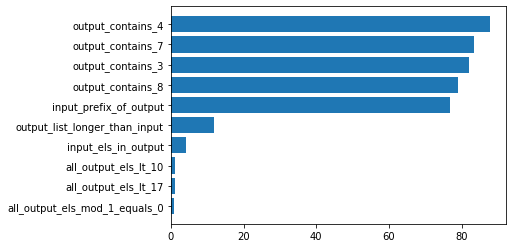

Output too long
Program: (lambda (flatten (mapi (lambda (lambda $2)) $0)))
input: ([3, 2, 5, 5, 1, 9, 5, 6, 1, 5, 8, 2, 3, 0, 5, 9, 0, 4, 8, 8, 8, 2, 9, 0, 8, 3, 2, 4, 3, 9, 3, 6, 1, 3, 7, 5, 6, 4, 4, 4, 7, 2, 6, 1, 2, 6, 1, 0, 6, 5, 4, 5, 6, 2, 2, 0, 5, 0, 6, 6, 9, 0, 0, 9, 4, 5, 3, 6],)
Output too long
Program: (lambda (flatten (map (lambda $1) $0)))
input: ([3, 2, 5, 5, 1, 9, 5, 6, 1, 5, 8, 2, 3, 0, 5, 9, 0, 4, 8, 8, 8, 2, 9, 0, 8, 3, 2, 4, 3, 9, 3, 6, 1, 3, 7, 5, 6, 4, 4, 4, 7, 2, 6, 1, 2, 6, 1, 0, 6, 5, 4, 5, 6, 2, 2, 0, 5, 0, 6, 6, 9, 0, 0, 9, 4, 5, 3, 6],)
Dropping 653 out of 13742 due to error when executing on specified inputs
Creating Similar Task Matrix
Finished Creating Similar Task Matrix with size: (13089, 32)
propertyToPriorDistribution (3, 32)
Program: (lambda (++ $0 (cons 7 (cons 3 (cons 8 (cons 4 (singleton 3)))))))
068_1 : list(int) -> list(int)
f([5, 8, 0, 2, 2, 1, 3, 7, 9, 4, 6, 1, 5, 0, 8, 5]) = [5, 8, 0, 2, 2, 1, 3, 7, 9, 4, 6, 1, 5, 0, 8, 5, 7, 3, 8, 4, 3]
f([0,

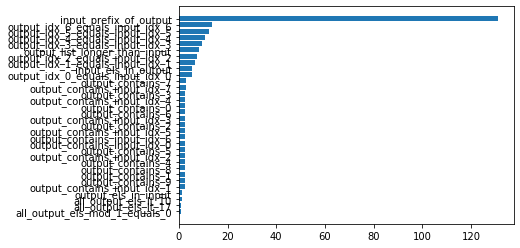

In [15]:
def getTaskIdx(taskName, tasks):
    taskIdx = [i for i,t in enumerate(tasks) if t.name == taskName]
    assert len(taskIdx) == 1
    return taskIdx[0]

taskIdx = getTaskIdx(taskDropdown.value, tasks)

def plot_properties(taskIdx, tasks):
    _, _, sortedPropAndScores = createSimilarTasksDf(
        tasks,
        taskIdx,
        helmholtzFrontiers, 
        properties,
#         propertySimTasksMatrix=helmholtzTasksPropertyMatrix, 
        propertySimTasksMatrix=None,
        propertyToPriorDistribution=propertyToPriorDistribution, 
        valuesToInt=valuesToInt,
        onlyUseTrueProperties=True,
        filterSimilarProperties=False, 
        maxFractionSame=None, 
        recomputeTasksWithTaskSpecificInputs=True, 
        computePriorFromTasks=False,
        verbose=False)

    print("Program: {}".format(tasks[taskIdx].program))
    print(tasks[taskIdx].describe())

    fig, ax = plt.subplots()
    ax.barh([el[0].name for el in sortedPropAndScores], [1.0 / el[1] for el in sortedPropAndScores])
    ax.invert_yaxis()
    plt.show()
    
plot_properties(taskIdx, standard_input_tasks)
plot_properties(taskIdx, long_input_tasks)

## Enumeration Proxy Plot

In [177]:
from dreamcoder.domains.list.utilsBaselines import getGrammarsFromNeuralRecognizer
from dreamcoder.domains.list.utilsPlotting import plotProxyResults

saveDirectory = "helmholtz_frontiers/josh_rich_0_10_enumerated/"

args["earlyStopping"] = False
args["helmholtzRatio"] = 0.0
args["recognitionSteps"] = 10000
args["recognitionTimeout"] = 3600

# load neural grammars for standard and long inputs
pklFile = "data/prop_sig/helmholtz_frontiers/josh_rich_0_10_enumerated/13742_with_josh_fleet_0_10-inputs_neural_ep=False_RS=10000_RT=3600_hidden=64_r=0.0_contextual=False_josh_3_long_inputs_0_10_grammars.pkl"
neuralGrammarLongInput = dill.load(open(pklFile, "rb"))
pklFile = "data/prop_sig/helmholtz_frontiers/josh_rich_0_10_enumerated/13742_with_josh_fleet_0_10-inputs_neural_ep=False_RS=10000_RT=3600_hidden=64_r=0.0_contextual=False_josh_fleet_0_10_grammars.pkl"
neuralGrammarStandInput = dill.load(open(pklFile, "rb"))
neuralGrammars = [neuralGrammarStandInput, neuralGrammarLongInput]

# load prop sig grammars for standard and long inputs
pklFile = "data/prop_sig/helmholtz_frontiers/josh_rich_0_10_enumerated/13742_with_josh_fleet_0_10-inputs_prop_sig_neural_ep=False_RS=10000_RT=3600_hidden=64_r=0.0_contextual=False_josh_3_long_inputs_0_10_grammars.pkl"
propSigGrammarLongInput = dill.load(open(pklFile, "rb"))
pklFile = "data/prop_sig/helmholtz_frontiers/josh_rich_0_10_enumerated/13742_with_josh_fleet_0_10-inputs_prop_sig_neural_ep=False_RS=10000_RT=3600_hidden=64_r=0.0_contextual=False_josh_fleet_0_10_grammars.pkl"
propSigGrammarStandInput = dill.load(open(pklFile, "rb"))
propSigGrammars = [propSigGrammarStandInput, propSigGrammarLongInput]

# helmholtlszGrammar = baseGrammar.insideOutside(helmholtzFrontiers, pseudoCounts=1)

### Ground truth program log posterior per task for standard inputs

In [201]:
grammars = [neuralGrammars[0], helmholtzGrammar, task2FittedGrammars[0], propSigGrammars[0], task2FittedGrammarsPriorFromTasks[0], baseGrammar]
modelNames = ["neural", "helmholtzFitted", "propsim", "propsim (alt prop score)", "propSigNeural", "uniform"]
modelToLogPosteriors = enumerationProxy(grammars, standard_input_tasks, modelNames, verbose=True)


-------------------------------------------------------------------------------
c001 : list(int) -> list(int)
f([2, 4, 3, 2]) = [3]
f([9, 6, 9, 8, 6]) = [9]
f([0, 0, 0, 0, 0]) = [0]
f([8, 1, 8]) = [8]
f([5, 7, 5, 7, 5]) = [5]
f([1, 1, 1, 1]) = [1]
f([7, 9, 3, 4]) = [3]
f([7, 7, 7]) = [7]
f([5, 3, 6]) = [6]
f([2, 2, 2, 8]) = [2]
f([0, 6, 4, 4, 0, 6, 4]) = [4]
Ground Truth Program: (lambda (singleton (third $0)))
---------------------------------------------------------------------------------
neural: -7.205084241518971
helmholtzFitted: -9.062243729034815
propsim: -4.924512702908675
propsim (alt prop score): -4.192526332445857
propSigNeural: -4.924512702908675
uniform: -10.728320673921449

-------------------------------------------------------------------------------
c002 : list(int) -> list(int)
f([0, 5]) = []
f([5, 6, 1, 3, 2, 0, 7, 8, 9, 4]) = [1]
f([6, 7, 8, 1, 4, 3, 0, 5, 9, 2]) = [8]
f([7, 4, 3, 9, 5, 8, 2, 1, 6]) = [3]
f([4, 6]) = []
f([3, 9]) = []
f([4, 7, 1, 2, 6, 3, 8, 9, 0, 

Ground Truth Program: (lambda (slice 2 4 $0))
---------------------------------------------------------------------------------
neural: -11.246467488564651
helmholtzFitted: -11.896961669435576
propsim: -10.284869366301221
propsim (alt prop score): -9.386009899676699
propSigNeural: -10.242100755096828
uniform: -14.129518055583603

-------------------------------------------------------------------------------
c012 : list(int) -> list(int)
f([3, 3, 4, 7, 6]) = [3, 4, 7]
f([7, 8, 2, 0, 4, 2]) = [8, 2, 0]
f([6]) = []
f([2, 9, 4]) = [9, 4]
f([6, 8]) = [8]
f([1, 6, 1]) = [6, 1]
f([0, 8, 0, 8, 8, 0, 8]) = [8, 0, 8]
f([8]) = []
f([5, 5, 5]) = [5, 5]
f([9, 3, 2, 6]) = [3, 2, 6]
f([4, 4]) = [4]
Ground Truth Program: (lambda (slice 2 4 $0))
---------------------------------------------------------------------------------
neural: -11.22674526885028
helmholtzFitted: -11.896961669435576
propsim: -8.204709297522546
propsim (alt prop score): -9.156056146005216
propSigNeural: -8.204709297522546
uniform

Ground Truth Program: (lambda (drop 2 $0))
---------------------------------------------------------------------------------
neural: -5.620815882914334
helmholtzFitted: -7.035547699521558
propsim: -7.050424981343147
propsim (alt prop score): -5.191149152462824
propSigNeural: -7.050424981343147
uniform: -10.728320673921449

-------------------------------------------------------------------------------
c030 : list(int) -> list(int)
f([6, 4, 8, 1, 0]) = [6, 4, 8]
f([9, 7, 4, 3, 8, 1]) = [9, 7, 4, 3]
f([2, 5, 7, 8, 2, 2, 9, 3, 1, 0]) = [2, 5, 7, 8, 2, 2, 9, 3]
f([5, 4, 5, 0]) = [5, 4]
f([6, 2, 9, 7, 8, 3, 8, 5, 0]) = [6, 2, 9, 7, 8, 3, 8]
f([5, 3]) = []
f([6, 4, 1, 6, 7, 2, 5, 8]) = [6, 4, 1, 6, 7, 2]
f([0, 0, 3, 3, 0, 3, 0]) = [0, 0, 3, 3, 0]
f([5, 7, 1, 8, 9, 4, 1, 6, 2, 3]) = [5, 7, 1, 8, 9, 4, 1, 6]
f([9, 7, 2, 5, 9, 4, 6, 8, 4]) = [9, 7, 2, 5, 9, 4, 6]
f([1, 0, 1]) = [1]
Ground Truth Program: (lambda (droplast 2 $0))
-------------------------------------------------------------------

Ground Truth Program: (lambda (append $0 9))
---------------------------------------------------------------------------------
neural: -12.639380471159134
helmholtzFitted: -14.19909152536721
propsim: -9.352111319934878
propsim (alt prop score): -11.594805780749601
propSigNeural: -7.446518596821359
uniform: -10.728320673921449

-------------------------------------------------------------------------------
c039 : list(int) -> list(int)
f([9, 3, 6]) = [9, 3, 6, 3]
f([2, 1, 0, 1, 7, 8, 1, 8, 7]) = [2, 1, 0, 1, 7, 8, 1, 8, 7, 9]
f([9, 1, 4]) = [9, 1, 4, 3]
f([0, 5, 6, 5, 5]) = [0, 5, 6, 5, 5]
f([4, 5, 8, 4, 0, 2, 8, 7, 2]) = [4, 5, 8, 4, 0, 2, 8, 7, 2, 9]
f([1, 5, 7, 3, 4, 8, 6, 9, 2]) = [1, 5, 7, 3, 4, 8, 6, 9, 2, 9]
f([7, 8, 4, 6, 3, 5, 1]) = [7, 8, 4, 6, 3, 5, 1]
f([3, 8, 6]) = [3, 8, 6, 3]
f([7, 2, 4, 4, 9, 5, 7, 2, 3]) = [7, 2, 4, 4, 9, 5, 7, 2, 3, 9]
f([0, 0, 6, 6, 0, 0]) = [0, 0, 6, 6, 0, 0]
f([2, 1, 9]) = [2, 1, 9, 3]
Ground Truth Program: (lambda (if (eq? (length $0) 3) (append $0

neural: -22.16026593591934
helmholtzFitted: -29.8240878675189
propsim: -19.090300056150266
propsim (alt prop score): -18.220635943746785
propSigNeural: -18.892623701787347
uniform: -38.98735678508865

-------------------------------------------------------------------------------
c048 : list(int) -> list(int)
f([6, 4, 7, 9]) = [6]
f([4, 8, 6]) = [4]
f([3, 3, 3]) = [3]
f([2, 2]) = [2]
f([1, 9, 9, 5, 5]) = [1]
f([0, 0, 0, 0]) = [0]
f([7, 4, 7, 8, 7, 1, 6]) = [7]
f([2, 1]) = [2]
f([9, 6, 6, 3]) = [9]
f([5, 5, 5, 5, 5, 5]) = [5]
f([8, 8, 8, 8, 8]) = [8]
Ground Truth Program: (lambda (take 1 $0))
---------------------------------------------------------------------------------
neural: -5.1439750749643895
helmholtzFitted: -6.9603938342060445
propsim: -5.163297861711836
propsim (alt prop score): -5.002896939582879
propSigNeural: -5.163297861711836
uniform: -10.728320673921449

-------------------------------------------------------------------------------
c049 : list(int) -> list(int)
f([3, 3

Ground Truth Program: (lambda (cut_idx 5 $0))
---------------------------------------------------------------------------------
neural: -6.269659632468434
helmholtzFitted: -6.753217558001404
propsim: -5.918747197031842
propsim (alt prop score): -5.638522718633471
propSigNeural: -5.918747197031842
uniform: -10.728320673921449

-------------------------------------------------------------------------------
c057 : list(int) -> list(int)
f([3, 3, 3, 3, 3, 3, 3]) = [3, 3, 3, 3, 3, 3, 4, 3]
f([2, 7, 8, 4, 0, 6, 5, 1]) = [2, 7, 8, 4, 0, 6, 4, 5, 1]
f([2, 3, 9, 7, 6, 0, 0, 8]) = [2, 3, 9, 7, 6, 0, 4, 0, 8]
f([2, 9, 9, 2, 9, 9, 2, 2, 2]) = [2, 9, 9, 2, 9, 9, 4, 2, 2, 2]
f([5, 9, 3, 7, 2, 1, 6, 0, 8]) = [5, 9, 3, 7, 2, 1, 4, 6, 0, 8]
f([4, 5, 4, 5, 5, 9, 5, 4]) = [4, 5, 4, 5, 5, 9, 4, 5, 4]
f([6, 6, 3, 3, 6, 7, 3, 7, 3, 3]) = [6, 6, 3, 3, 6, 7, 4, 3, 7, 3, 3]
f([2, 5, 6, 3, 2, 9, 2, 0, 0, 0]) = [2, 5, 6, 3, 2, 9, 4, 2, 0, 0, 0]
f([3, 9, 9, 3, 3, 9, 3, 9, 3, 3]) = [3, 9, 9, 3, 3, 9, 4, 3, 9, 3, 3

Ground Truth Program: (lambda (cons 9 (append $0 7)))
---------------------------------------------------------------------------------
neural: -17.672615290605105
helmholtzFitted: -19.931509691359146
propsim: -11.89510893041054
propsim (alt prop score): -17.106708067520465
propSigNeural: -11.689197575359264
uniform: -17.79307970171325

-------------------------------------------------------------------------------
c066 : list(int) -> list(int)
f([5, 6, 5, 8]) = [6, 5, 8, 5]
f([1, 6, 6]) = [6, 6, 1]
f([8, 2, 4, 7, 3, 0]) = [2, 4, 7, 3, 0, 8]
f([7, 9, 8, 2, 5, 1, 2, 4]) = [9, 8, 2, 5, 1, 2, 4, 7]
f([3, 7]) = [7, 3]
f([0, 1, 8, 9, 2, 7, 5]) = [1, 8, 9, 2, 7, 5, 0]
f([3, 2, 2, 5, 1, 0, 8, 7, 1, 0]) = [2, 2, 5, 1, 0, 8, 7, 1, 0, 3]
f([1, 4, 3]) = [4, 3, 1]
f([2, 9, 9, 5, 6]) = [9, 9, 5, 6, 2]
f([0, 7, 3, 3, 3, 9, 9, 6]) = [7, 3, 3, 3, 9, 9, 6, 0]
f([4, 1, 5, 8, 6, 5, 4, 0, 9]) = [1, 5, 8, 6, 5, 4, 0, 9, 4]
Ground Truth Program: (lambda (append (drop 1 $0) (first $0)))
---------------------

### Plot ground truth program log posterior for standard inputs

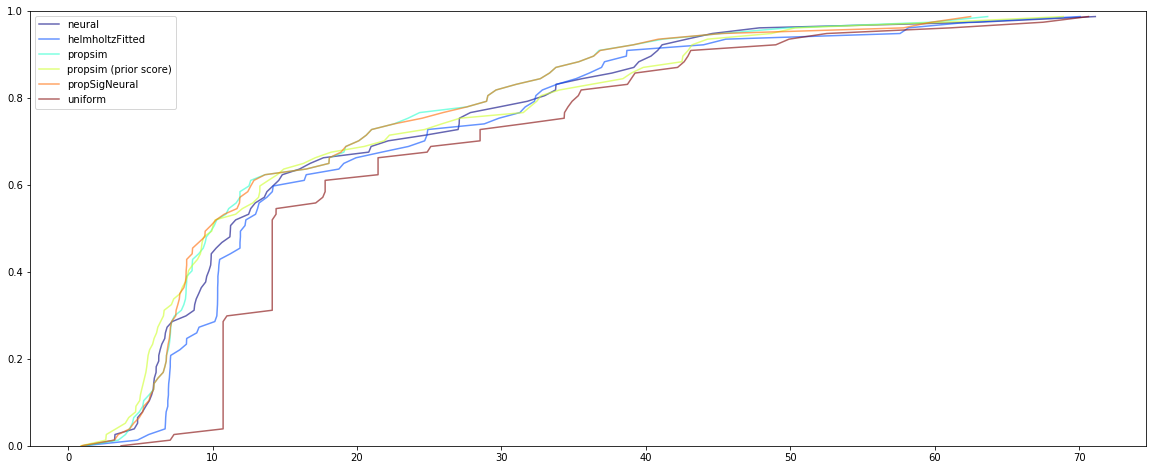

In [198]:
modelToLogPosteriors = {model: [task2LogPosterior[t] for t in sorted(task2LogPosterior.keys(), key=lambda task: task.name)] for model, task2LogPosterior in modelToLogPosteriors.items()}
plt.figure(figsize=(20, 8))
plotProxyResults(modelToLogPosteriors, save=False)

### Ground truth program log posterior per task for long inputs

In [202]:
grammars = [neuralGrammars[1], helmholtzGrammar, task2FittedGrammars[1], task2FittedGrammarsPriorFromTasks[1], propSigGrammars[1], baseGrammar]
modelNames = ["neural", "helmholtzFitted", "propsim", "propsim (alt prop score)", "propSigNeural", "uniform"]
modelToLogPosteriors = enumerationProxy(grammars, long_input_tasks, modelNames, verbose=True)


-------------------------------------------------------------------------------
001_1 : list(int) -> list(int)
f([1, 2, 5, 7, 9, 3, 1, 8, 5, 4, 0, 3, 3, 6]) = [5]
f([4, 4, 1, 5, 9, 7, 6, 2, 8, 3, 5, 3, 4, 4, 0, 1, 2, 9]) = [1]
f([9, 7, 8, 9, 4, 0, 2, 2, 6, 6, 2, 2, 3, 4, 9, 9, 3, 9, 5, 3, 4, 9, 7, 7, 2, 7, 4, 1, 5, 3, 5, 9, 6, 8, 0, 8, 3, 9, 4, 1, 0, 5]) = [8]
f([9, 7, 3, 7, 8, 4, 3, 6, 9, 8, 1, 4, 7, 5, 9, 0, 2, 0, 0, 7, 8, 1, 7, 8, 8, 9, 4, 4, 7, 4, 1]) = [3]
f([1, 0, 0, 3, 1, 1, 2, 6, 4, 0, 7, 3, 5, 1, 8, 9, 7, 5, 5]) = [0]
f([5, 8, 1, 8, 3, 5, 2, 0, 4, 3, 0, 2, 2, 6, 9, 7, 8, 8, 7, 5, 0, 7, 1, 9, 7, 1, 5, 8, 1, 4, 7, 6, 4, 6, 8, 0, 6, 4, 2, 5, 1, 8, 5, 0, 3, 5, 5, 9, 2, 1, 1, 6, 6, 7, 9, 6, 0, 8]) = [1]
f([3, 0, 4, 7, 4, 7, 9, 3, 5, 6, 2, 7, 2, 4, 1, 1, 0, 6, 2, 8, 7, 4, 5, 6, 4, 6, 6, 5, 4, 9, 8, 9, 6, 0, 5, 5, 2, 6, 2, 9, 4]) = [4]
f([2, 0, 1, 7, 7, 8, 3, 1, 4, 0, 3, 5, 0, 3, 5, 3, 7, 8, 5, 4, 4, 1, 6, 8, 2, 2, 3, 4, 7, 4, 2, 9, 5, 0, 5, 2, 6, 5, 9, 6, 8, 2, 7, 2, 8, 6, 6, 3, 8,

Ground Truth Program: (lambda (take 2 $0))
---------------------------------------------------------------------------------
neural: -5.411672528962534
helmholtzFitted: -6.8984332068468674
propsim: -4.246482506273544
propsim (alt prop score): -4.06611082025952
propSigNeural: -5.084275660874571
uniform: -10.728320673921449

-------------------------------------------------------------------------------
007_1 : list(int) -> list(int)
f([5, 2, 0, 0, 8, 1, 3, 9, 4, 5, 6, 3, 4, 7, 4, 2]) = [5, 2]
f([7, 8, 8, 9, 9, 4, 3, 5, 0, 6, 8, 2, 6, 1, 7, 7, 6, 1, 2, 5, 0, 3, 5, 5, 3, 4, 1, 5, 4, 0, 1]) = [7, 8]
f([0, 0, 3, 2, 1, 8, 5, 4, 7, 5, 9, 1, 1, 4, 8, 5, 7, 0, 3, 7, 0, 9, 6, 7, 1, 3, 6, 5, 7, 2, 4, 0, 2, 2]) = [0, 0]
f([9, 7, 7, 4, 8, 9, 6, 5, 2, 9, 1, 2, 6, 4, 7, 1, 1, 9, 6, 3, 0, 9, 9, 2, 7, 6, 1, 9, 0, 9, 0, 6, 1, 2, 7, 8, 1, 8, 8, 6, 1, 3, 7, 9, 8, 2, 0, 4, 5, 4, 5, 8, 9, 1, 0, 0, 6, 5, 4, 6, 0, 5, 4, 5, 5, 4]) = [9, 7]
f([7, 1, 9, 2, 2, 6, 8, 8, 3, 3, 4, 4, 5, 0, 1, 6, 9, 3, 2]) = [7, 1]
f

f([4, 1, 0, 2, 3, 9, 8, 4, 6, 9, 7, 8, 2, 7, 0, 7, 5, 2, 3]) = [1, 0, 2]
Ground Truth Program: (lambda (slice 2 4 $0))
---------------------------------------------------------------------------------
neural: -10.72631930843207
helmholtzFitted: -11.896961669435576
propsim: -10.284869366301221
propsim (alt prop score): -10.299411150816354
propSigNeural: -10.282467728232598
uniform: -14.129518055583603

-------------------------------------------------------------------------------
012_1 : list(int) -> list(int)
f([8, 5, 8, 9, 7, 5, 8, 2, 9, 4, 5, 9, 1, 2, 0, 6, 3, 0]) = [5, 8, 9]
f([2, 4, 8, 8, 5, 9, 0, 2, 9, 0, 3, 2, 5, 5, 3, 1, 1, 6, 9, 6, 4, 9, 4, 1, 7, 8, 7, 2]) = [4, 8, 8]
f([3, 5, 1, 6, 0, 4, 6, 7, 0, 1, 6, 5, 1, 5, 7, 1, 9, 4, 2, 5, 0, 4, 8, 0]) = [5, 1, 6]
f([7, 3, 3, 1, 1, 6, 7, 8, 5, 3, 9, 4, 4, 2, 5, 3, 9, 5, 0, 5, 6, 9, 2, 3, 2, 4, 8, 9, 2, 9]) = [3, 3, 1]
f([9, 0, 6, 5, 2, 8, 7, 2, 4, 3, 6, 5, 1, 5]) = [0, 6, 5]
f([1, 9, 4, 3, 6, 6, 7, 2, 9, 0, 2, 7, 2, 2, 4, 2, 7, 0, 3, 4,

Ground Truth Program: (lambda (replaceEl 2 8 $0))
---------------------------------------------------------------------------------
neural: -10.475599707008634
helmholtzFitted: -10.367743470345928
propsim: -10.794147272134051
propsim (alt prop score): -10.759661096062882
propSigNeural: -11.331369921648921
uniform: -14.129518055583603

-------------------------------------------------------------------------------
017_1 : list(int) -> list(int)
f([1, 6, 7, 2, 5, 5, 3, 0, 6, 4, 9, 5, 7, 6, 0, 8, 3, 5, 8, 9, 7, 9, 6, 6, 9, 9, 6, 4, 7, 6, 1, 2, 9, 9, 9, 7, 3, 8, 1, 9, 5, 3, 4, 8, 3, 0]) = [1, 8, 7, 2, 5, 5, 3, 0, 6, 4, 9, 5, 7, 6, 0, 8, 3, 5, 8, 9, 7, 9, 6, 6, 9, 9, 6, 4, 7, 6, 1, 2, 9, 9, 9, 7, 3, 8, 1, 9, 5, 3, 4, 8, 3, 0]
f([8, 1, 1, 2, 4, 2, 1, 7, 6, 0, 2, 7, 0, 6, 3, 0, 5, 9, 8, 9, 4, 5, 7, 7, 4, 6, 7, 1, 8, 1, 4, 8, 5, 0, 7, 2, 8, 6, 4, 6, 5, 5, 5, 3, 8, 7, 9, 2, 3, 5, 6, 4, 0, 8, 7, 9, 4, 4, 3, 1, 6, 0, 3, 5, 5, 9, 3, 8, 9, 5, 2, 5, 2, 8, 0, 0, 1, 3, 9, 5, 0, 7, 4, 4, 2, 3, 0, 1, 0,

Ground Truth Program: (lambda (replaceEl 6 3 $0))
---------------------------------------------------------------------------------
neural: -11.353831606017238
helmholtzFitted: -10.349821645151277
propsim: -12.750628205803235
propsim (alt prop score): -12.452032012600752
propSigNeural: -9.856696629989496
uniform: -14.129518055583603

-------------------------------------------------------------------------------
020_1 : list(int) -> list(int)
f([2, 7, 4, 4, 8, 4, 4, 7, 2, 7, 1, 4, 0, 6, 7, 8, 5, 8, 1, 3, 5, 3, 6, 7, 7, 0, 9, 9, 3, 3, 6]) = [6, 7, 4, 4, 8, 4, 4, 7, 2, 7, 1, 4, 0, 6, 7, 8, 5, 8, 1, 3, 5, 3, 6, 7, 7, 0, 9, 9, 3, 3, 6]
f([0, 0, 5, 4, 9, 3, 7, 2, 2, 5, 1, 6, 3, 8, 5, 2]) = [2, 0, 5, 4, 9, 3, 7, 2, 2, 5, 1, 6, 3, 8, 5, 2]
f([5, 0, 7, 6, 6, 0, 0, 3, 1, 8, 7, 3, 5, 9, 2, 0, 7, 0, 4, 2, 9, 9, 5, 6]) = [6, 0, 7, 6, 6, 0, 0, 3, 1, 8, 7, 3, 5, 9, 2, 0, 7, 0, 4, 2, 9, 9, 5, 6]
f([2, 1, 3, 3, 7, 5, 8, 2, 3, 4, 7, 4, 3, 1, 6, 9, 6, 6, 8, 5, 3, 8, 8, 0, 4, 6, 0, 7, 2, 2, 3, 7, 4, 4, 0

Ground Truth Program: (lambda (insert 5 2 $0))
---------------------------------------------------------------------------------
neural: -10.807256755969192
helmholtzFitted: -10.293200936250209
propsim: -12.856428907579591
propsim (alt prop score): -10.48443753873144
propSigNeural: -10.93496334225227
uniform: -14.129518055583603

-------------------------------------------------------------------------------
023_1 : list(int) -> list(int)
f([0, 4, 7, 2, 7, 3, 0, 9, 3, 6, 8, 5, 1, 7, 4, 2, 8, 8, 7, 4, 8, 2, 4, 9, 0, 6, 9, 6, 0, 2, 1, 2, 5, 5, 8, 9, 4, 0, 1, 0, 8, 7, 6, 2, 1, 7, 0, 8, 2, 9, 4, 1, 7, 1, 7, 6, 7, 3, 9, 1, 6, 4]) = [0, 5, 4, 7, 2, 7, 3, 0, 9, 3, 6, 8, 5, 1, 7, 4, 2, 8, 8, 7, 4, 8, 2, 4, 9, 0, 6, 9, 6, 0, 2, 1, 2, 5, 5, 8, 9, 4, 0, 1, 0, 8, 7, 6, 2, 1, 7, 0, 8, 2, 9, 4, 1, 7, 1, 7, 6, 7, 3, 9, 1, 6, 4]
f([1, 6, 2, 6, 4, 7, 5, 3, 9, 7, 0, 8]) = [1, 5, 6, 2, 6, 4, 7, 5, 3, 9, 7, 0, 8]
f([4, 8, 0, 2, 7, 4, 0, 5, 9, 9, 1, 6, 3, 8, 9, 0, 8, 0, 6, 4, 5, 0, 9, 2, 7, 0, 2, 5, 3, 5, 

f([0, 0, 0, 8, 9, 5, 2, 6, 7, 0, 8, 2, 9, 5, 7, 1, 0, 3, 9, 8, 1, 8, 7, 1, 4, 8, 4, 0, 9, 6, 2, 0, 6, 3, 7, 3, 1, 5, 7, 9]) = [0, 8, 9, 5, 2, 6, 7, 0, 8, 2, 9, 5, 7, 1, 0, 3, 9, 8, 1, 8, 7, 1, 4, 8, 4, 0, 9, 6, 2, 0, 6, 3, 7, 3, 1, 5, 7, 9]
Ground Truth Program: (lambda (drop 2 $0))
---------------------------------------------------------------------------------
neural: -9.46518982272542
helmholtzFitted: -7.035547699521558
propsim: -8.87813338381191
propsim (alt prop score): -9.029409245486717
propSigNeural: -7.278701941739218
uniform: -10.728320673921449

-------------------------------------------------------------------------------
030_1 : list(int) -> list(int)
f([4, 3, 9, 9, 5, 2, 8, 6, 7, 3, 5, 2, 7, 7, 1, 4, 7, 3, 1, 0, 5, 4, 8, 8, 9, 1]) = [4, 3, 9, 9, 5, 2, 8, 6, 7, 3, 5, 2, 7, 7, 1, 4, 7, 3, 1, 0, 5, 4, 8, 8]
f([0, 4, 9, 3, 6, 8, 1, 7, 5, 2]) = [0, 4, 9, 3, 6, 8, 1, 7]
f([3, 6, 7, 8, 4, 1, 9, 2, 3, 5, 0]) = [3, 6, 7, 8, 4, 1, 9, 2, 3]
f([3, 4, 4, 6, 5, 9, 9, 1, 5, 2, 8, 4, 0

Ground Truth Program: (lambda (if (gt? (first $0) (last $0)) (drop 2 $0) (droplast 2 $0)))
---------------------------------------------------------------------------------
neural: -44.00831448358212
helmholtzFitted: -36.93090546930157
propsim: -40.92517811716859
propsim (alt prop score): -41.412832509020966
propSigNeural: -42.05586263653679
uniform: -42.194160028722585

-------------------------------------------------------------------------------
033_1 : list(int) -> list(int)
f([6, 9, 2, 3, 8, 8, 6, 1, 6, 9, 7, 3, 4, 7, 9, 4, 5, 7, 0, 6]) = [3, 9, 2, 6, 8, 8, 6, 1, 6, 9, 7, 3, 4, 7, 9, 4, 5, 7, 0, 6]
f([2, 6, 4, 0, 6, 9, 7, 1, 5, 3, 8, 8, 7]) = [0, 6, 4, 2, 6, 9, 7, 1, 5, 3, 8, 8, 7]
f([7, 0, 7, 5, 3, 4, 3, 2, 8, 6, 1, 7, 4, 4, 1, 0, 2, 2, 6, 9, 6, 2]) = [5, 0, 7, 7, 3, 4, 3, 2, 8, 6, 1, 7, 4, 4, 1, 0, 2, 2, 6, 9, 6, 2]
f([9, 7, 6, 7, 0, 2, 3, 8, 9, 7, 5, 2, 1, 6, 2, 9, 6, 2, 4, 1, 0, 5, 1, 0, 4, 9, 6, 0, 4, 8, 2, 8, 6, 1, 1, 7, 7, 5, 5, 7, 3, 0]) = [7, 7, 6, 9, 0, 2, 3, 8, 9, 7, 5

Ground Truth Program: (lambda (if (eq? (second $0) (third $0)) (swap 1 4 $0) (swap 2 3 $0)))
---------------------------------------------------------------------------------
neural: -41.14851481207202
helmholtzFitted: -45.53413360055273
propsim: -40.130512806939116
propsim (alt prop score): -39.53688214664745
propSigNeural: -48.41540840645336
uniform: -49.91113465951743

-------------------------------------------------------------------------------
036_1 : list(int) -> list(int)
f([7, 0, 3, 2, 9, 5, 8, 1, 0, 1, 9, 5, 9, 0, 8, 6, 1, 7, 9, 9, 5, 0, 3, 4, 8, 0, 6, 7, 7, 7, 0, 0, 1, 1, 6, 8, 2, 3, 1, 4, 2, 6, 4, 6, 0, 8, 5, 3, 6, 1, 1, 0, 8]) = [2, 0, 3, 7, 9, 5, 8, 1, 0, 1, 9, 5, 9, 0, 8, 6, 1, 7, 9, 9, 5, 0, 3, 4, 8, 0, 6, 7, 7, 7, 0, 0, 1, 1, 6, 8, 2, 3, 1, 4, 2, 6, 4, 6, 0, 8, 5, 3, 6, 1, 1, 0, 8]
f([5, 6, 4, 6, 3, 8, 5, 4, 3, 8, 2, 1, 0, 7, 4, 7, 1, 3, 8, 8, 6, 0, 8, 0, 6, 5, 0, 0, 6, 2, 8, 1, 5, 7, 6, 8, 7, 1, 3, 2, 4, 0, 1, 3, 9, 7, 6, 8, 9, 3, 9, 1, 9, 5, 8, 5, 5, 9, 1, 9, 6, 7, 

neural: -13.677783464474825
helmholtzFitted: -14.19909152536721
propsim: -7.720676149392773
propsim (alt prop score): -7.937807255683277
propSigNeural: -15.007749971327033
uniform: -10.728320673921449

-------------------------------------------------------------------------------
039_1 : list(int) -> list(int)
f([6, 6, 0, 4, 9, 7, 8, 8, 6, 6, 6, 7, 4, 7, 4, 3, 8, 4, 4, 3, 2, 0, 0, 1, 8, 7, 2, 8, 5, 0, 5, 5, 6, 7, 3, 7, 2, 3, 9, 3]) = [6, 6, 0, 4, 9, 7, 8, 8, 6, 6, 6, 7, 4, 7, 4, 3, 8, 4, 4, 3, 2, 0, 0, 1, 8, 7, 2, 8, 5, 0, 5, 5, 6, 7, 3, 7, 2, 3, 9, 3]
f([8, 9, 5, 6, 4, 6, 8, 7, 3, 3, 2, 8, 4, 8, 9, 3, 8, 6, 0, 0, 3, 7, 5, 8, 3, 0, 7, 4, 8, 8, 0, 6, 3, 0, 6, 9, 4, 7, 2, 5, 5, 3, 1, 6, 7, 8, 6, 5, 7, 5, 7, 1, 3, 9, 7, 9, 2, 2, 9, 7, 3, 0, 5]) = [8, 9, 5, 6, 4, 6, 8, 7, 3, 3, 2, 8, 4, 8, 9, 3, 8, 6, 0, 0, 3, 7, 5, 8, 3, 0, 7, 4, 8, 8, 0, 6, 3, 0, 6, 9, 4, 7, 2, 5, 5, 3, 1, 6, 7, 8, 6, 5, 7, 5, 7, 1, 3, 9, 7, 9, 2, 2, 9, 7, 3, 0, 5]
f([6, 1, 4, 8, 8, 7, 2, 5, 5, 1, 2, 3, 8, 1, 4, 0, 9, 1

Ground Truth Program: (lambda (singleton 9))
---------------------------------------------------------------------------------
neural: -2.8795566692764236
helmholtzFitted: -5.5784128976000655
propsim: -3.2726787106749073
propsim (alt prop score): -3.4478270140030034
propSigNeural: -2.9989544591970976
uniform: -7.064759027791801

-------------------------------------------------------------------------------
042_1 : list(int) -> list(int)
f([1, 7, 4, 8, 7, 1, 0, 6, 8, 1, 8, 5, 6, 4, 1, 1, 3, 9, 4, 1, 9, 3, 4, 8, 4, 1, 6, 8, 2, 6, 0, 8, 9, 0, 7, 3, 1, 2]) = [5, 2]
f([7, 4, 5, 6, 9, 3, 1, 0, 1, 2, 5, 4, 5, 8, 6, 9, 1, 2, 9, 9, 2, 9, 0, 8, 0, 3, 0, 6, 1, 8, 9, 3, 7, 7]) = [5, 2]
f([1, 8, 8, 9, 7, 4, 9, 3, 8, 3, 1, 8, 9, 1, 3, 9, 6, 8, 0, 2, 0, 7, 4, 0, 0, 7, 7, 8, 3, 7, 9, 3, 6, 2, 0, 6, 5, 2, 8, 7, 5, 1, 5, 0, 7, 5, 8]) = [5, 2]
f([4, 2, 4, 8, 1, 2, 0, 5, 2, 8, 2, 6, 5, 6, 3, 8, 1, 7, 4, 5, 8, 9, 2, 3, 6, 6, 3, 8, 0, 6, 0, 5, 7, 4, 0, 0, 4, 6, 5, 1, 1, 3, 1, 3, 3, 6, 8, 0, 4, 0, 0, 2, 6, 

Ground Truth Program: (lambda (cons 7 $0))
---------------------------------------------------------------------------------
neural: -7.5299063190759625
helmholtzFitted: -6.785234188295199
propsim: -7.227762359159021
propsim (alt prop score): -4.829083664727264
propSigNeural: -5.1623261942118965
uniform: -10.728320673921449

-------------------------------------------------------------------------------
047_1 : list(int) -> list(int)
f([3, 2, 6, 8, 0, 2, 3, 5, 0, 4, 9, 2, 5, 4, 7, 2, 3, 1, 1, 0, 6, 3, 3, 4, 5, 4, 5, 9, 8, 8, 9, 7, 3, 7, 4, 9, 1, 7, 7, 6, 1, 5, 0, 9, 6, 6, 2, 1, 1, 5, 8, 3, 8, 9, 6, 6, 6, 1, 2, 1, 0, 7, 6, 6, 4, 1, 1, 8, 0, 8, 2, 4, 5, 6]) = [9, 6, 3, 8, 5, 3, 2, 6, 8, 0, 2, 3, 5, 0, 4, 9, 2, 5, 4, 7, 2, 3, 1, 1, 0, 6, 3, 3, 4, 5, 4, 5, 9, 8, 8, 9, 7, 3, 7, 4, 9, 1, 7, 7, 6, 1, 5, 0, 9, 6, 6, 2, 1, 1, 5, 8, 3, 8, 9, 6, 6, 6, 1, 2, 1, 0, 7, 6, 6, 4, 1, 1, 8, 0, 8, 2, 4, 5, 6]
f([7, 4, 4, 5, 7, 8, 0, 3, 6, 0, 2, 5, 4, 2, 3, 7, 5, 6, 1, 6, 8, 4, 9, 6, 4, 1, 9, 0, 1, 2, 1, 

Ground Truth Program: (lambda (cons (first $0) $0))
---------------------------------------------------------------------------------
neural: -11.929389662549244
helmholtzFitted: -10.154123975580724
propsim: -11.19230544545088
propsim (alt prop score): -7.891207416429902
propSigNeural: -8.676810584537947
uniform: -14.391882320051094

-------------------------------------------------------------------------------
051_1 : list(int) -> list(int)
f([2, 6, 0, 8, 9, 1, 1, 1, 2, 7, 8, 3, 1, 9, 4, 5, 4, 2, 1, 7, 6, 3, 9, 8, 2, 3, 2, 5, 2, 7, 6, 0, 0, 5, 9, 6, 5, 5, 8, 4, 8, 5, 1, 2, 9, 1, 0, 2, 3, 7, 7, 5, 4, 1, 0]) = [2, 2, 2, 2, 2, 2, 6, 0, 8, 9, 1, 1, 1, 2, 7, 8, 3, 1, 9, 4, 5, 4, 2, 1, 7, 6, 3, 9, 8, 2, 3, 2, 5, 2, 7, 6, 0, 0, 5, 9, 6, 5, 5, 8, 4, 8, 5, 1, 2, 9, 1, 0, 2, 3, 7, 7, 5, 4, 1, 0]
f([9, 4, 0, 7, 3, 3, 6, 5, 3, 4, 0, 6, 0, 7, 2, 0, 8, 3, 1, 6, 2, 4, 6, 0, 7, 1, 4, 0, 3, 7, 1, 2, 3, 6, 2, 8, 9]) = [9, 9, 9, 9, 9, 9, 4, 0, 7, 3, 3, 6, 5, 3, 4, 0, 6, 0, 7, 2, 0, 8, 3, 1, 6, 2, 4, 6,

Ground Truth Program: (lambda (++ (repeat (third $0) 3) (drop 3 $0)))
---------------------------------------------------------------------------------
neural: -31.31603018636975
helmholtzFitted: -24.9005368723304
propsim: -26.42550828291221
propsim (alt prop score): -26.600426893569388
propSigNeural: -26.380049608103604
uniform: -28.5214003756347

-------------------------------------------------------------------------------
055_1 : list(int) -> list(int)
f([9, 6, 0, 3, 7, 4, 3, 6, 2, 4, 3, 5, 4, 3, 8, 9, 1, 8]) = [0, 3, 9, 6, 7, 4, 3, 6, 2, 4, 3, 5, 4, 3, 8, 9, 1, 8]
f([0, 5, 2, 6, 8, 9, 2, 1, 3, 0, 1, 0, 8, 8, 6, 7, 8, 2, 4, 4, 3, 5, 7, 6, 1, 9, 5, 5, 2, 5, 0]) = [2, 6, 0, 5, 8, 9, 2, 1, 3, 0, 1, 0, 8, 8, 6, 7, 8, 2, 4, 4, 3, 5, 7, 6, 1, 9, 5, 5, 2, 5, 0]
f([0, 5, 5, 1, 7, 8, 4, 5, 9, 0, 9, 8, 9, 9, 3, 1, 3, 5, 4, 0, 1, 5, 7, 6, 4, 6, 2, 7, 6, 6, 9, 9, 1, 2, 9, 0]) = [5, 1, 0, 5, 7, 8, 4, 5, 9, 0, 9, 8, 9, 9, 3, 1, 3, 5, 4, 0, 1, 5, 7, 6, 4, 6, 2, 7, 6, 6, 9, 9, 1, 2, 9, 0]
f([1, 5

helmholtzFitted: -10.315175076845634
propsim: -11.771852437807022
propsim (alt prop score): -11.873818127878684
propSigNeural: -12.064067316883516
uniform: -14.129518055583603

-------------------------------------------------------------------------------
058_1 : list(int) -> list(int)
f([4, 8, 3, 2, 9, 6, 0, 5, 7, 1, 8, 9]) = [5, 7, 1, 8, 9]
f([8, 5, 2, 0, 6, 7, 9, 1, 8, 3, 1, 4, 6]) = [1, 8, 3, 1, 4, 6]
f([5, 2, 4, 6, 3, 2, 2, 7, 1, 6, 2, 9, 5, 8, 3, 5, 6, 4, 4, 2, 8, 1, 1, 1, 4, 2, 9, 9, 8, 9, 0, 8, 7, 6, 0]) = [7, 1, 6, 2, 9, 5, 8, 3, 5, 6, 4, 4, 2, 8, 1, 1, 1, 4, 2, 9, 9, 8, 9, 0, 8, 7, 6, 0]
f([1, 9, 3, 7, 8, 9, 1, 9, 0, 5, 2, 3, 1, 6, 4, 5, 5, 6, 3, 5, 8, 7, 9, 3, 9]) = [9, 0, 5, 2, 3, 1, 6, 4, 5, 5, 6, 3, 5, 8, 7, 9, 3, 9]
f([0, 3, 9, 0, 3, 4, 4, 5, 8, 1, 1, 5, 2, 7, 6]) = [5, 8, 1, 1, 5, 2, 7, 6]
f([4, 2, 5, 9, 4, 1, 0, 4, 6, 8, 0, 0, 6, 7, 2, 7, 3]) = [4, 6, 8, 0, 0, 6, 7, 2, 7, 3]
f([4, 9, 0, 2, 3, 8, 5, 1, 7, 6, 0]) = [1, 7, 6, 0]
f([8, 9, 3, 0, 7, 6, 5, 2, 5, 9, 7, 4, 7, 

062_1 : list(int) -> list(int)
f([1, 6, 0, 2, 7, 1, 0, 5, 3, 8, 0, 9, 7, 4, 2, 2, 1, 6, 5, 1, 6, 0, 9, 8]) = [1, 6, 0, 2, 7, 1, 0, 5, 3, 8, 0, 9, 7, 4, 2, 2, 1, 6, 5, 1, 6, 0, 9]
f([8, 8, 4, 7, 2, 3, 3, 9, 8, 6, 9, 3, 4, 4, 5, 4, 2, 1, 4, 7, 2, 4, 5, 1, 8, 9, 8, 5, 5, 0, 3, 5, 3, 5, 6, 9, 2, 6, 5, 1, 5, 0, 2, 0, 0, 3, 3, 6, 2, 5, 0, 7, 0, 7, 0]) = [8, 8, 4, 7, 2, 3, 3, 9, 8, 6, 9, 3, 4, 4, 5, 4, 2, 1, 4, 7, 2, 4, 5, 1, 8, 9, 8, 5, 5, 0, 3, 5, 3, 5, 6, 9, 2, 6, 5, 1, 5, 0, 2, 0, 0, 3, 3, 6, 2, 5, 0, 7, 0, 7]
f([8, 2, 8, 3, 2, 4, 7, 7, 8, 7, 4, 7, 4, 5, 9, 1, 6, 3, 4, 2, 1, 3, 2, 9, 1, 8, 5, 9, 5, 2, 0]) = [8, 2, 8, 3, 2, 4, 7, 7, 8, 7, 4, 7, 4, 5, 9, 1, 6, 3, 4, 2, 1, 3, 2, 9, 1, 8, 5, 9, 5, 2]
f([5, 0, 1, 7, 9, 4, 2, 3, 8, 6, 9]) = [5, 0, 1, 7, 9, 4, 2, 3, 8, 6]
f([7, 2, 3, 2, 0, 4, 0, 9, 9, 7, 6, 9, 9, 1, 2, 8, 9, 7, 3, 9, 9, 2, 5, 1]) = [7, 2, 3, 2, 0, 4, 0, 9, 9, 7, 6, 9, 9, 1, 2, 8, 9, 7, 3, 9, 9, 2, 5]
f([6, 4, 6, 1, 5, 9, 2, 3, 4, 5, 1, 7, 7, 1, 7, 8, 9, 8, 7, 4, 1, 3, 7, 4, 0, 1

Ground Truth Program: (lambda (cons 9 (append $0 7)))
---------------------------------------------------------------------------------
neural: -19.69061562022852
helmholtzFitted: -19.931509691359146
propsim: -14.693854927512518
propsim (alt prop score): -12.645936683218851
propSigNeural: -20.939724249723156
uniform: -17.79307970171325

-------------------------------------------------------------------------------
066_1 : list(int) -> list(int)
f([1, 3, 0, 8, 4, 6, 0, 5, 9, 2, 7]) = [3, 0, 8, 4, 6, 0, 5, 9, 2, 7, 1]
f([5, 1, 7, 5, 0, 3, 7, 6, 6, 2, 8, 1, 1, 8, 9, 7, 7, 8, 0, 9, 2, 2, 0, 1, 4, 9, 0, 2, 8, 3, 6, 0, 5, 5, 6, 1, 6, 8, 1, 9, 6, 9, 0, 4, 5, 4, 5, 7, 4, 7, 0, 8, 5, 9, 5, 0, 2, 6, 0, 3]) = [1, 7, 5, 0, 3, 7, 6, 6, 2, 8, 1, 1, 8, 9, 7, 7, 8, 0, 9, 2, 2, 0, 1, 4, 9, 0, 2, 8, 3, 6, 0, 5, 5, 6, 1, 6, 8, 1, 9, 6, 9, 0, 4, 5, 4, 5, 7, 4, 7, 0, 8, 5, 9, 5, 0, 2, 6, 0, 3, 5]
f([9, 8, 6, 9, 2, 2, 0, 8, 5, 8, 4, 8, 8, 6, 4, 8, 8, 6, 7, 5, 3, 9, 9, 9, 3, 9, 9, 0, 2, 8, 2, 7, 7, 8, 1, 3,

Ground Truth Program: (lambda (++ $0 (cons 7 (cons 3 (cons 8 (cons 4 (singleton 3)))))))
---------------------------------------------------------------------------------
neural: -33.84851952747678
helmholtzFitted: -35.15907240145634
propsim: -44.431889656933784
propsim (alt prop score): -42.64398582965356
propSigNeural: -40.06280098349683
uniform: -42.6509184312183

-------------------------------------------------------------------------------
069_1 : list(int) -> list(int)
f([6, 6, 5, 2, 7, 8, 5, 2, 6, 6, 5, 7, 5, 1, 9, 3, 1, 5, 8, 5, 0, 7, 4, 0, 9, 3, 7, 6, 5, 8, 6, 7, 8, 3, 1, 4, 4, 1, 0, 7, 9]) = [9, 3, 4, 0, 6, 6, 5, 2, 7, 8, 5, 2, 6, 6, 5, 7, 5, 1, 9, 3, 1, 5, 8, 5, 0, 7, 4, 0, 9, 3, 7, 6, 5, 8, 6, 7, 8, 3, 1, 4, 4, 1, 0, 7, 9, 7, 2, 9, 1]
f([5, 1, 0, 3, 9, 2, 6, 4, 7, 8]) = [9, 3, 4, 0, 5, 1, 0, 3, 9, 2, 6, 4, 7, 8, 7, 2, 9, 1]
f([1, 0, 2, 5, 7, 9, 3, 0, 5, 5, 6, 9, 8, 4]) = [9, 3, 4, 0, 1, 0, 2, 5, 7, 9, 3, 0, 5, 5, 6, 9, 8, 4, 7, 2, 9, 1]
f([5, 0, 0, 4, 1, 9, 2, 1, 8, 5, 1, 

Ground Truth Program: (lambda (++ $0 $0))
---------------------------------------------------------------------------------
neural: -8.594260637803096
helmholtzFitted: -7.732278144550249
propsim: -6.318860890921198
propsim (alt prop score): -5.29800070078112
propSigNeural: -7.465330970719764
uniform: -10.990684938388938

-------------------------------------------------------------------------------
071_1 : list(int) -> list(int)
f([0, 4, 2, 3, 0, 3, 5, 5, 7, 5, 5, 4, 6, 6, 5, 4, 3, 3, 2, 3, 0, 3, 3, 6, 3, 5, 5, 6, 4, 7, 7, 3, 7, 0, 7, 5, 0, 5, 3, 6, 2, 3, 0, 6, 0, 0, 6, 0, 7, 4, 3, 3, 2, 5, 5, 4, 5, 3, 3, 4, 5, 2, 4, 4, 7, 2, 2, 5, 7, 0, 5, 0, 5, 0, 2, 6, 2, 3, 5, 4, 0, 5, 6, 4, 3, 2, 4, 5, 6]) = [2, 6, 4, 5, 2, 5, 7, 7, 9, 7, 7, 6, 8, 8, 7, 6, 5, 5, 4, 5, 2, 5, 5, 8, 5, 7, 7, 8, 6, 9, 9, 5, 9, 2, 9, 7, 2, 7, 5, 8, 4, 5, 2, 8, 2, 2, 8, 2, 9, 6, 5, 5, 4, 7, 7, 6, 7, 5, 5, 6, 7, 4, 6, 6, 9, 4, 4, 7, 9, 2, 7, 2, 7, 2, 4, 8, 4, 5, 7, 6, 2, 7, 8, 6, 5, 4, 6, 7, 8]
f([4, 0, 5, 0, 5, 5, 0, 1

Ground Truth Program: (lambda (flatten (map (lambda (cons $0 (singleton $0))) $0)))
---------------------------------------------------------------------------------
neural: -25.545181803545574
helmholtzFitted: -19.08368030660333
propsim: -23.72366527084251
propsim (alt prop score): -17.489621183370808
propSigNeural: -23.777365180256496
uniform: -25.10573993194499

-------------------------------------------------------------------------------
074_1 : list(int) -> list(int)
f([7, 7, 1, 8, 1, 7, 7, 7, 7, 8, 7, 7, 1, 8, 7, 8, 8, 1, 8, 7, 1, 1, 1, 1, 8, 1, 7, 7, 1, 7, 7, 7, 7, 8, 1, 7, 1, 8, 7, 7, 7, 7, 7, 8, 1, 1, 8, 1, 8, 8, 7, 8, 8, 8]) = [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
f([0, 3, 4, 4, 5, 0, 9, 3, 0, 4, 4, 9, 3, 4, 7, 3, 7, 4, 3, 7, 9, 9, 0, 5, 3, 0, 4, 4, 5, 3, 7, 5, 7, 5, 0, 3, 3, 3, 3, 7, 9, 5, 5, 9, 5, 5, 5, 3, 7, 9, 0, 0, 0, 3, 9]) = [9, 9, 9, 9, 9, 9, 9, 9]
f([7, 3, 3, 4, 5, 3, 4, 0, 4, 9, 7, 0, 6, 2, 1, 6, 7, 8, 1, 2, 0, 7, 3, 2, 9, 5, 0, 3, 6, 7, 8, 5, 2, 9, 1, 

Ground Truth Program: (lambda (singleton (max $0)))
---------------------------------------------------------------------------------
neural: -5.117142697944937
helmholtzFitted: -8.204906168458331
propsim: -5.939339707289973
propsim (alt prop score): -5.939339707289973
propSigNeural: -5.417253478301628
uniform: -10.728320673921449

-------------------------------------------------------------------------------
079_1 : list(int) -> list(int)
f([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]) = [0]
f([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]) = [0]
f([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Ground Truth Program: (lambda (reverse $0))
---------------------------------------------------------------------------------
neural: -4.467418149220615
helmholtzFitted: -4.790150319808917
propsim: -4.154948186250829
propsim (alt prop score): -4.154948186250829
propSigNeural: -3.137916962604823
uniform: -7.327123292259293
Mean neural Log posterior: -20.051946373074856
Mean helmholtzFitted Log posterior: -19.000196557554606
Mean propsim Log posterior: -18.657183457906488
Mean propsim (alt prop score) Log posterior: -17.74815479507426
Mean propSigNeural Log posterior: -19.69529893077705
Mean uniform Log posterior: -22.092923935947198


### Plot ground truth program log posterior for long inputs

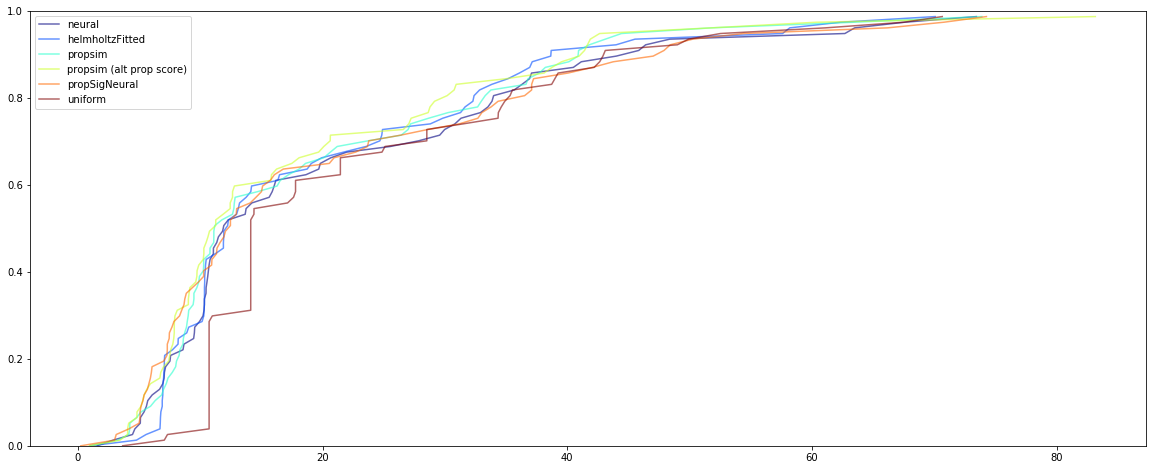

In [200]:
modelToLogPosteriors = {model: [task2LogPosterior[t] for t in sorted(task2LogPosterior.keys(), key=lambda task: task.name)] for model, task2LogPosterior in modelToLogPosteriors.items()}
plt.figure(figsize=(20, 8))
plotProxyResults(modelToLogPosteriors, save=False)

# Better Understanding Propsim

In [78]:
# Run Propsim
args = {'resume': None, 'iterations': 1, 'enumerationTimeout': 10, 'unconditionalEnumerationTimeout': None, 'topK': 2, 'pseudoCounts': 30.0, 'aic': 1.0, 'structurePenalty': 1.0, 'arity': 3, 'CPUs': 96, 'cuda': True, 'maximumFrontier': 10, 'reuseRecognition': False, 'useRecognitionModel': True, 'ensembleSize': 1, 'useDSL': True, 'noConsolidation': False, 'testingTimeout': 0, 'testEvery': 1, 'seed': 0, 'activation': 'tanh', 'solver': 'ocaml', 'compressor': 'ocaml', 'matrixRank': None, 'mask': False, 'biasOptimal': False, 'contextual': False, 'taskBatchSize': None, 'taskSplit': None, 'taskReranker': 'default', 'storeTaskMetrics': True, 'rewriteTaskMetrics': False, 'auxiliaryLoss': False, 'parallelTest': False, 'addFullTaskMetrics': False, 'trainset': 'S12', 'doshaping': False, 'dopruning': False, 'skiptesting': False, 'epochs': 99999, 'libraryName': 'josh_rich_0_10', 'propSamplingPrimitives': 'same', 'dataset': 'josh_3_long_inputs_0_10', 'extractor': 'prop_sig', 'hidden': 64, 'propSim': False, 'helmEnumerationTimeout': 1, 'propNumIters': 1, 'hmfSeed': None, 'numHelmFrontiers': None, 'maxFractionSame': 1.0, 'helmholtzFrontiers': 'josh_rich_0_10_enumerated/13742_with_josh_fleet_0_10-inputs.pkl', 'propFilename': None, 'filterSimilarProperties': False, 'computePriorFromTasks': False, 'nSim': 50, 'propPseudocounts': 1, 'onlyUseTrueProperties': True, 'save': False, 'verbose': False, 'weightByPrior': False, 'weightedSim': False, 'taskSpecificInputs': False, 'singleTask': False, 'debug': False, 'propCPUs': 96, 'propSolver': 'ocaml', 'propEnumerationTimeout': 1, 'propUseConjunction': False, 'propAddZeroToNinePrims': False, 'propScoringMethod': 'unique_task_signature', 'propDreamTasks': False, 'propToUse': 'handwritten', 'propSamplingGrammarWeights': 'uniform', 'propUseEmbeddings': False, 'featureExtractor': None}
args["onlyUseTrueProperties"] = True
args["computePriorFromTasks"] = False
args["taskSpecificInputs"] = True
args["verbose"] = True

helmholtzFrontiers = dill.load(open(fileName, "rb"))
prims = get_primitives(args["libraryName"])
baseGrammar = Grammar.uniform([p for p in prims])
for t in standard_input_tasks + long_input_tasks:
    # parses program string and also executes to check that I/O matches parsed program
    t.parse_program(prims)
tasks = standard_input_tasks

task2FittedGrammar, _, _ = getPropSimGrammars(
   baseGrammar,
   tasks,
   tasks,  
   helmholtzFrontiers, 
   properties_standard_input, 
   args["onlyUseTrueProperties"], 
   args["nSim"], 
   args["propPseudocounts"], 
   args["weightedSim"], 
   compressSimilar=False, 
   weightByPrior=False, 
   recomputeTasksWithTaskSpecificInputs=args["taskSpecificInputs"],
   computePriorFromTasks=args["computePriorFromTasks"], 
   filterSimilarProperties=args["filterSimilarProperties"], 
   maxFractionSame=args["maxFractionSame"], 
   valuesToInt=valuesToInt,
   propSimIteration=0,
   verbose=args["verbose"])


------------------------------------------------ Task c001 ----------------------------------------------------
c001 : list(int) -> list(int)
f([2, 4, 3, 2]) = [3]
f([9, 6, 9, 8, 6]) = [9]
f([0, 0, 0, 0, 0]) = [0]
f([8, 1, 8]) = [8]
f([5, 7, 5, 7, 5]) = [5]
f([1, 1, 1, 1]) = [1]
f([7, 9, 3, 4]) = [3]
f([7, 7, 7]) = [7]
f([5, 3, 6]) = [6]
f([2, 2, 2, 8]) = [2]
f([0, 6, 4, 4, 0, 6, 4]) = [4]
Dropping 1608 out of 13742 due to error when executing on specified inputs
Creating Similar Task Matrix
Finished Creating Similar Task Matrix with size: (12134, 8)
propertyToPriorDistribution (2, 8)
new shape of propertyToPriorDistribution: (2, 8)
new shape of propertySimTasksMatrix: (12134, 8)
8 Highest scoring properties:
0.0248022412656559 -> output_idx_0_equals_input_idx_2 (allTrue)
0.11346407382992749 -> output_list_length_1 (allTrue)
0.12714238628872776 -> output_idx_0_equals_input_idx_6 (allTrue)
0.35934410019775875 -> output_contains_input_idx_2 (allTrue)
0.37129202373104814 -> output_shorte


Program (-17.79307970171325): (lambda (reverse (slice 3 3 $0)))

Task similarity score: 18.927657286351035
Helmholtz : list(int) -> list(int)
f([0, 5]) = []
f([5, 6, 1, 3, 2, 0, 7, 8, 9, 4]) = [1]
f([6, 7, 8, 1, 4, 3, 0, 5, 9, 2]) = [8]
f([7, 4, 3, 9, 5, 8, 2, 1, 6]) = [3]
f([4, 6]) = []
f([3, 9]) = []
f([4, 7, 1, 2, 6, 3, 8, 9, 0, 5]) = [1]
f([5, 7]) = []
f([9, 6, 2, 5, 8, 7, 3, 4, 1, 0]) = [2]
f([8]) = []
f([7, 9, 0, 2, 1, 8, 6, 3, 5, 4]) = [0]

Program (-17.79307970171325): (lambda (take 1 (drop 2 $0)))

Task similarity score: 18.927657286351035
Helmholtz : list(int) -> list(int)
f([0, 5]) = []
f([5, 6, 1, 3, 2, 0, 7, 8, 9, 4]) = [1]
f([6, 7, 8, 1, 4, 3, 0, 5, 9, 2]) = [8]
f([7, 4, 3, 9, 5, 8, 2, 1, 6]) = [3]
f([4, 6]) = []
f([3, 9]) = []
f([4, 7, 1, 2, 6, 3, 8, 9, 0, 5]) = [1]
f([5, 7]) = []
f([9, 6, 2, 5, 8, 7, 3, 4, 1, 0]) = [2]
f([8]) = []
f([7, 9, 0, 2, 1, 8, 6, 3, 5, 4]) = [0]

Program (-17.79307970171325): (lambda (sort (slice 3 3 $0)))

Task similarity score: 18.92765728635


Task similarity score: 18.75798021594817
Helmholtz : list(int) -> list(int)
f([7, 2, 3, 9, 0, 4, 5, 6]) = [5]
f([6, 1, 6, 4, 4, 7, 0, 4, 6, 1]) = [0]
f([0, 5, 7, 4, 9, 1, 3, 6, 7, 8]) = [3]
f([6, 8, 5, 0, 2, 9, 8, 2]) = [8]
f([1, 0, 8, 6, 7, 2, 9, 3, 5, 4]) = [9]
f([1, 3, 1, 1, 5, 5, 1, 9, 1, 3]) = [1]
f([6, 9, 0, 8, 2, 8, 2, 3, 2]) = [2]
f([5, 2, 0, 3, 1, 8, 9, 4, 9, 5]) = [9]
f([0, 6, 4, 3, 2, 7, 6, 1]) = [6]
f([0, 8, 7, 8, 0, 8, 7, 0, 0, 8]) = [7]
f([9, 3, 0, 4, 3, 6, 4, 8, 7]) = [4]

Program (-17.79307970171325): (lambda (unique (singleton (nth 7 $0))))
Helmholtz : list(int) -> list(int)
f([7, 2, 3, 9, 0, 4, 5, 6]) = [5]
f([6, 1, 6, 4, 4, 7, 0, 4, 6, 1]) = [0]
f([0, 5, 7, 4, 9, 1, 3, 6, 7, 8]) = [3]
f([6, 8, 5, 0, 2, 9, 8, 2]) = [8]
f([1, 0, 8, 6, 7, 2, 9, 3, 5, 4]) = [9]
f([1, 3, 1, 1, 5, 5, 1, 9, 1, 3]) = [1]
f([6, 9, 0, 8, 2, 8, 2, 3, 2]) = [2]
f([5, 2, 0, 3, 1, 8, 9, 4, 9, 5]) = [9]
f([0, 6, 4, 3, 2, 7, 6, 1]) = [6]
f([0, 8, 7, 8, 0, 8, 7, 0, 0, 8]) = [7]
f([9, 3, 0, 4, 3, 6, 


------------------------------------------------ Task c005 ----------------------------------------------------
c005 : list(int) -> list(int)
f([2, 1, 9, 6, 7, 0, 4, 5, 3]) = [9]
f([7, 2, 1, 8, 0, 6, 3, 5, 9, 4]) = [5]
f([5, 1, 7, 6, 9, 8, 2, 0, 3, 4]) = [8]
f([9, 1, 6, 4, 7, 5, 3, 8, 2, 0]) = [0]
f([4, 1, 9, 6, 3, 2, 5, 0, 8, 7]) = [3]
f([4, 8, 5, 6, 2, 7, 1, 0, 3, 9]) = [2]
f([6, 1, 2, 8, 5, 4, 7, 9, 3, 0]) = [7]
f([2, 6, 3, 7, 4, 8, 1, 9, 5, 0]) = [3]
f([8, 2, 9, 3, 7, 6, 0, 5, 1, 4]) = [1]
f([3, 9, 4, 5, 1, 8, 2, 0, 6, 7]) = [5]
f([1, 6, 5, 8, 3, 4, 2, 7, 0, 9]) = [6]
Dropping 663 out of 13742 due to error when executing on specified inputs
Creating Similar Task Matrix
Finished Creating Similar Task Matrix with size: (13079, 4)
propertyToPriorDistribution (2, 4)
new shape of propertyToPriorDistribution: (2, 4)
new shape of propertySimTasksMatrix: (13079, 4)
4 Highest scoring properties:
0.13416405473587648 -> output_list_length_1 (allTrue)
0.6147083556303035 -> output_shorter_than

0.1753469387755102 -> output_idx_0_equals_input_idx_0 (allTrue)
0.3564897959183673 -> output_contains_input_idx_0 (allTrue)
0.3603265306122449 -> output_contains_input_idx_1 (allTrue)
0.3749387755102041 -> output_shorter_than_input (allTrue)
0.5133877551020408 -> output_els_in_input (allTrue)
0.9999183673469387 -> all_output_els_mod_1_equals_0 (allTrue)

Found program solution for task c006: (lambda (take 2 $0))

50 Most Similar Prop Sig Tasks
--------------------------------------------------------------------------------

Task similarity score: 22.03227610972836
Helmholtz : list(int) -> list(int)
f([7, 8, 5, 7]) = [7, 8]
f([3, 1, 1, 1, 3, 1, 1]) = [3, 1]
f([8, 0, 8, 7, 4, 0, 4]) = [8, 0]
f([2, 0, 4, 6, 5]) = [2, 0]
f([9, 9, 9]) = [9, 9]
f([4, 3, 3, 5, 5]) = [4, 3]
f([9, 7, 7]) = [9, 7]
f([2, 2, 2, 2, 2]) = [2, 2]
f([0, 4, 0, 0, 0, 4]) = [0, 4]
f([5, 5, 1, 5, 7, 7]) = [5, 5]
f([6, 8, 5]) = [6, 8]

Program (-10.728320673921449): (lambda (take 2 $0))

Task similarity score: 22.032276109


Program (-10.728320673921449): (lambda (cut_vals 4 $0))

Task similarity score: 11.171044030874864
Helmholtz : list(int) -> list(int)
f([0, 2, 2, 0]) = [0, 2, 2, 0]
f([]) = []
f([1]) = [1]
f([3, 3, 1, 9, 8]) = [3, 3, 1, 9, 8]
f([7, 8, 5]) = [7, 8, 5]
f([9, 9, 1, 4, 1, 1, 4, 4, 4, 4]) = [9, 9, 1, 4, 1, 1, 4]
f([7]) = [7]
f([2]) = [2]
f([8]) = [8]
f([6, 6, 6, 6]) = [6, 6, 6, 6]
f([5, 0, 0]) = [5, 0, 0]

Program (-10.728320673921449): (lambda (take 7 $0))
Helmholtz : list(int) -> list(int)
f([0, 2, 2, 0]) = [0, 2]
f([]) = []
f([1]) = [1]
f([3, 3, 1, 9, 8]) = [3, 3]
f([7, 8, 5]) = [7, 8]
f([9, 9, 1, 4, 1, 1, 4, 4, 4, 4]) = [9, 9]
f([7]) = [7]
f([2]) = [2]
f([8]) = [8]
f([6, 6, 6, 6]) = [6, 6]
f([5, 0, 0]) = [5, 0]

Grammar after fitting for task c007:
-0.673729	t0	$_
0.000000	bool	true
0.000000	bool	false
0.000000	int -> int -> bool	gt?
0.000000	int -> int -> bool	lt?
0.000000	int -> bool	is-even
0.000000	int -> bool	is-odd
0.000000	bool -> bool -> bool	and
0.000000	bool -> bool -> bool	o


Program (-17.53071543724576): (lambda (take (+ 5 1) $0))

Task similarity score: 55.278702568123805
Helmholtz : list(int) -> list(int)
f([1, 3, 9, 8, 1, 6, 7]) = [1, 3, 9, 8, 1, 6]
f([9, 2, 2, 6, 9, 9, 2, 9]) = [9, 2, 2, 6, 9, 9]
f([3, 7, 7, 0, 3, 8, 5]) = [3, 7, 7, 0, 3, 8]
f([0, 4, 4, 0, 9, 0, 4]) = [0, 4, 4, 0, 9, 0]
f([4, 0, 5, 6, 5, 0, 5]) = [4, 0, 5, 6, 5, 0]
f([4, 4, 5, 8, 3, 5, 0, 0, 0]) = [4, 4, 5, 8, 3, 5]
f([9, 0, 9, 0, 0, 9, 0]) = [9, 0, 9, 0, 0, 9]
f([3, 5, 5, 8, 9, 6, 4, 0]) = [3, 5, 5, 8, 9, 6]
f([8, 7, 9, 0, 1, 9, 3, 4, 6]) = [8, 7, 9, 0, 1, 9]
f([4, 4, 4, 4, 4, 4, 4, 4, 4, 4]) = [4, 4, 4, 4, 4, 4]
f([0, 7, 0, 2, 3, 6, 7, 9]) = [0, 7, 0, 2, 3, 6]

Program (-17.53071543724576): (lambda (take (+ 2 4) $0))
Helmholtz : list(int) -> list(int)
f([1, 3, 9, 8, 1, 6, 7]) = [1, 3, 9, 8, 1, 6]
f([9, 2, 2, 6, 9, 9, 2, 9]) = [9, 2, 2, 6, 9, 9]
f([3, 7, 7, 0, 3, 8, 5]) = [3, 7, 7, 0, 3, 8]
f([0, 4, 4, 0, 9, 0, 4]) = [0, 4, 4, 0, 9, 0]
f([4, 0, 5, 6, 5, 0, 5]) = [4, 0, 5, 6, 5, 0]
f(


Program (-14.129518055583603): (lambda (cut_slice 7 8 $0))

Task similarity score: 43.14286209297023
Helmholtz : list(int) -> list(int)
f([6, 2, 4, 4, 4, 8, 8]) = [6, 2, 4, 4, 4, 8]
f([7]) = [7]
f([5, 8, 8, 9, 9, 5, 8, 5]) = [5, 8, 8, 9, 9, 5]
f([6, 7, 0]) = [6, 7, 0]
f([1, 1, 1, 1]) = [1, 1, 1, 1]
f([9, 4, 9, 9, 4, 9, 9]) = [9, 4, 9, 9, 4, 9]
f([3, 2, 1, 4, 3, 0, 4]) = [3, 2, 1, 4, 3, 0]
f([]) = []
f([5, 3, 7, 3, 8, 7, 8, 7]) = [5, 3, 7, 3, 8, 7]
f([6, 6]) = [6, 6]
f([0, 5, 2, 2, 2]) = [0, 5, 2, 2, 2]

Program (-14.129518055583603): (lambda (slice 1 6 $0))
Helmholtz : list(int) -> list(int)
f([6, 2, 4, 4, 4, 8, 8]) = [6, 2, 4, 4, 4, 8, 8]
f([7]) = [7]
f([5, 8, 8, 9, 9, 5, 8, 5]) = [5, 8, 8, 9, 9, 5, 8]
f([6, 7, 0]) = [6, 7, 0]
f([1, 1, 1, 1]) = [1, 1, 1, 1]
f([9, 4, 9, 9, 4, 9, 9]) = [9, 4, 9, 9, 4, 9, 9]
f([3, 2, 1, 4, 3, 0, 4]) = [3, 2, 1, 4, 3, 0, 4]
f([]) = []
f([5, 3, 7, 3, 8, 7, 8, 7]) = [5, 3, 7, 3, 8, 7, 8]
f([6, 6]) = [6, 6]
f([0, 5, 2, 2, 2]) = [0, 5, 2, 2, 2]

Grammar afte


Program (-14.391882320051096): (lambda (cut_val (first $0) $0))
Helmholtz : list(int) -> list(int)
f([2, 3, 2, 7, 6]) = []
f([3, 9, 8, 6, 5, 1]) = []
f([1, 2, 4, 5, 0, 8, 9, 7, 8]) = [4]
f([5, 5, 5, 1, 1, 5]) = []
f([0, 2]) = []
f([9, 7, 0, 9, 7, 9, 9, 4, 0, 7]) = [4]
f([3, 8, 3, 3, 8, 3, 3]) = []
f([6, 2, 6, 1, 3, 6, 2, 9]) = []
f([1, 0, 2, 1, 2]) = []
f([8, 2, 5, 7, 1, 5, 5, 8, 8, 8]) = []
f([4, 4, 4, 4, 4, 4, 4, 4, 4]) = [4, 4, 4, 4, 4, 4, 4, 4, 4]

Grammar after fitting for task c010:
-0.693147	t0	$_
-0.693147	bool	true
-0.693147	t0 -> t0 -> bool	eq?
-0.693147	(t0 -> t1) -> list(t0) -> list(list(t0))	group
-1.286665	int -> list(t0) -> list(t0)	cut_idx
-1.386294	bool	false
-1.386294	int -> int -> bool	gt?
-1.386294	int -> int -> bool	lt?
-1.386294	int -> bool	is-even
-1.386294	int -> bool	is-odd
-1.386294	bool -> bool -> bool	and
-1.386294	bool -> bool -> bool	or
-1.386294	bool -> bool	not
-1.386294	list(t0) -> t0 -> bool	is_in
-1.609438	int -> list(t0) -> list(t0)	drop
-1.806148	i


Grammar after fitting for task c011:
-0.721585	t0	$_
0.000000	bool	true
0.000000	(t0 -> t1) -> list(t0) -> list(list(t0))	group
-0.693147	bool	false
-0.693147	int -> int -> bool	gt?
-0.693147	int -> int -> bool	lt?
-0.693147	int -> bool	is-even
-0.693147	int -> bool	is-odd
-0.693147	bool -> bool -> bool	and
-0.693147	bool -> bool -> bool	or
-0.693147	bool -> bool	not
-0.693147	t0 -> t0 -> bool	eq?
-0.693147	list(t0) -> t0 -> bool	is_in
-1.414732	int -> list(t0) -> list(t0)	cut_idx
-1.728390	int -> list(t0) -> list(t0)	drop
-1.945910	int -> int -> int	/
-2.117760	int -> int -> int	mod
-2.182299	int	1
-2.325400	int	6
-2.325400	int	9
-2.405442	int	4
-2.492454	int	2
-2.587764	int	7
-2.693125	int	3
-2.881069	int -> int -> list(t0) -> list(t0)	slice
-2.944439	int	5
-2.944439	int	8
-3.098590	int	10
-3.280911	int -> int -> int	-
-3.286534	int -> list(t0) -> list(t0)	take
-3.979682	list(t0)	empty
-3.979682	t0 -> list(t0) -> list(t0)	cut_val
-3.979682	int -> list(t0) -> list(t0)	takelast
-3.979


------------------------------------------------ Task c013 ----------------------------------------------------
c013 : list(int) -> list(int)
f([8, 5, 5, 8, 8, 5, 5, 5]) = [5, 8, 8, 5, 5]
f([9, 9, 4, 4, 9, 3, 1, 1, 9]) = [4, 4, 9, 3, 1]
f([6, 4, 2, 4, 0, 0, 8, 7, 5]) = [2, 4, 0, 0, 8]
f([3, 2, 0, 3, 4, 4, 6, 6]) = [0, 3, 4, 4, 6]
f([9, 8, 7, 4, 1, 3, 2, 0, 6, 5]) = [7, 4, 1, 3, 2]
f([7, 8, 6, 6, 9, 5, 4, 1, 9, 4]) = [6, 6, 9, 5, 4]
f([3, 7, 9, 1, 3, 0, 5]) = [9, 1, 3, 0, 5]
f([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]) = [0, 0, 0, 0, 0]
f([7, 4, 4, 4, 4, 7, 7, 7, 7]) = [4, 4, 4, 7, 7]
f([9, 0, 5, 2, 1, 2, 6, 0, 6]) = [5, 2, 1, 2, 6]
f([4, 0, 6, 8, 8, 1, 6, 4, 0]) = [6, 8, 8, 1, 6]
Dropping 1313 out of 13742 due to error when executing on specified inputs
Creating Similar Task Matrix
Finished Creating Similar Task Matrix with size: (12429, 14)
propertyToPriorDistribution (2, 14)
new shape of propertyToPriorDistribution: (2, 14)
new shape of propertySimTasksMatrix: (12429, 14)
14 Highest scoring pr


------------------------------------------------ Task c014 ----------------------------------------------------
c014 : list(int) -> list(int)
f([6, 3, 0, 4]) = [0, 4]
f([9, 9, 1]) = [1]
f([0, 7, 9, 6, 1, 8, 2, 3]) = [9, 6, 1, 8, 2]
f([3, 0, 5, 7, 7, 5, 3, 0, 5]) = [5, 7, 7, 5, 3]
f([9]) = []
f([9, 9]) = []
f([2, 3, 0]) = [0]
f([1, 0, 0, 1, 1]) = [0, 1, 1]
f([4, 2, 3, 3, 6, 7, 8]) = [3, 3, 6, 7, 8]
f([5, 4, 5, 8, 6, 2, 8]) = [5, 8, 6, 2, 8]
f([9, 9, 4, 4, 9, 4]) = [4, 4, 9, 4]
Dropping 2176 out of 13742 due to error when executing on specified inputs
Creating Similar Task Matrix
Finished Creating Similar Task Matrix with size: (11566, 16)
propertyToPriorDistribution (2, 16)
new shape of propertyToPriorDistribution: (2, 16)
new shape of propertySimTasksMatrix: (11566, 16)
16 Highest scoring properties:
0.007780082987551867 -> output_idx_1_equals_input_idx_3 (allTrue)
0.0084716459197787 -> output_idx_4_equals_input_idx_6 (allTrue)
0.009681881051175657 -> output_idx_2_equals_input_idx_4 (

Finished Creating Similar Task Matrix with size: (12675, 5)
propertyToPriorDistribution (2, 5)
new shape of propertyToPriorDistribution: (2, 5)
new shape of propertySimTasksMatrix: (12675, 5)
5 Highest scoring properties:
0.006941705450816439 -> output_idx_3_equals_input_idx_5 (allTrue)
0.007730535615681944 -> output_idx_4_equals_input_idx_6 (allTrue)
0.49846178117851225 -> output_els_in_input (allTrue)
0.5080066261733849 -> output_shorter_than_input (allTrue)
0.9999211169835135 -> all_output_els_mod_1_equals_0 (allTrue)

50 Most Similar Prop Sig Tasks
--------------------------------------------------------------------------------

Task similarity score: 22.41270590972438
Helmholtz : list(int) -> list(int)
f([3, 4, 5, 5, 4, 3, 3]) = [5, 5, 4, 3, 3]
f([1, 3, 9, 2, 0, 5, 7, 5, 7, 1]) = [9, 2, 0, 5, 7, 5, 7, 1]
f([4, 5, 6, 6, 4, 6, 9, 9]) = [6, 6, 4, 6, 9, 9]
f([1, 1, 3, 2, 3, 4, 5, 6, 5, 1]) = [3, 2, 3, 4, 5, 6, 5, 1]
f([1, 5, 8, 3, 6, 2, 4, 8, 0]) = [8, 3, 6, 2, 4, 8, 0]
f([6, 7, 0, 1,

Dropping 1734 out of 13742 due to error when executing on specified inputs
Creating Similar Task Matrix
Finished Creating Similar Task Matrix with size: (12008, 21)
propertyToPriorDistribution (2, 21)
new shape of propertyToPriorDistribution: (2, 21)
new shape of propertySimTasksMatrix: (12008, 21)
20 Highest scoring properties:
0.026311407160699418 -> output_contains_8 (allTrue)
0.060116569525395507 -> output_idx_6_equals_input_idx_6 (allTrue)
0.06144879267277269 -> output_idx_7_equals_input_idx_7 (allTrue)
0.06194837635303913 -> output_idx_8_equals_input_idx_8 (allTrue)
0.06860949208992506 -> output_idx_5_equals_input_idx_5 (allTrue)
0.08293089092422981 -> output_idx_4_equals_input_idx_4 (allTrue)
0.09092422980849292 -> output_idx_9_equals_input_idx_9 (allTrue)
0.10832639467110741 -> output_idx_3_equals_input_idx_3 (allTrue)
0.1257285595337219 -> output_idx_2_equals_input_idx_2 (allTrue)
0.15645295587010824 -> output_same_length_as_input (allTrue)
0.20008326394671108 -> output_idx_0_


------------------------------------------------ Task c017 ----------------------------------------------------
c017 : list(int) -> list(int)
f([9, 1, 7, 7]) = [9, 8, 7, 7]
f([9, 2, 1, 6, 4, 0]) = [9, 8, 1, 6, 4, 0]
f([0]) = [0]
f([1, 4, 2, 5, 3, 9, 7, 2]) = [1, 8, 2, 5, 3, 9, 7, 2]
f([0, 2, 2]) = [0, 8, 2]
f([9]) = [9]
f([3, 3]) = [3, 8]
f([5, 7, 2, 4, 0]) = [5, 8, 2, 4, 0]
f([7]) = [7]
f([6]) = [6]
f([]) = []
Dropping 3391 out of 13742 due to error when executing on specified inputs
Creating Similar Task Matrix
Finished Creating Similar Task Matrix with size: (10351, 18)
propertyToPriorDistribution (2, 18)
new shape of propertyToPriorDistribution: (2, 18)
new shape of propertySimTasksMatrix: (10351, 18)
18 Highest scoring properties:
0.09137448082681349 -> output_idx_7_equals_input_idx_2 (allTrue)
0.09948807109050517 -> output_idx_7_equals_input_idx_7 (allTrue)
0.11948227566888825 -> output_idx_5_equals_input_idx_5 (allTrue)
0.11977204674973438 -> output_idx_4_equals_input_idx_4 (al

0.04302967287850916 -> output_contains_3 (allTrue)
0.05262736943133648 -> output_idx_7_equals_input_idx_7 (allTrue)
0.05614652483403983 -> output_idx_8_equals_input_idx_8 (allTrue)
0.06590418299608095 -> output_idx_6_equals_input_idx_6 (allTrue)
0.07590178357194273 -> output_idx_9_equals_input_idx_9 (allTrue)
0.09173798288410781 -> output_idx_4_equals_input_idx_4 (allTrue)
0.11405262736943134 -> output_idx_3_equals_input_idx_3 (allTrue)
0.1273294409341758 -> output_idx_2_equals_input_idx_2 (allTrue)
0.15676237702951293 -> output_idx_1_equals_input_idx_1 (allTrue)
0.16388066863952652 -> output_same_length_as_input (allTrue)
0.19875229944813244 -> output_idx_0_equals_input_idx_0 (allTrue)
0.3420779013036871 -> output_contains_input_idx_4 (allTrue)
0.3590338318803487 -> output_contains_input_idx_2 (allTrue)
0.3661521234903623 -> output_contains_input_idx_6 (allTrue)
0.3768695513076862 -> output_contains_input_idx_7 (allTrue)
0.3787890906182516 -> output_contains_input_idx_1 (allTrue)
0.37


------------------------------------------------ Task c019 ----------------------------------------------------
c019 : list(int) -> list(int)
f([4, 5, 5, 0, 4, 2]) = [4, 5, 5, 0, 4, 3]
f([6, 6]) = [6, 6]
f([3, 7, 2, 0, 4, 9, 8]) = [3, 7, 2, 0, 4, 3, 8]
f([1, 1, 7, 4, 0, 8, 9, 0]) = [1, 1, 7, 4, 0, 3, 9, 0]
f([4, 3, 5, 8, 3, 2, 7, 9, 1]) = [4, 3, 5, 8, 3, 3, 7, 9, 1]
f([6, 6, 6, 6]) = [6, 6, 6, 6]
f([8, 2, 6, 7, 9]) = [8, 2, 6, 7, 9]
f([7, 1, 8, 6, 5, 0, 4, 5, 3, 9]) = [7, 1, 8, 6, 5, 3, 4, 5, 3, 9]
f([9, 9, 9, 2, 0, 2, 3]) = [9, 9, 9, 2, 0, 3, 3]
f([]) = []
f([1, 1, 8]) = [1, 1, 8]
Dropping 3403 out of 13742 due to error when executing on specified inputs
Creating Similar Task Matrix
Finished Creating Similar Task Matrix with size: (10339, 20)
propertyToPriorDistribution (2, 20)
new shape of propertyToPriorDistribution: (2, 20)
new shape of propertySimTasksMatrix: (10339, 20)
20 Highest scoring properties:
0.0614060535731554 -> output_idx_8_equals_input_idx_8 (allTrue)
0.0619862682525


------------------------------------------------ Task c020 ----------------------------------------------------
c020 : list(int) -> list(int)
f([7, 7, 7, 9]) = [9, 7, 7, 9]
f([8, 7, 6, 8, 9, 4, 3]) = [3, 7, 6, 8, 9, 4, 3]
f([9, 9, 2, 3, 3, 3, 2, 1, 1]) = [1, 9, 2, 3, 3, 3, 2, 1, 1]
f([8, 9, 7, 2, 7, 0]) = [0, 9, 7, 2, 7, 0]
f([8, 5]) = [5, 5]
f([1, 3, 1, 4, 1, 1, 1, 6, 4, 0]) = [0, 3, 1, 4, 1, 1, 1, 6, 4, 0]
f([2, 2, 0, 2, 0, 2, 0, 0, 0]) = [0, 2, 0, 2, 0, 2, 0, 0, 0]
f([9, 4, 3, 7, 8]) = [8, 4, 3, 7, 8]
f([0, 5, 3, 5, 7, 7, 9, 9]) = [9, 5, 3, 5, 7, 7, 9, 9]
f([2, 2, 5, 5, 2, 5, 8]) = [8, 2, 5, 5, 2, 5, 8]
f([5, 9, 6]) = [6, 9, 6]
Dropping 1782 out of 13742 due to error when executing on specified inputs
Creating Similar Task Matrix
Finished Creating Similar Task Matrix with size: (11960, 22)
propertyToPriorDistribution (2, 22)
new shape of propertyToPriorDistribution: (2, 22)
new shape of propertySimTasksMatrix: (11960, 22)
20 Highest scoring properties:
0.07983614780137101 -> output


------------------------------------------------ Task c021 ----------------------------------------------------
c021 : list(int) -> list(int)
f([1, 6, 9, 3]) = [1, 8, 6, 9, 3]
f([7, 4]) = [7, 8, 4]
f([0, 2, 3]) = [0, 8, 2, 3]
f([7, 9, 1, 2, 6, 3, 0, 4, 7, 5]) = [7, 8, 9, 1, 2, 6, 3, 0, 4, 7, 5]
f([0, 8, 6, 4, 0]) = [0, 8, 8, 6, 4, 0]
f([4, 9, 5, 1, 7, 3]) = [4, 8, 9, 5, 1, 7, 3]
f([1, 8, 1, 1, 6, 2, 1, 4, 4, 3]) = [1, 8, 8, 1, 1, 6, 2, 1, 4, 4, 3]
f([2, 9, 1, 7, 4, 6, 0]) = [2, 8, 9, 1, 7, 4, 6, 0]
f([9, 2, 1, 9, 3, 3, 1, 8, 9, 2]) = [9, 8, 2, 1, 9, 3, 3, 1, 8, 9, 2]
f([5, 5, 5, 5, 5, 5, 5, 5]) = [5, 8, 5, 5, 5, 5, 5, 5, 5]
f([6, 6, 0, 5, 2, 6, 0, 3, 2]) = [6, 8, 6, 0, 5, 2, 6, 0, 3, 2]
Dropping 1778 out of 13742 due to error when executing on specified inputs
Creating Similar Task Matrix
Finished Creating Similar Task Matrix with size: (11964, 24)
propertyToPriorDistribution (2, 24)
new shape of propertyToPriorDistribution: (2, 24)
new shape of propertySimTasksMatrix: (11964, 24)
20 


------------------------------------------------ Task c022 ----------------------------------------------------
c022 : list(int) -> list(int)
f([6, 5, 3, 3]) = [6, 5, 5, 3, 3]
f([8, 4, 4, 4, 8, 4]) = [8, 5, 4, 4, 4, 8, 4]
f([1, 1]) = [1, 5, 1]
f([0, 2, 6]) = [0, 5, 2, 6]
f([1, 9, 0, 9, 1]) = [1, 5, 9, 0, 9, 1]
f([1, 7, 3, 0, 1, 2, 1, 3, 0, 3]) = [1, 5, 7, 3, 0, 1, 2, 1, 3, 0, 3]
f([7, 6, 1, 9, 6, 8, 3, 6]) = [7, 5, 6, 1, 9, 6, 8, 3, 6]
f([7, 4, 3, 1, 2, 1, 8]) = [7, 5, 4, 3, 1, 2, 1, 8]
f([6, 4, 9, 5, 2, 7, 8, 2, 4]) = [6, 5, 4, 9, 5, 2, 7, 8, 2, 4]
f([6, 0, 2, 0, 4, 8, 1, 7, 5, 3]) = [6, 5, 0, 2, 0, 4, 8, 1, 7, 5, 3]
f([9, 8, 6, 1, 5, 1, 4, 4, 3, 2]) = [9, 5, 8, 6, 1, 5, 1, 4, 4, 3, 2]
Dropping 1826 out of 13742 due to error when executing on specified inputs
Creating Similar Task Matrix
Finished Creating Similar Task Matrix with size: (11916, 24)
propertyToPriorDistribution (2, 24)
new shape of propertyToPriorDistribution: (2, 24)
new shape of propertySimTasksMatrix: (11916, 24)
20 


------------------------------------------------ Task c023 ----------------------------------------------------
c023 : list(int) -> list(int)
f([2, 0, 5, 4]) = [2, 8, 0, 5, 4]
f([0, 2, 7, 9, 5, 8, 6, 3, 0, 9]) = [0, 5, 2, 7, 9, 5, 8, 6, 3, 0, 9]
f([9, 7, 6, 1, 2]) = [9, 5, 7, 6, 1, 2]
f([8, 8]) = [8, 8, 8]
f([7, 0, 2]) = [7, 8, 0, 2]
f([1, 1, 1, 1, 1, 1]) = [1, 5, 1, 1, 1, 1, 1]
f([3, 7, 3, 7, 3, 3, 2, 2, 7, 3]) = [3, 5, 7, 3, 7, 3, 3, 2, 2, 7, 3]
f([9, 7, 2, 3, 0, 1, 6, 8, 4]) = [9, 5, 7, 2, 3, 0, 1, 6, 8, 4]
f([7, 4, 5, 9, 9, 5, 8]) = [7, 5, 4, 5, 9, 9, 5, 8]
f([0, 2, 9, 8, 0, 0, 5, 9, 2, 9]) = [0, 5, 2, 9, 8, 0, 0, 5, 9, 2, 9]
f([5, 2, 2, 6, 1, 9, 4, 2]) = [5, 5, 2, 2, 6, 1, 9, 4, 2]
Dropping 1825 out of 13742 due to error when executing on specified inputs
Creating Similar Task Matrix
Finished Creating Similar Task Matrix with size: (11917, 23)
propertyToPriorDistribution (2, 23)
new shape of propertyToPriorDistribution: (2, 23)
new shape of propertySimTasksMatrix: (11917, 23)
20 


------------------------------------------------ Task c024 ----------------------------------------------------
c024 : list(int) -> list(int)
f([8, 7, 4, 1]) = [8, 5, 7, 4, 1]
f([0, 8, 3]) = [0, 8, 8, 3]
f([9, 9, 4, 9, 6, 1]) = [9, 5, 9, 4, 9, 6, 1]
f([7, 6, 0, 7, 6]) = [7, 5, 6, 0, 7, 6]
f([5, 2]) = [5, 5, 2]
f([6, 7, 1, 3, 5, 6, 9, 0, 4, 3]) = [6, 5, 7, 1, 3, 5, 6, 9, 0, 4, 3]
f([9, 9, 2, 0, 0, 1, 2, 8, 4, 2]) = [9, 5, 9, 2, 0, 0, 1, 2, 8, 4, 2]
f([4, 3, 4, 3, 8, 4, 4, 3]) = [4, 8, 3, 4, 3, 8, 4, 4, 3]
f([0, 9, 9, 2, 6, 0, 1, 4, 6]) = [0, 8, 9, 9, 2, 6, 0, 1, 4, 6]
f([6, 0, 6, 5, 0, 5, 7]) = [6, 5, 0, 6, 5, 0, 5, 7]
f([3, 1, 6, 8, 2, 9, 4, 5, 0, 7]) = [3, 8, 1, 6, 8, 2, 9, 4, 5, 0, 7]
Dropping 1755 out of 13742 due to error when executing on specified inputs
Creating Similar Task Matrix
Finished Creating Similar Task Matrix with size: (11987, 23)
propertyToPriorDistribution (2, 23)
new shape of propertyToPriorDistribution: (2, 23)
new shape of propertySimTasksMatrix: (11987, 23)
20 


------------------------------------------------ Task c025 ----------------------------------------------------
c025 : list(int) -> list(int)
f([1, 1, 4, 5]) = [1, 4, 5]
f([2, 6]) = [2]
f([1, 6, 6, 0, 8, 3, 9, 0, 7, 9]) = [1, 6, 0, 8, 3, 9, 0, 7, 9]
f([3, 0, 4, 9, 5]) = [3, 4, 9, 5]
f([7, 2, 5, 0, 8, 4, 1]) = [7, 5, 0, 8, 4, 1]
f([3, 3, 3]) = [3, 3]
f([3, 6, 7, 5, 8, 4, 2, 0]) = [3, 7, 5, 8, 4, 2, 0]
f([1, 2, 4, 2, 7, 2]) = [1, 4, 2, 7, 2]
f([6, 6, 6, 9, 6, 9, 9, 6, 9, 9]) = [6, 6, 9, 6, 9, 9, 6, 9, 9]
f([7, 2, 9, 8, 2, 0, 1, 1, 2]) = [7, 9, 8, 2, 0, 1, 1, 2]
f([7, 1, 0, 8, 5, 1, 4]) = [7, 0, 8, 5, 1, 4]
Dropping 1752 out of 13742 due to error when executing on specified inputs
Creating Similar Task Matrix
Finished Creating Similar Task Matrix with size: (11990, 23)
propertyToPriorDistribution (2, 23)
new shape of propertyToPriorDistribution: (2, 23)
new shape of propertySimTasksMatrix: (11990, 23)
20 Highest scoring properties:
0.02334889926617745 -> output_idx_2_equals_input_idx_3 (


------------------------------------------------ Task c026 ----------------------------------------------------
c026 : list(int) -> list(int)
f([4, 2, 2, 5]) = [4, 2, 5]
f([0, 7, 7, 4, 6]) = [0, 7, 4, 6]
f([3, 9, 8, 1, 6, 2, 0, 4, 5, 7]) = [3, 9, 1, 6, 2, 0, 4, 5, 7]
f([1, 1, 3, 2, 2, 3, 3]) = [1, 1, 2, 2, 3, 3]
f([8, 3, 9]) = [8, 3]
f([1, 0, 0, 1, 4, 6, 4]) = [1, 0, 1, 4, 6, 4]
f([5, 0, 4, 7, 8, 9]) = [5, 0, 7, 8, 9]
f([9, 8, 4, 1, 4, 7, 9, 3, 5, 1]) = [9, 8, 1, 4, 7, 9, 3, 5, 1]
f([8, 8, 8, 8, 8]) = [8, 8, 8, 8]
f([5, 3, 9, 8, 6, 4, 7, 2, 1]) = [5, 3, 8, 6, 4, 7, 2, 1]
f([2, 2, 4, 3, 9, 0, 6, 7]) = [2, 2, 3, 9, 0, 6, 7]
Dropping 1494 out of 13742 due to error when executing on specified inputs
Creating Similar Task Matrix
Finished Creating Similar Task Matrix with size: (12248, 21)
propertyToPriorDistribution (2, 21)
new shape of propertyToPriorDistribution: (2, 21)
new shape of propertySimTasksMatrix: (12248, 21)
20 Highest scoring properties:
0.024081632653061225 -> output_idx_2_e


------------------------------------------------ Task c027 ----------------------------------------------------
c027 : list(int) -> list(int)
f([0, 0, 9, 0]) = [0, 9, 0]
f([8, 8, 4, 1, 8, 4, 1, 4]) = [8, 4, 1, 8, 4, 1, 4]
f([6, 4, 6, 2, 3, 3]) = [6, 4, 2, 3, 3]
f([1, 2, 5, 1, 3, 2, 5]) = [1, 2, 1, 3, 2, 5]
f([9, 9, 7, 7, 7, 6, 6, 7, 2]) = [9, 7, 7, 7, 6, 6, 7, 2]
f([6, 5, 8, 0, 4, 8, 1, 9, 3, 2]) = [6, 5, 0, 4, 8, 1, 9, 3, 2]
f([5, 7, 6, 1, 0, 8, 3]) = [5, 7, 1, 0, 8, 3]
f([6, 6, 1]) = [6, 1]
f([9, 4, 0, 5, 9, 4, 5, 0, 0]) = [9, 4, 5, 9, 4, 5, 0, 0]
f([5, 5, 7, 7, 2]) = [5, 7, 7, 2]
f([2, 3, 9, 9, 8, 3, 8, 6]) = [2, 3, 9, 8, 3, 8, 6]
Dropping 1466 out of 13742 due to error when executing on specified inputs
Creating Similar Task Matrix
Finished Creating Similar Task Matrix with size: (12276, 20)
propertyToPriorDistribution (2, 20)
new shape of propertyToPriorDistribution: (2, 20)
new shape of propertySimTasksMatrix: (12276, 20)
20 Highest scoring properties:
0.022479231145137644 -> ou


------------------------------------------------ Task c028 ----------------------------------------------------
c028 : list(int) -> list(int)
f([1, 2, 0, 6]) = [1, 2, 6]
f([3, 2, 5, 8, 0, 9, 5]) = [3, 5, 8, 0, 9, 5]
f([5, 7, 1, 9, 0, 6, 2, 8, 4, 7]) = [5, 7, 9, 0, 6, 2, 8, 4, 7]
f([3, 1, 4]) = [3, 4]
f([3, 0, 7, 6, 9, 4]) = [3, 7, 6, 9, 4]
f([5, 0, 6, 1, 2]) = [5, 6, 1, 2]
f([2, 4, 0, 9, 5, 3, 6, 8, 1]) = [2, 4, 9, 5, 3, 6, 8, 1]
f([7, 8, 0, 1, 0, 3]) = [7, 8, 1, 0, 3]
f([4, 2, 9, 1, 8, 7, 6]) = [4, 9, 1, 8, 7, 6]
f([3, 5, 0, 7, 9, 2, 8, 4]) = [3, 5, 7, 9, 2, 8, 4]
f([5, 2, 7, 9, 6, 4, 1, 0, 8, 3]) = [5, 7, 9, 6, 4, 1, 0, 8, 3]
Dropping 1364 out of 13742 due to error when executing on specified inputs
Creating Similar Task Matrix
Finished Creating Similar Task Matrix with size: (12378, 19)
propertyToPriorDistribution (2, 19)
new shape of propertyToPriorDistribution: (2, 19)
new shape of propertySimTasksMatrix: (12378, 19)
19 Highest scoring properties:
0.022697899838449113 -> output_i


------------------------------------------------ Task c029 ----------------------------------------------------
c029 : list(int) -> list(int)
f([8, 1, 9, 9]) = [9, 9]
f([2, 2]) = []
f([5, 1, 0, 0, 5, 8, 1, 8, 3, 0]) = [0, 0, 5, 8, 1, 8, 3, 0]
f([6, 6, 6]) = [6]
f([7, 0, 4, 1, 7]) = [4, 1, 7]
f([5, 9, 1, 3, 0, 0, 3]) = [1, 3, 0, 0, 3]
f([5, 2, 2, 2, 5, 2]) = [2, 2, 5, 2]
f([2, 3, 1, 6, 0, 9, 5, 7, 4, 8]) = [1, 6, 0, 9, 5, 7, 4, 8]
f([7, 4]) = []
f([7, 5, 1, 9, 4, 4, 4, 8]) = [1, 9, 4, 4, 4, 8]
f([2, 7, 6, 2, 0, 6, 7, 6, 5]) = [6, 2, 0, 6, 7, 6, 5]
Dropping 1801 out of 13742 due to error when executing on specified inputs
Creating Similar Task Matrix
Finished Creating Similar Task Matrix with size: (11941, 19)
propertyToPriorDistribution (2, 19)
new shape of propertyToPriorDistribution: (2, 19)
new shape of propertySimTasksMatrix: (11941, 19)
19 Highest scoring properties:
0.007033408691283597 -> output_idx_0_equals_input_idx_2 (allTrue)
0.007117139747132212 -> output_idx_3_equals_input

c030 : list(int) -> list(int)
f([6, 4, 8, 1, 0]) = [6, 4, 8]
f([9, 7, 4, 3, 8, 1]) = [9, 7, 4, 3]
f([2, 5, 7, 8, 2, 2, 9, 3, 1, 0]) = [2, 5, 7, 8, 2, 2, 9, 3]
f([5, 4, 5, 0]) = [5, 4]
f([6, 2, 9, 7, 8, 3, 8, 5, 0]) = [6, 2, 9, 7, 8, 3, 8]
f([5, 3]) = []
f([6, 4, 1, 6, 7, 2, 5, 8]) = [6, 4, 1, 6, 7, 2]
f([0, 0, 3, 3, 0, 3, 0]) = [0, 0, 3, 3, 0]
f([5, 7, 1, 8, 9, 4, 1, 6, 2, 3]) = [5, 7, 1, 8, 9, 4, 1, 6]
f([9, 7, 2, 5, 9, 4, 6, 8, 4]) = [9, 7, 2, 5, 9, 4, 6]
f([1, 0, 1]) = [1]
Dropping 1834 out of 13742 due to error when executing on specified inputs
Creating Similar Task Matrix
Finished Creating Similar Task Matrix with size: (11908, 12)
propertyToPriorDistribution (2, 12)
new shape of propertyToPriorDistribution: (2, 12)
new shape of propertySimTasksMatrix: (11908, 12)
12 Highest scoring properties:
0.06624685138539042 -> output_idx_7_equals_input_idx_7 (allTrue)
0.07791771620486986 -> output_idx_5_equals_input_idx_5 (allTrue)
0.08211586901763224 -> output_idx_6_equals_input_idx_6 (al

Dropping 1470 out of 13742 due to error when executing on specified inputs
Creating Similar Task Matrix
Finished Creating Similar Task Matrix with size: (12272, 6)
propertyToPriorDistribution (2, 6)
new shape of propertyToPriorDistribution: (2, 6)
new shape of propertySimTasksMatrix: (12272, 6)
6 Highest scoring properties:
0.33566889359621965 -> output_contains_input_idx_3 (allTrue)
0.37208733909076097 -> output_contains_input_idx_4 (allTrue)
0.4117647058823529 -> output_shorter_than_input (allTrue)
0.45893759165716147 -> output_contains_input_idx_9 (allTrue)
0.4859866384226821 -> output_els_in_input (allTrue)
0.9999185269675738 -> all_output_els_mod_1_equals_0 (allTrue)

50 Most Similar Prop Sig Tasks
--------------------------------------------------------------------------------

Task similarity score: 8.936113148386609
Helmholtz : list(int) -> list(int)
f([6, 6, 6, 8]) = [6, 8]
f([0, 0, 5, 5, 0, 5, 5, 0]) = [5, 5, 0, 5, 5, 0]
f([1, 4, 4]) = [4]
f([4, 4, 8, 3, 4, 9, 9, 9, 3, 6]) = 

0.4972788563073674 -> output_els_in_input (allTrue)
0.9999187718300707 -> all_output_els_mod_1_equals_0 (allTrue)

50 Most Similar Prop Sig Tasks
--------------------------------------------------------------------------------

Task similarity score: 9.441100713574006
Helmholtz : list(int) -> list(int)
f([0, 1, 7, 9, 3]) = [0, 1, 7, 9, 3, 0, 1, 7, 9, 3]
f([7, 6, 4, 4, 1, 8, 3]) = [7, 6, 4, 4, 1, 8, 3, 7, 6, 4, 4, 1, 8, 3]
f([6, 3, 2, 9, 9, 2, 6, 2]) = [6, 3, 2, 9, 9, 2, 6, 2, 6, 3, 2, 9, 9, 2, 6, 2]
f([0, 9, 4, 6, 8, 2, 5, 7, 1]) = [0, 9, 4, 6, 8, 2, 5, 7, 1, 0, 9, 4, 6, 8, 2, 5, 7, 1]
f([3, 7, 0, 5, 1, 4, 8, 6, 2, 9]) = [3, 7, 0, 5, 1, 4, 8, 6, 2, 9, 3, 7, 0, 5, 1, 4, 8, 6, 2, 9]
f([8, 9, 9]) = [8, 9, 9, 8, 9, 9]
f([0, 8, 5, 4, 6, 1]) = [0, 8, 5, 4, 6, 1, 0, 8, 5, 4, 6, 1]
f([4, 7, 3, 3]) = [4, 7, 3, 3, 4, 7, 3, 3]
f([9, 8, 2, 9, 3, 6, 5, 8, 1]) = [9, 8, 2, 9, 3, 6, 5, 8, 1, 9, 8, 2, 9, 3, 6, 5, 8, 1]
f([7, 7, 5, 5, 0, 7, 0, 5]) = [7, 7, 5, 5, 0, 7, 0, 5, 7, 7, 5, 5, 0, 7, 0, 5]
f([7,

new shape of propertySimTasksMatrix: (12356, 24)
20 Highest scoring properties:
0.0036413659168150186 -> output_idx_3_equals_input_idx_0 (allTrue)
0.007120893348438259 -> output_idx_0_equals_input_idx_3 (allTrue)
0.06441171710632788 -> output_idx_6_equals_input_idx_6 (allTrue)
0.07120893348438259 -> output_idx_5_equals_input_idx_5 (allTrue)
0.07153261045476614 -> output_idx_7_equals_input_idx_7 (allTrue)
0.07679236122349894 -> output_idx_8_equals_input_idx_8 (allTrue)
0.08585531639423855 -> output_idx_4_equals_input_idx_4 (allTrue)
0.09483735232238226 -> output_idx_9_equals_input_idx_9 (allTrue)
0.12599126072179964 -> output_idx_2_equals_input_idx_2 (allTrue)
0.14427900954847062 -> output_idx_1_equals_input_idx_1 (allTrue)
0.1581162000323677 -> output_same_length_as_input (allTrue)
0.16240491988994982 -> input_els_in_output (allTrue)
0.33808059556562553 -> output_contains_input_idx_1 (allTrue)
0.3411555267842693 -> output_contains_input_idx_3 (allTrue)
0.34576792361223496 -> output_con


------------------------------------------------ Task c034 ----------------------------------------------------
c034 : list(int) -> list(int)
f([1, 9, 1, 4]) = [1, 1, 9, 4]
f([7, 1, 8, 6, 3, 5, 9, 4]) = [7, 8, 1, 6, 3, 5, 9, 4]
f([6, 1, 2, 7, 4]) = [6, 2, 1, 7, 4]
f([9, 0, 2]) = [9, 2, 0]
f([3, 1, 4, 2, 6, 5, 9, 7, 0, 8]) = [3, 4, 1, 2, 6, 5, 9, 7, 0, 8]
f([9, 7, 6, 6, 9, 7, 6]) = [9, 6, 7, 6, 9, 7, 6]
f([8, 0, 8, 0]) = [8, 8, 0, 0]
f([0, 8, 3, 1, 4, 9, 5, 9, 5]) = [0, 3, 8, 1, 4, 9, 5, 9, 5]
f([5, 9, 3, 5, 7, 5, 1, 1, 2, 6]) = [5, 3, 9, 5, 7, 5, 1, 1, 2, 6]
f([3, 0, 8, 7, 2, 1]) = [3, 8, 0, 7, 2, 1]
f([3, 3, 4, 4, 6, 4, 3, 4]) = [3, 4, 3, 4, 6, 4, 3, 4]
Dropping 1456 out of 13742 due to error when executing on specified inputs
Creating Similar Task Matrix
Finished Creating Similar Task Matrix with size: (12286, 24)
propertyToPriorDistribution (2, 24)
new shape of propertyToPriorDistribution: (2, 24)
new shape of propertySimTasksMatrix: (12286, 24)
20 Highest scoring properties:
0.021


------------------------------------------------ Task c035 ----------------------------------------------------
c035 : list(int) -> list(int)
f([0, 5, 0, 0]) = [0, 0, 5, 0]
f([7, 1, 7, 7, 1, 7, 1]) = [7, 7, 1, 7, 1, 7, 1]
f([3, 3, 3, 2, 2, 6]) = [2, 3, 3, 3, 2, 6]
f([9, 9, 8, 9, 8]) = [9, 8, 9, 9, 8]
f([5, 5, 4, 5, 6, 6, 4, 4, 4, 6]) = [5, 4, 5, 5, 6, 6, 4, 4, 4, 6]
f([3, 6, 7, 3, 1, 0, 6]) = [3, 7, 6, 3, 1, 0, 6]
f([1, 8, 8, 8, 1]) = [8, 8, 8, 1, 1]
f([3, 7, 7, 1, 2, 9, 0, 4, 9]) = [1, 7, 7, 3, 2, 9, 0, 4, 9]
f([4, 3, 6, 4]) = [4, 6, 3, 4]
f([0, 5, 5, 5, 9, 0, 9, 0]) = [5, 5, 5, 0, 9, 0, 9, 0]
f([2, 2, 2, 8, 8, 2]) = [8, 2, 2, 2, 8, 2]
Dropping 1418 out of 13742 due to error when executing on specified inputs
Creating Similar Task Matrix
Finished Creating Similar Task Matrix with size: (12324, 28)
propertyToPriorDistribution (2, 28)
new shape of propertyToPriorDistribution: (2, 28)
new shape of propertySimTasksMatrix: (12324, 28)
20 Highest scoring properties:
0.010546811617718643 ->


------------------------------------------------ Task c036 ----------------------------------------------------
c036 : list(int) -> list(int)
f([1, 4, 0, 4]) = [1, 0, 4, 4]
f([6, 0, 8, 2, 5, 2, 1, 7, 3, 4]) = [2, 0, 8, 6, 5, 2, 1, 7, 3, 4]
f([9, 6, 9, 6, 9, 6]) = [6, 6, 9, 9, 9, 6]
f([5, 8, 5, 8, 3, 6, 1]) = [5, 5, 8, 8, 3, 6, 1]
f([0, 4, 1, 9, 7]) = [0, 1, 4, 9, 7]
f([5, 3, 2, 9, 7, 3, 3, 0]) = [5, 2, 3, 9, 7, 3, 3, 0]
f([7, 0, 4, 1, 2, 9, 8, 6, 5]) = [1, 0, 4, 7, 2, 9, 8, 6, 5]
f([5, 3, 3, 2, 4]) = [2, 3, 3, 5, 4]
f([6, 2, 9, 1, 4, 3, 0]) = [1, 2, 9, 6, 4, 3, 0]
f([8, 8, 7, 8]) = [8, 7, 8, 8]
f([7, 5, 0, 7, 1, 2]) = [7, 0, 5, 7, 1, 2]
Dropping 1440 out of 13742 due to error when executing on specified inputs
Creating Similar Task Matrix
Finished Creating Similar Task Matrix with size: (12302, 20)
propertyToPriorDistribution (2, 20)
new shape of propertyToPriorDistribution: (2, 20)
new shape of propertySimTasksMatrix: (12302, 20)
20 Highest scoring properties:
0.05567295188556567 -> 


------------------------------------------------ Task c037 ----------------------------------------------------
c037 : list(int) -> list(int)
f([2, 0, 6, 0]) = [2, 0, 6, 0, 3]
f([9, 9]) = [9, 9, 3]
f([3, 1, 7]) = [3, 1, 7, 3]
f([4, 4, 5, 5, 4, 4, 5, 4]) = [4, 4, 5, 5, 4, 4, 5, 4, 3]
f([2, 6, 9, 6, 7, 1]) = [2, 6, 9, 6, 7, 1, 3]
f([0, 9, 9, 9, 9]) = [0, 9, 9, 9, 9, 3]
f([]) = [3]
f([5, 1, 7, 1, 7, 6, 6, 1, 1, 4]) = [5, 1, 7, 1, 7, 6, 6, 1, 1, 4, 3]
f([8, 8, 8, 8, 8, 8, 8]) = [8, 8, 8, 8, 8, 8, 8, 3]
f([5, 0, 2, 5, 0, 9, 0, 5, 7]) = [5, 0, 2, 5, 0, 9, 0, 5, 7, 3]
f([3]) = [3, 3]
Dropping 3397 out of 13742 due to error when executing on specified inputs
Creating Similar Task Matrix
Finished Creating Similar Task Matrix with size: (10345, 25)
propertyToPriorDistribution (2, 25)
new shape of propertyToPriorDistribution: (2, 25)
new shape of propertySimTasksMatrix: (10345, 25)
20 Highest scoring properties:
0.009084758867304532 -> input_prefix_of_output (allTrue)
0.012177442737025224 -> out


------------------------------------------------ Task c038 ----------------------------------------------------
c038 : list(int) -> list(int)
f([4, 2, 2, 2]) = [4, 2, 2, 2, 9]
f([1, 0]) = [1, 0, 9]
f([6]) = [6, 9]
f([7, 9, 5]) = [7, 9, 5, 9]
f([8, 6, 4, 5, 1, 9, 8, 3]) = [8, 6, 4, 5, 1, 9, 8, 3, 9]
f([4, 1, 2, 6, 8, 7]) = [4, 1, 2, 6, 8, 7, 9]
f([]) = [9]
f([0, 1, 8, 8, 6]) = [0, 1, 8, 8, 6, 9]
f([5, 0, 8, 2, 1, 7, 3, 4, 9, 6]) = [5, 0, 8, 2, 1, 7, 3, 4, 9, 6, 9]
f([8, 3, 6, 0, 5, 5, 1, 9, 4]) = [8, 3, 6, 0, 5, 5, 1, 9, 4, 9]
f([2, 4, 0, 9, 5, 7, 3]) = [2, 4, 0, 9, 5, 7, 3, 9]
Dropping 3405 out of 13742 due to error when executing on specified inputs
Creating Similar Task Matrix
Finished Creating Similar Task Matrix with size: (10337, 26)
propertyToPriorDistribution (2, 26)
new shape of propertyToPriorDistribution: (2, 26)
new shape of propertySimTasksMatrix: (10337, 26)
20 Highest scoring properties:
0.008511461456620562 -> input_prefix_of_output (allTrue)
0.01296063449076313 -> outp


------------------------------------------------ Task c039 ----------------------------------------------------
c039 : list(int) -> list(int)
f([9, 3, 6]) = [9, 3, 6, 3]
f([2, 1, 0, 1, 7, 8, 1, 8, 7]) = [2, 1, 0, 1, 7, 8, 1, 8, 7, 9]
f([9, 1, 4]) = [9, 1, 4, 3]
f([0, 5, 6, 5, 5]) = [0, 5, 6, 5, 5]
f([4, 5, 8, 4, 0, 2, 8, 7, 2]) = [4, 5, 8, 4, 0, 2, 8, 7, 2, 9]
f([1, 5, 7, 3, 4, 8, 6, 9, 2]) = [1, 5, 7, 3, 4, 8, 6, 9, 2, 9]
f([7, 8, 4, 6, 3, 5, 1]) = [7, 8, 4, 6, 3, 5, 1]
f([3, 8, 6]) = [3, 8, 6, 3]
f([7, 2, 4, 4, 9, 5, 7, 2, 3]) = [7, 2, 4, 4, 9, 5, 7, 2, 3, 9]
f([0, 0, 6, 6, 0, 0]) = [0, 0, 6, 6, 0, 0]
f([2, 1, 9]) = [2, 1, 9, 3]
Dropping 1483 out of 13742 due to error when executing on specified inputs
Creating Similar Task Matrix
Finished Creating Similar Task Matrix with size: (12259, 21)
propertyToPriorDistribution (2, 21)
new shape of propertyToPriorDistribution: (2, 21)
new shape of propertySimTasksMatrix: (12259, 21)
20 Highest scoring properties:
0.01435445722208629 -> input_


------------------------------------------------ Task c040 ----------------------------------------------------
c040 : list(int) -> list(int)
f([4, 8, 3, 7, 8]) = [4, 8, 3, 7, 8, 3]
f([5, 8, 2, 9, 0, 0]) = [5, 8, 2, 9, 0, 0, 9]
f([3, 8, 5]) = [3, 8, 5, 3]
f([9, 1, 1, 5, 1, 6, 5, 6]) = [9, 1, 1, 5, 1, 6, 5, 6, 9]
f([7, 0]) = [7, 0]
f([]) = []
f([4, 7, 4, 3]) = [4, 7, 4, 3, 3]
f([5, 7, 7, 3, 0, 2, 0, 6, 1]) = [5, 7, 7, 3, 0, 2, 0, 6, 1, 3]
f([4, 8, 9, 2, 5, 7, 1, 0, 6, 2]) = [4, 8, 9, 2, 5, 7, 1, 0, 6, 2, 9]
f([6]) = [6]
f([4, 2, 2, 6, 8, 9, 4]) = [4, 2, 2, 6, 8, 9, 4, 9]
Dropping 3405 out of 13742 due to error when executing on specified inputs
Creating Similar Task Matrix
Finished Creating Similar Task Matrix with size: (10337, 27)
propertyToPriorDistribution (2, 27)
new shape of propertyToPriorDistribution: (2, 27)
new shape of propertySimTasksMatrix: (10337, 27)
20 Highest scoring properties:
0.008898346068285134 -> input_prefix_of_output (allTrue)
0.014411451784505272 -> output_idx


------------------------------------------------ Task c041 ----------------------------------------------------
c041 : list(int) -> list(int)
f([7, 3, 6, 4]) = [9]
f([8, 7, 5, 5, 1, 6]) = [9]
f([]) = [9]
f([2, 2]) = [9]
f([0]) = [9]
f([5, 0, 7]) = [9]
f([4, 8, 7, 2, 6, 6, 5]) = [9]
f([2, 1]) = [9]
f([3, 6, 8, 8, 3, 6]) = [9]
f([4, 0, 4, 4, 0, 0]) = [9]
f([2, 2, 2]) = [9]
Dropping 3386 out of 13742 due to error when executing on specified inputs
Creating Similar Task Matrix
Finished Creating Similar Task Matrix with size: (10356, 6)
propertyToPriorDistribution (2, 6)
new shape of propertyToPriorDistribution: (2, 6)
new shape of propertySimTasksMatrix: (10356, 6)
6 Highest scoring properties:
0.012936860397760186 -> output_contains_9 (allTrue)
0.043155049237304496 -> output_list_length_1 (allTrue)
0.10021239621548561 -> all_output_els_mod_9_equals_0 (allTrue)
0.11787989959451632 -> every_output_el_gt_every_input_same_idx_el (allTrue)
0.13892643367445454 -> all_output_els_mod_3_equals_0 


Program (-17.79307970171325): (lambda (cons 5 (droplast 9 $0)))

Task similarity score: 21.847201386799465
Helmholtz : list(int) -> list(int)
f([9, 3, 8, 0]) = [5]
f([1, 1, 0, 7, 7]) = [5]
f([6, 7, 3]) = [5]
f([9, 8]) = [5]
f([4, 4]) = [5]
f([3, 7, 7, 4, 7, 3]) = [5]
f([1, 9, 9, 8]) = [5]
f([6, 7, 4, 1, 2]) = [5]
f([]) = [5]
f([2, 6, 0, 0, 8, 9, 6, 6, 9, 0]) = [5, 0]
f([4]) = [5]

Program (-17.79307970171325): (lambda (cons 5 (drop 9 $0)))

Task similarity score: 21.847201386799465
Helmholtz : list(int) -> list(int)
f([9, 3, 8, 0]) = [5, 0, 0, 0, 0]
f([1, 1, 0, 7, 7]) = [5, 0, 0, 0, 0, 0]
f([6, 7, 3]) = [5, 0, 0, 0]
f([9, 8]) = [5, 0, 0]
f([4, 4]) = [5, 0, 0]
f([3, 7, 7, 4, 7, 3]) = [5, 0, 0, 0, 0, 0, 0]
f([1, 9, 9, 8]) = [5, 0, 0, 0, 0]
f([6, 7, 4, 1, 2]) = [5, 0, 0, 0, 0, 0]
f([]) = [5]
f([2, 6, 0, 0, 8, 9, 6, 6, 9, 0]) = [5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
f([4]) = [5, 0]

Program (-17.85118733252053): (lambda (cons 5 (mapi (lambda (lambda 0)) $0)))

Task similarity score: 21.8472013


Task similarity score: 17.65289924104784
Helmholtz : list(int) -> list(int)
f([2, 2, 2, 2]) = [7, 2, 2, 2, 2]
f([5, 5, 5, 5, 5]) = [7, 2, 2, 2, 2, 2]
f([9, 3, 7, 8, 2, 1, 9, 0]) = [7, 2, 2, 2, 2, 2, 2, 2, 2]
f([5, 0, 6, 4, 5, 5, 9, 6, 4, 1]) = [7, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
f([4, 1, 6, 4, 6, 1, 6, 3, 4]) = [7, 2, 2, 2, 2, 2, 2, 2, 2, 2]
f([4, 4, 6, 4, 6, 6, 6, 4, 6]) = [7, 2, 2, 2, 2, 2, 2, 2, 2, 2]
f([8, 7, 8, 8, 4, 7]) = [7, 2, 2, 2, 2, 2, 2]
f([1, 1, 1, 1, 1, 1, 1, 1, 1, 1]) = [7, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
f([0]) = [7, 2]
f([9, 9, 9, 9, 9, 9, 9, 9]) = [7, 2, 2, 2, 2, 2, 2, 2, 2]
f([5, 5, 5, 6, 6, 5, 6, 5, 6, 6]) = [7, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]

Program (-17.85118733252053): (lambda (cons 7 (mapi (lambda (lambda 2)) $0)))

Task similarity score: 17.599562746883517
Helmholtz : list(int) -> list(int)
f([2, 2, 2, 2]) = [3, 2, 2, 2, 2]
f([5, 5, 5, 5, 5]) = [3, 2, 2, 2, 2, 2]
f([9, 3, 7, 8, 2, 1, 9, 0]) = [3, 2, 2, 2, 2, 2, 2, 2, 2]
f([5, 0, 6, 4, 5, 5, 9, 6, 4, 1]) = [3, 2, 2


Program (-17.79307970171325): (lambda (cons 3 (cons 4 $0)))

Task similarity score: 18.907314682398475
Helmholtz : list(int) -> list(int)
f([2, 7, 7, 3]) = [4, 8, 2, 7, 7, 3]
f([6, 6, 6]) = [4, 8, 6, 6, 6]
f([0, 0, 1, 6, 1, 6, 1]) = [4, 8, 0, 0, 1, 6, 1, 6, 1]
f([]) = [4, 8]
f([7]) = [4, 8, 7]
f([1, 0, 7, 4, 2]) = [4, 8, 1, 0, 7, 4, 2]
f([8, 5, 0, 8, 2, 8, 5, 2]) = [4, 8, 8, 5, 0, 8, 2, 8, 5, 2]
f([2, 9, 9, 5, 7, 9, 2, 7, 8, 3]) = [4, 8, 2, 9, 9, 5, 7, 9, 2, 7, 8, 3]
f([6, 6, 6, 6, 6, 6, 6, 6, 6]) = [4, 8, 6, 6, 6, 6, 6, 6, 6, 6, 6]
f([7, 7, 7, 7, 7, 7, 7]) = [4, 8, 7, 7, 7, 7, 7, 7, 7]
f([8, 3, 5, 0, 6, 7]) = [4, 8, 8, 3, 5, 0, 6, 7]

Program (-17.79307970171325): (lambda (cons 4 (cons 8 $0)))

Task similarity score: 18.892105483628036
Helmholtz : list(int) -> list(int)
f([2, 7, 7, 3]) = [4, 9, 2, 7, 7, 3]
f([6, 6, 6]) = [4, 9, 6, 6, 6]
f([0, 0, 1, 6, 1, 6, 1]) = [4, 9, 0, 0, 1, 6, 1, 6, 1]
f([]) = [4, 9]
f([7]) = [4, 9, 7]
f([1, 0, 7, 4, 2]) = [4, 9, 1, 0, 7, 4, 2]
f([8, 5, 0, 8, 2,

Helmholtz : list(int) -> list(int)
f([1, 1, 2, 0]) = [1, 1, 2, 0, 1, 1, 2, 0]
f([0]) = [0, 0]
f([8, 8]) = [8, 8, 8, 8]
f([]) = []
f([5, 7, 9, 1, 3, 6, 4, 8, 2]) = [5, 7, 9, 1, 3, 6, 4, 8, 2, 5, 7, 9, 1, 3, 6, 4, 8, 2]
f([4, 0, 1, 0, 6]) = [4, 0, 1, 0, 6, 4, 0, 1, 0, 6]
f([2, 0, 9, 3, 8, 5]) = [2, 0, 9, 3, 8, 5, 2, 0, 9, 3, 8, 5]
f([5, 3, 3, 5, 5, 5, 2]) = [5, 3, 3, 5, 5, 5, 2, 5, 3, 3, 5, 5, 5, 2]
f([7, 2, 3, 4, 4, 9, 9, 9, 3, 6]) = [7, 2, 3, 4, 4, 9, 9, 9, 3, 6, 7, 2, 3, 4, 4, 9, 9, 9, 3, 6]
f([7, 1, 1, 7, 7, 7, 0, 7]) = [7, 1, 1, 7, 7, 7, 0, 7, 7, 1, 1, 7, 7, 7, 0, 7]
f([8, 8, 4]) = [8, 8, 4, 8, 8, 4]

Program (-14.254681198537607): (lambda (flatten (repeat $0 2)))

Task similarity score: 79.48579745685812
Helmholtz : list(int) -> list(int)
f([1, 1, 2, 0]) = [1, 1, 2, 0, 1, 1, 2, 0, 1, 1, 2, 0, 1, 1, 2, 0, 1, 1, 2, 0, 1, 1, 2, 0, 1, 1, 2, 0, 1, 1, 2, 0, 1, 1, 2, 0, 1, 1, 2, 0]
f([0]) = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
f([8, 8]) = [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8

new shape of propertySimTasksMatrix: (10345, 35)
20 Highest scoring properties:
0.01188750362423891 -> output_contains_7 (allTrue)
0.0643664830385619 -> input_suffix_of_output (allTrue)
0.06610611771527979 -> output_idx_4_equals_input_idx_3 (allTrue)
0.07780032859766116 -> output_idx_6_equals_input_idx_5 (allTrue)
0.07789697496858992 -> output_idx_5_equals_input_idx_4 (allTrue)
0.07944331690345027 -> output_idx_3_equals_input_idx_2 (allTrue)
0.08089301246738186 -> output_list_longer_than_input (allTrue)
0.08089301246738186 -> output_idx_2_equals_input_idx_1 (allTrue)
0.08272929351502852 -> output_idx_7_equals_input_idx_6 (allTrue)
0.09036435681840146 -> output_idx_9_equals_input_idx_8 (allTrue)
0.09181405238233305 -> output_idx_1_equals_input_idx_0 (allTrue)
0.09558326084855513 -> output_idx_10_equals_input_idx_1 (allTrue)
0.09558326084855513 -> output_idx_10_equals_input_idx_5 (allTrue)
0.09567990721948391 -> output_idx_10_equals_input_idx_0 (allTrue)
0.09567990721948391 -> output_idx

Dropping 3394 out of 13742 due to error when executing on specified inputs
Creating Similar Task Matrix
Finished Creating Similar Task Matrix with size: (10348, 25)
propertyToPriorDistribution (2, 25)
new shape of propertyToPriorDistribution: (2, 25)
new shape of propertySimTasksMatrix: (10348, 25)
20 Highest scoring properties:
0.0021256038647342996 -> output_idx_10_equals_input_idx_5 (allTrue)
0.0028019323671497585 -> output_idx_7_equals_input_idx_2 (allTrue)
0.004347826086956522 -> output_idx_5_equals_input_idx_0 (allTrue)
0.008115942028985508 -> output_idx_6_equals_input_idx_1 (allTrue)
0.011014492753623189 -> output_contains_6 (allTrue)
0.012077294685990338 -> output_contains_5 (allTrue)
0.012367149758454106 -> output_contains_3 (allTrue)
0.012657004830917874 -> output_contains_8 (allTrue)
0.01285024154589372 -> output_contains_9 (allTrue)
0.015458937198067632 -> output_idx_8_equals_input_idx_3 (allTrue)
0.06830917874396135 -> output_idx_9_equals_input_idx_4 (allTrue)
0.0715942028


------------------------------------------------ Task c048 ----------------------------------------------------
c048 : list(int) -> list(int)
f([6, 4, 7, 9]) = [6]
f([4, 8, 6]) = [4]
f([3, 3, 3]) = [3]
f([2, 2]) = [2]
f([1, 9, 9, 5, 5]) = [1]
f([0, 0, 0, 0]) = [0]
f([7, 4, 7, 8, 7, 1, 6]) = [7]
f([2, 1]) = [2]
f([9, 6, 6, 3]) = [9]
f([5, 5, 5, 5, 5, 5]) = [5]
f([8, 8, 8, 8, 8]) = [8]
Dropping 1927 out of 13742 due to error when executing on specified inputs
Creating Similar Task Matrix
Finished Creating Similar Task Matrix with size: (11815, 6)
propertyToPriorDistribution (2, 6)
new shape of propertyToPriorDistribution: (2, 6)
new shape of propertySimTasksMatrix: (11815, 6)
6 Highest scoring properties:
0.10544131336210544 -> output_list_length_1 (allTrue)
0.2129135990522129 -> output_idx_0_equals_input_idx_0 (allTrue)
0.3263941778793264 -> output_shorter_than_input (allTrue)
0.3396801218583397 -> output_contains_input_idx_0 (allTrue)
0.5176440720995177 -> output_els_in_input (allTrue

0.4679811401628804 -> output_contains_input_idx_8 (allTrue)

Found program solution for task c049: (lambda (drop 1 $0))

50 Most Similar Prop Sig Tasks
--------------------------------------------------------------------------------

Task similarity score: 89.50623920778496
Helmholtz : list(int) -> list(int)
f([3, 3, 3, 3]) = [3, 3, 3]
f([7, 1, 4, 1, 0, 8]) = [1, 4, 1, 0, 8]
f([1, 0, 9, 0, 2]) = [0, 9, 0, 2]
f([4, 9, 7, 6, 6, 4, 5]) = [9, 7, 6, 6, 4, 5]
f([2]) = []
f([7, 6, 8]) = [6, 8]
f([5, 1, 3, 5, 0, 9, 5, 2, 5]) = [1, 3, 5, 0, 9, 5, 2, 5]
f([9, 2, 1, 7, 0, 4, 7]) = [2, 1, 7, 0, 4, 7]
f([8, 2, 1, 7, 5, 9, 6, 0, 3, 2]) = [2, 1, 7, 5, 9, 6, 0, 3, 2]
f([4, 4]) = [4]
f([1, 8, 0, 2, 4, 6, 7, 9]) = [8, 0, 2, 4, 6, 7, 9]

Program (-10.728320673921449): (lambda (drop 1 $0))

Task similarity score: 89.50623920778496
Helmholtz : list(int) -> list(int)
f([3, 3, 3, 3]) = [3, 3, 3]
f([7, 1, 4, 1, 0, 8]) = [1, 4, 1, 0, 8]
f([1, 0, 9, 0, 2]) = [0, 9, 0, 2]
f([4, 9, 7, 6, 6, 4, 5]) = [9, 7, 6, 6, 

0.35594242868223736 -> output_contains_input_idx_3 (allTrue)
0.39860380935964834 -> output_contains_input_idx_4 (allTrue)
0.4047229164871154 -> output_contains_input_idx_5 (allTrue)

Found program solution for task c050: (lambda (insert (first $0) 1 $0))

50 Most Similar Prop Sig Tasks
--------------------------------------------------------------------------------

Task similarity score: 93.13363172300873
Helmholtz : list(int) -> list(int)
f([2, 4, 9, 3]) = [2, 2, 4, 9, 3]
f([0, 4, 8, 4, 0]) = [0, 0, 4, 8, 4, 0]
f([6, 6, 9, 7, 5, 9]) = [6, 6, 6, 9, 7, 5, 9]
f([3, 7]) = [3, 3, 7]
f([5]) = [5, 5]
f([3, 2, 3, 0, 2, 0, 4, 3]) = [3, 3, 2, 3, 0, 2, 0, 4, 3]
f([4, 2, 6, 1, 5, 3, 1, 8, 9]) = [4, 4, 2, 6, 1, 5, 3, 1, 8, 9]
f([6, 0, 3, 0, 5, 2, 9, 7, 8, 1]) = [6, 6, 0, 3, 0, 5, 2, 9, 7, 8, 1]
f([5, 8, 5, 5, 5, 8, 8]) = [5, 5, 8, 5, 5, 5, 8, 8]
f([7, 9, 6, 6, 9, 2, 9, 9, 2, 9]) = [7, 7, 9, 6, 6, 9, 2, 9, 9, 2, 9]
f([4, 6, 7]) = [4, 4, 6, 7]

Program (-17.79307970171325): (lambda (insert (first $

0.004321894718644654 -> output_idx_3_equals_input_idx_0 (allTrue)
0.005791338922983836 -> output_idx_5_equals_input_idx_0 (allTrue)
0.009940357852882704 -> output_idx_2_equals_input_idx_0 (allTrue)
0.025758492523122137 -> output_idx_7_equals_input_idx_2 (allTrue)
0.0673351197164837 -> input_suffix_of_output (allTrue)
0.07399083758319647 -> output_idx_1_equals_input_idx_0 (allTrue)
0.08427694701357075 -> output_list_longer_than_input (allTrue)
0.16812170455527703 -> input_els_in_output (allTrue)
0.1912006223528395 -> output_idx_0_equals_input_idx_0 (allTrue)
0.3220675944333996 -> output_contains_input_idx_0 (allTrue)
0.34402281960411446 -> output_contains_input_idx_2 (allTrue)
0.35007347221021695 -> output_contains_input_idx_1 (allTrue)
0.375918402627712 -> output_contains_input_idx_3 (allTrue)
0.37799291209266145 -> output_contains_input_idx_4 (allTrue)
0.408246175123174 -> output_contains_input_idx_5 (allTrue)

50 Most Similar Prop Sig Tasks
-------------------------------------------


------------------------------------------------ Task c052 ----------------------------------------------------
c052 : list(int) -> list(int)
f([9, 8, 7, 1]) = [9, 9, 9, 9, 9, 9, 9, 9, 9, 9]
f([2, 5, 5]) = [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
f([4, 0, 6, 7, 3, 5, 1, 6, 3]) = [4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
f([6, 7, 1]) = [6, 6, 6, 6, 6, 6, 6, 6, 6, 6]
f([0]) = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
f([1, 2, 4, 0, 3, 7]) = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
f([5, 5, 1, 1, 5, 1]) = [5, 5, 5, 5, 5, 5, 5, 5, 5, 5]
f([9, 4, 4, 0, 4, 0, 2, 2, 4]) = [9, 9, 9, 9, 9, 9, 9, 9, 9, 9]
f([3, 3, 3, 3]) = [3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
f([8, 6, 8, 8, 6]) = [8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
f([7, 7]) = [7, 7, 7, 7, 7, 7, 7, 7, 7, 7]
Dropping 2210 out of 13742 due to error when executing on specified inputs
Creating Similar Task Matrix
Finished Creating Similar Task Matrix with size: (11532, 15)
propertyToPriorDistribution (2, 15)
new shape of propertyToPriorDistribution: (2, 15)
new shape of propertySimTasksMatrix: (11532


------------------------------------------------ Task c053 ----------------------------------------------------
c053 : list(int) -> list(int)
f([8, 9, 6, 4]) = [8, 8, 6, 4]
f([6, 5, 8, 9, 1, 3, 4, 1, 0]) = [6, 6, 8, 9, 1, 3, 4, 1, 0]
f([9, 3, 7, 0, 1, 5, 5, 0]) = [9, 9, 7, 0, 1, 5, 5, 0]
f([5]) = [5, 5]
f([2, 0, 2, 0, 2]) = [2, 2, 2, 0, 2]
f([1, 4, 2]) = [1, 1, 2]
f([9, 2, 2, 8, 0, 0, 2, 1, 1]) = [9, 9, 2, 8, 0, 0, 2, 1, 1]
f([9, 1, 5, 8, 4, 3, 7, 6, 5, 2]) = [9, 9, 5, 8, 4, 3, 7, 6, 5, 2]
f([0, 5, 7, 6, 7, 1]) = [0, 0, 7, 6, 7, 1]
f([7, 4, 6, 5, 0, 8, 4, 2]) = [7, 7, 6, 5, 0, 8, 4, 2]
f([8, 6, 3, 6, 6, 3, 3]) = [8, 8, 3, 6, 6, 3, 3]
Dropping 2128 out of 13742 due to error when executing on specified inputs
Creating Similar Task Matrix
Finished Creating Similar Task Matrix with size: (11614, 21)
propertyToPriorDistribution (2, 21)
new shape of propertyToPriorDistribution: (2, 21)
new shape of propertySimTasksMatrix: (11614, 21)
20 Highest scoring properties:
0.06697658402203857 -> out


------------------------------------------------ Task c054 ----------------------------------------------------
c054 : list(int) -> list(int)
f([5, 5, 9, 5]) = [9, 9, 9, 5]
f([7, 5, 2, 5, 7, 7, 2]) = [2, 2, 2, 5, 7, 7, 2]
f([4, 1, 1, 1, 1, 4, 4, 1, 3, 3]) = [1, 1, 1, 1, 1, 4, 4, 1, 3, 3]
f([9, 5, 9, 2, 3, 8, 2, 3, 8]) = [9, 9, 9, 2, 3, 8, 2, 3, 8]
f([9, 3, 6, 7, 0]) = [6, 6, 6, 7, 0]
f([2, 2, 7, 2, 2, 5, 7, 7, 0]) = [7, 7, 7, 2, 2, 5, 7, 7, 0]
f([4, 0, 0]) = [0, 0, 0]
f([4, 8, 4, 4, 8, 8, 8, 4, 8, 8]) = [4, 4, 4, 4, 8, 8, 8, 4, 8, 8]
f([8, 7, 3, 5, 5, 5, 5, 6]) = [3, 3, 3, 5, 5, 5, 5, 6]
f([6, 5, 6, 5, 6]) = [6, 6, 6, 5, 6]
f([9, 3, 9, 9, 0, 0]) = [9, 9, 9, 9, 0, 0]
Dropping 1466 out of 13742 due to error when executing on specified inputs
Creating Similar Task Matrix
Finished Creating Similar Task Matrix with size: (12276, 23)
propertyToPriorDistribution (2, 23)
new shape of propertyToPriorDistribution: (2, 23)
new shape of propertySimTasksMatrix: (12276, 23)
20 Highest scoring prope


------------------------------------------------ Task c055 ----------------------------------------------------
c055 : list(int) -> list(int)
f([4, 8, 7, 9]) = [7, 9, 4, 8]
f([0, 2, 6, 1, 9, 5, 6, 5, 3]) = [6, 1, 0, 2, 9, 5, 6, 5, 3]
f([8, 1, 7, 0, 5]) = [7, 0, 8, 1, 5]
f([9, 4, 4, 3, 9, 9, 3, 4]) = [4, 3, 9, 4, 9, 9, 3, 4]
f([3, 9, 7, 2, 0, 8, 5]) = [7, 2, 3, 9, 0, 8, 5]
f([8, 9, 4, 4]) = [4, 4, 8, 9]
f([9, 7, 7, 5, 5, 7]) = [7, 5, 9, 7, 5, 7]
f([2, 5, 3, 5, 3, 5, 3, 2, 5]) = [3, 5, 2, 5, 3, 5, 3, 2, 5]
f([0, 7, 8, 1, 1, 4, 8, 9, 7, 2]) = [8, 1, 0, 7, 1, 4, 8, 9, 7, 2]
f([6, 2, 3, 0, 3, 2, 8, 1]) = [3, 0, 6, 2, 3, 2, 8, 1]
f([2, 1, 6, 6, 8, 9, 8]) = [6, 6, 2, 1, 8, 9, 8]
Dropping 1295 out of 13742 due to error when executing on specified inputs
Creating Similar Task Matrix
Finished Creating Similar Task Matrix with size: (12447, 24)
propertyToPriorDistribution (2, 24)
new shape of propertyToPriorDistribution: (2, 24)
new shape of propertySimTasksMatrix: (12447, 24)
20 Highest scoring


------------------------------------------------ Task c056 ----------------------------------------------------
c056 : list(int) -> list(int)
f([2, 1, 2, 6, 7, 2]) = [2, 1, 2, 6, 2]
f([5, 6, 9, 6, 6, 5, 9]) = [5, 6, 9, 6, 5, 9]
f([7, 6, 7, 8, 6, 0, 7, 6, 0, 5]) = [7, 6, 7, 8, 0, 7, 6, 0, 5]
f([8, 8, 8, 8, 8, 8, 8, 8]) = [8, 8, 8, 8, 8, 8, 8]
f([1, 1, 1, 1, 1, 1, 1, 1, 1]) = [1, 1, 1, 1, 1, 1, 1, 1]
f([1, 8, 3, 8, 3, 0, 6]) = [1, 8, 3, 8, 0, 6]
f([3, 4, 4, 3, 3, 4]) = [3, 4, 4, 3, 4]
f([0, 4, 2, 4, 0]) = [0, 4, 2, 4]
f([9, 0, 0, 9, 0, 0, 0, 9]) = [9, 0, 0, 9, 0, 0, 9]
f([0, 8, 3, 6, 5, 9, 7, 2, 3, 1]) = [0, 8, 3, 6, 9, 7, 2, 3, 1]
f([2, 0, 6, 2, 0, 0, 6, 2, 6]) = [2, 0, 6, 2, 0, 6, 2, 6]
Dropping 1394 out of 13742 due to error when executing on specified inputs
Creating Similar Task Matrix
Finished Creating Similar Task Matrix with size: (12348, 21)
propertyToPriorDistribution (2, 21)
new shape of propertyToPriorDistribution: (2, 21)
new shape of propertySimTasksMatrix: (12348, 21)
20 


------------------------------------------------ Task c057 ----------------------------------------------------
c057 : list(int) -> list(int)
f([3, 3, 3, 3, 3, 3, 3]) = [3, 3, 3, 3, 3, 3, 4, 3]
f([2, 7, 8, 4, 0, 6, 5, 1]) = [2, 7, 8, 4, 0, 6, 4, 5, 1]
f([2, 3, 9, 7, 6, 0, 0, 8]) = [2, 3, 9, 7, 6, 0, 4, 0, 8]
f([2, 9, 9, 2, 9, 9, 2, 2, 2]) = [2, 9, 9, 2, 9, 9, 4, 2, 2, 2]
f([5, 9, 3, 7, 2, 1, 6, 0, 8]) = [5, 9, 3, 7, 2, 1, 4, 6, 0, 8]
f([4, 5, 4, 5, 5, 9, 5, 4]) = [4, 5, 4, 5, 5, 9, 4, 5, 4]
f([6, 6, 3, 3, 6, 7, 3, 7, 3, 3]) = [6, 6, 3, 3, 6, 7, 4, 3, 7, 3, 3]
f([2, 5, 6, 3, 2, 9, 2, 0, 0, 0]) = [2, 5, 6, 3, 2, 9, 4, 2, 0, 0, 0]
f([3, 9, 9, 3, 3, 9, 3, 9, 3, 3]) = [3, 9, 9, 3, 3, 9, 4, 3, 9, 3, 3]
f([0, 4, 1, 1, 2, 4, 0, 0, 0]) = [0, 4, 1, 1, 2, 4, 4, 0, 0, 0]
f([1, 8, 0, 8, 1, 6, 5]) = [1, 8, 0, 8, 1, 6, 4, 5]
Dropping 1144 out of 13742 due to error when executing on specified inputs
Creating Similar Task Matrix
Finished Creating Similar Task Matrix with size: (12598, 26)
propertyToPr


------------------------------------------------ Task c058 ----------------------------------------------------
c058 : list(int) -> list(int)
f([7, 2, 9, 5, 3, 6, 4, 5]) = [5]
f([9, 8, 9, 8, 9, 8, 5, 0, 2, 5]) = [0, 2, 5]
f([3, 0, 1, 4, 8, 2, 7]) = []
f([2, 8, 6, 3, 9, 5, 7, 6, 4]) = [6, 4]
f([9, 2, 4, 8, 0, 5, 3, 1, 7]) = [1, 7]
f([9, 0, 5, 1, 1, 0, 5, 1]) = [1]
f([1, 9, 8, 2, 0, 4, 6, 7]) = [7]
f([2, 6, 2, 3, 2, 3, 6]) = []
f([8, 2, 9, 1, 5, 3, 4, 0, 8, 6]) = [0, 8, 6]
f([5, 1, 1, 2, 8, 5, 7, 5, 4, 7]) = [5, 4, 7]
f([5, 7, 4, 9, 1, 0, 3, 5, 0]) = [5, 0]
Dropping 1076 out of 13742 due to error when executing on specified inputs
Creating Similar Task Matrix
Finished Creating Similar Task Matrix with size: (12666, 10)
propertyToPriorDistribution (2, 10)
new shape of propertyToPriorDistribution: (2, 10)
new shape of propertySimTasksMatrix: (12666, 10)
10 Highest scoring properties:
0.005525734133249131 -> output_idx_1_equals_input_idx_8 (allTrue)
0.006236185664666877 -> output_idx_0_equ

Dropping 1044 out of 13742 due to error when executing on specified inputs
Creating Similar Task Matrix
Finished Creating Similar Task Matrix with size: (12698, 24)
propertyToPriorDistribution (2, 24)
new shape of propertyToPriorDistribution: (2, 24)
new shape of propertySimTasksMatrix: (12698, 24)
20 Highest scoring properties:
0.0015748031496062992 -> output_idx_7_equals_input_idx_3 (allTrue)
0.005905511811023622 -> output_idx_3_equals_input_idx_7 (allTrue)
0.04889763779527559 -> output_idx_8_equals_input_idx_8 (allTrue)
0.0726771653543307 -> output_idx_6_equals_input_idx_6 (allTrue)
0.08118110236220473 -> output_idx_9_equals_input_idx_9 (allTrue)
0.08409448818897637 -> output_idx_5_equals_input_idx_5 (allTrue)
0.09251968503937008 -> output_idx_4_equals_input_idx_4 (allTrue)
0.1184251968503937 -> output_idx_2_equals_input_idx_2 (allTrue)
0.14440944881889764 -> output_idx_1_equals_input_idx_1 (allTrue)
0.1694488188976378 -> input_els_in_output (allTrue)
0.17291338582677165 -> output_s


------------------------------------------------ Task c060 ----------------------------------------------------
c060 : list(int) -> list(int)
f([7, 9, 0, 2, 6, 8, 3, 5, 1]) = [0, 9, 7, 4, 6, 3]
f([1, 7, 8, 2, 5, 6, 0, 4, 3, 9]) = [8, 7, 1, 4, 5, 0]
f([6, 7, 1, 3, 2, 0, 8, 9, 4, 5]) = [1, 7, 6, 4, 2, 8]
f([9, 2, 0, 5, 8, 7, 6, 4, 1, 3]) = [0, 2, 9, 4, 8, 6]
f([9, 2, 5, 1, 3, 4, 7, 0, 6, 8]) = [5, 2, 9, 4, 3, 7]
f([3, 6, 1, 4, 9, 0, 8, 7, 5, 2]) = [1, 6, 3, 4, 9, 8]
f([8, 2, 9, 3, 7, 1, 6, 4, 0, 5]) = [9, 2, 8, 4, 7, 6]
f([9, 8, 1, 2, 7, 4, 5, 6, 3, 0]) = [1, 8, 9, 4, 7, 5]
f([0, 5, 2, 4, 3, 1, 6, 8, 7, 9]) = [2, 5, 0, 4, 3, 6]
f([0, 2, 5, 6, 1, 3, 7, 9, 4, 8]) = [5, 2, 0, 4, 1, 7]
f([5, 3, 9, 8, 0, 7, 2, 1, 4, 6]) = [9, 3, 5, 4, 0, 2]
Dropping 754 out of 13742 due to error when executing on specified inputs
Creating Similar Task Matrix
Finished Creating Similar Task Matrix with size: (12988, 14)
propertyToPriorDistribution (2, 14)
new shape of propertyToPriorDistribution: (2, 14)
new s


------------------------------------------------ Task c061 ----------------------------------------------------
c061 : list(int) -> list(int)
f([9, 3, 2, 4]) = [4]
f([1, 7, 5, 6, 9, 8]) = [8]
f([4, 3]) = [3]
f([2, 0, 1]) = [1]
f([6, 6]) = [6]
f([6, 8, 4, 0, 3]) = [3]
f([1, 1, 5]) = [5]
f([0, 0, 0, 0]) = [0]
f([8, 2, 7, 6, 1, 8, 5, 9]) = [9]
f([7, 7, 7]) = [7]
f([9, 2, 2, 5, 6, 2]) = [2]
Dropping 1923 out of 13742 due to error when executing on specified inputs
Creating Similar Task Matrix
Finished Creating Similar Task Matrix with size: (11819, 6)
propertyToPriorDistribution (2, 6)
new shape of propertyToPriorDistribution: (2, 6)
new shape of propertySimTasksMatrix: (11819, 6)
6 Highest scoring properties:
0.10252939683613907 -> output_idx_0_equals_input_idx_7 (allTrue)
0.10422130107435919 -> output_list_length_1 (allTrue)
0.32636832755266054 -> output_shorter_than_input (allTrue)
0.5019879874799086 -> output_contains_input_idx_7 (allTrue)
0.5189916250740209 -> output_els_in_input (al


Program (-10.728320673921449): (lambda (droplast 1 $0))

Task similarity score: 51.575358411473196
Helmholtz : list(int) -> list(int)
f([2, 5, 2, 7]) = [2, 5, 2]
f([8]) = []
f([7, 6, 0, 7, 3]) = [7, 6, 0, 7]
f([9, 9]) = [9]
f([1, 3, 8, 5, 7, 6, 0, 9, 2, 4]) = [1, 3, 8, 5, 7, 6, 0, 9, 2]
f([1, 9, 8]) = [1, 9]
f([1, 2, 5, 4, 5, 4, 7]) = [1, 2, 5, 4, 5, 4]
f([6, 8, 9, 3, 7, 5, 2, 1]) = [6, 8, 9, 3, 7, 5, 2]
f([1, 9, 2, 8, 0, 6]) = [1, 9, 2, 8, 0]
f([6, 8, 3, 7, 7, 3, 7, 7, 6, 3]) = [6, 8, 3, 7, 7, 3, 7, 7, 6]
f([4, 2, 0, 3, 4, 0, 0, 3, 4]) = [4, 2, 0, 3, 4, 0, 0, 3]

Program (-14.129518055583603): (lambda (cut_slice 0 10 $0))

Task similarity score: 51.575358411473196
Helmholtz : list(int) -> list(int)
f([2, 5, 2, 7]) = [2, 5, 2]
f([8]) = []
f([7, 6, 0, 7, 3]) = [7, 6, 0, 7]
f([9, 9]) = [9]
f([1, 3, 8, 5, 7, 6, 0, 9, 2, 4]) = [1, 3, 8, 5, 7, 6, 0, 9, 2]
f([1, 9, 8]) = [1, 9]
f([1, 2, 5, 4, 5, 4, 7]) = [1, 2, 5, 4, 5, 4]
f([6, 8, 9, 3, 7, 5, 2, 1]) = [6, 8, 9, 3, 7, 5, 2]
f([1, 9, 2, 8, 0


Program (-10.728320673921449): (lambda (cut_idx 1 $0))

Task similarity score: 29.057385094813803
Helmholtz : list(int) -> list(int)
f([2, 6, 2, 6, 6, 6]) = [2, 6, 6, 6, 6]
f([4, 1, 1, 4, 1, 1, 3]) = [4, 1, 4, 1, 1, 3]
f([3, 3, 3, 3, 3, 3, 3, 3, 3, 3]) = [3, 3, 3, 3, 3, 3, 3, 3, 3]
f([1, 7, 9, 9, 8, 4, 1, 7, 8]) = [1, 7, 9, 8, 4, 1, 7, 8]
f([0, 3, 9, 4, 6, 6, 7, 8, 2]) = [0, 3, 4, 6, 6, 7, 8, 2]
f([0, 9, 7, 1, 1, 5, 4, 3, 6, 6]) = [0, 9, 1, 1, 5, 4, 3, 6, 6]
f([0, 5, 0, 5, 5, 7]) = [0, 5, 5, 5, 7]
f([0, 2, 0]) = [0, 2]
f([3, 8, 8, 7, 7, 7, 8, 8]) = [3, 8, 7, 7, 7, 8, 8]
f([2, 2, 2, 2]) = [2, 2, 2]
f([3, 8, 4, 4]) = [3, 8, 4]

Program (-14.129518055583603): (lambda (cut_slice 3 3 $0))

Task similarity score: 29.057385094813803
Helmholtz : list(int) -> list(int)
f([2, 6, 2, 6, 6, 6]) = [6, 2, 6, 6, 6]
f([4, 1, 1, 4, 1, 1, 3]) = [4, 1, 4, 1, 1, 3]
f([3, 3, 3, 3, 3, 3, 3, 3, 3, 3]) = [3, 3, 3, 3, 3, 3, 3, 3, 3]
f([1, 7, 9, 9, 8, 4, 1, 7, 8]) = [7, 9, 9, 8, 4, 1, 7, 8]
f([0, 3, 9, 4, 6, 6,


Program (-10.728320673921449): (lambda (cut_idx 1 $0))

Task similarity score: 63.78654693655968
Helmholtz : list(int) -> list(int)
f([4, 5, 0, 0]) = [5, 0, 0]
f([3, 8, 3, 8, 3]) = [8, 3, 8, 3]
f([4, 9, 4, 9, 4, 9, 9, 9, 9, 9]) = [9, 4, 9, 4, 9, 9, 9, 9]
f([5, 7, 7, 9, 8, 1, 4, 0, 6]) = [7, 7, 9, 8, 1, 4, 0, 6]
f([2, 1, 1, 2, 2, 7, 2, 7]) = [1, 1, 2, 2, 7, 2, 7]
f([6, 6, 5, 8, 5, 6, 5, 8, 4, 1]) = [6, 5, 8, 5, 6, 5, 8, 4]
f([2, 0, 4, 5, 7, 9, 8]) = [0, 4, 5, 7, 9, 8]
f([0, 2]) = [2]
f([6, 1, 9, 5, 0, 2, 3, 7]) = [1, 9, 5, 0, 2, 3, 7]
f([2, 0, 3, 1, 4, 8]) = [0, 3, 1, 4, 8]
f([3, 0, 3]) = [0, 3]

Program (-14.129518055583603): (lambda (slice 2 9 $0))

Task similarity score: 63.78654693655968
Helmholtz : list(int) -> list(int)
f([4, 5, 0, 0]) = [5, 0, 0]
f([3, 8, 3, 8, 3]) = [8, 3, 8, 3]
f([4, 9, 4, 9, 4, 9, 9, 9, 9, 9]) = [9, 4, 9, 4, 9, 9, 9, 9, 9]
f([5, 7, 7, 9, 8, 1, 4, 0, 6]) = [7, 7, 9, 8, 1, 4, 0, 6]
f([2, 1, 1, 2, 2, 7, 2, 7]) = [1, 1, 2, 2, 7, 2, 7]
f([6, 6, 5, 8, 5, 6, 5, 8, 4


Program (-17.336321299217534): (lambda (filter (lambda true) (cons 7 $0)))

Task similarity score: 89.7444916652163
Helmholtz : list(int) -> list(int)
f([1, 0, 0, 8]) = [7, 1, 0, 0, 8]
f([2, 2, 8]) = [7, 2, 2, 8]
f([]) = [7]
f([7]) = [7, 7]
f([1, 3, 1, 5, 6, 4, 4, 3, 8]) = [7, 1, 3, 1, 5, 6, 4, 4, 3, 8]
f([0, 8, 2, 4, 1, 9, 6]) = [7, 0, 8, 2, 4, 1, 9, 6]
f([7, 8, 2, 1, 9]) = [7, 7, 8, 2, 1, 9]
f([3, 6, 4, 3, 6, 3, 5, 5, 4, 5]) = [7, 3, 6, 4, 3, 6, 3, 5, 5, 4, 5]
f([6, 6, 3, 0, 0, 3]) = [7, 6, 6, 3, 0, 0, 3]
f([4, 8]) = [7, 4, 8]
f([1, 1, 1, 2, 1, 1, 1, 2]) = [7, 1, 1, 1, 2, 1, 1, 1, 2]

Program (-17.336321299217534): (lambda (cons 7 (filter (lambda true) $0)))

Task similarity score: 89.7444916652163
Helmholtz : list(int) -> list(int)
f([1, 0, 0, 8]) = [7, 1, 0, 0, 8]
f([2, 2, 8]) = [7, 2, 2, 8]
f([]) = [7]
f([7]) = [7, 7]
f([1, 3, 1, 5, 6, 4, 4, 3, 8]) = [7, 1, 3, 1, 5, 6, 4, 4, 3, 8]
f([0, 8, 2, 4, 1, 9, 6]) = [7, 0, 8, 2, 4, 1, 9, 6]
f([7, 8, 2, 1, 9]) = [7, 7, 8, 2, 1, 9]
f([3, 6,


Program (-10.728320673921449): (lambda (cut_idx 1 $0))

Task similarity score: 81.89581781422898
Helmholtz : list(int) -> list(int)
f([5, 6, 5, 8]) = [6, 5, 8]
f([1, 6, 6]) = [6, 6]
f([8, 2, 4, 7, 3, 0]) = [2, 4, 7, 3, 0]
f([7, 9, 8, 2, 5, 1, 2, 4]) = [9, 8, 2, 5, 1, 2, 4]
f([3, 7]) = [7]
f([0, 1, 8, 9, 2, 7, 5]) = [1, 8, 9, 2, 7, 5]
f([3, 2, 2, 5, 1, 0, 8, 7, 1, 0]) = [2, 2, 5, 1, 0, 8, 7, 1, 0]
f([1, 4, 3]) = [4, 3]
f([2, 9, 9, 5, 6]) = [9, 9, 5, 6]
f([0, 7, 3, 3, 3, 9, 9, 6]) = [7, 3, 3, 3, 9, 9, 6]
f([4, 1, 5, 8, 6, 5, 4, 0, 9]) = [1, 5, 8, 6, 5, 4, 0, 9]

Program (-14.391882320051096): (lambda (drop (product empty) $0))

Task similarity score: 81.89581781422898
Helmholtz : list(int) -> list(int)
f([5, 6, 5, 8]) = [6, 5, 8]
f([1, 6, 6]) = [6, 6]
f([8, 2, 4, 7, 3, 0]) = [2, 4, 7, 3, 0]
f([7, 9, 8, 2, 5, 1, 2, 4]) = [9, 8, 2, 5, 1, 2, 4]
f([3, 7]) = [7]
f([0, 1, 8, 9, 2, 7, 5]) = [1, 8, 9, 2, 7, 5]
f([3, 2, 2, 5, 1, 0, 8, 7, 1, 0]) = [2, 2, 5, 1, 0, 8, 7, 1, 0]
f([1, 4, 3]) = [4, 3]


Program (-13.93512391755538): (lambda (reverse (filter (lambda true) $0)))

Task similarity score: 41.8439225235801
Helmholtz : list(int) -> list(int)
f([4, 8, 9, 9]) = [9, 9, 8, 4]
f([5, 0, 7, 6, 6, 0, 6, 0]) = [0, 6, 0, 6, 6, 7, 0, 5]
f([4, 7]) = [7, 4]
f([2, 1, 6, 3, 4, 0, 9, 8, 7, 4]) = [4, 7, 8, 9, 0, 4, 3, 6, 1, 2]
f([1, 3, 2, 8, 8, 5, 5]) = [5, 5, 8, 8, 2, 3, 1]
f([7, 5, 0, 2, 0, 9, 1, 6, 3]) = [3, 6, 1, 9, 0, 2, 0, 5, 7]
f([7, 6, 8, 0, 5, 1, 6, 9]) = [9, 6, 1, 5, 0, 8, 6, 7]
f([9, 1, 2, 8, 2, 4, 8, 2, 4, 1]) = [1, 4, 2, 8, 4, 2, 8, 2, 1, 9]
f([1, 6, 7, 3, 4]) = [4, 3, 7, 6, 1]
f([0, 0, 2]) = [2, 0, 0]
f([5, 8, 2, 4, 7, 4]) = [4, 7, 4, 2, 8, 5]

Program (-14.391882320051096): (lambda (reverse (take 10 $0)))

Task similarity score: 41.8439225235801
Helmholtz : list(int) -> list(int)
f([4, 8, 9, 9]) = [9, 9, 8, 4]
f([5, 0, 7, 6, 6, 0, 6, 0]) = [0, 6, 0, 6, 6, 7, 0, 5]
f([4, 7]) = [7, 4]
f([2, 1, 6, 3, 4, 0, 9, 8, 7, 4]) = [4, 7, 8, 9, 0, 4, 3, 6, 1, 2]
f([1, 3, 2, 8, 8, 5, 5]) = 


Program (-14.391882320051096): (lambda (++ $0 (singleton 4)))

Task similarity score: 88.5071184811255
Helmholtz : list(int) -> list(int)
f([8, 0, 8, 0]) = [8, 0, 8, 0, 4, 4, 4, 4]
f([5, 5, 4, 7, 4, 7, 5, 4]) = [5, 5, 4, 7, 4, 7, 5, 4, 4, 4, 4, 4]
f([0]) = [0, 4, 4, 4, 4]
f([]) = [4, 4, 4, 4]
f([6, 2, 1, 6, 2, 1]) = [6, 2, 1, 6, 2, 1, 4, 4, 4, 4]
f([4, 6, 8, 4, 0, 2, 6, 2, 1]) = [4, 6, 8, 4, 0, 2, 6, 2, 1, 4, 4, 4, 4]
f([4, 1]) = [4, 1, 4, 4, 4, 4]
f([2, 2, 2]) = [2, 2, 2, 4, 4, 4, 4]
f([5, 5, 5, 0, 5, 0, 0, 0, 5, 5]) = [5, 5, 5, 0, 5, 0, 0, 0, 5, 5, 4, 4, 4, 4]
f([8, 8, 1, 9, 2]) = [8, 8, 1, 9, 2, 4, 4, 4, 4]
f([9, 1, 9, 1, 9, 6, 6, 9, 1, 9]) = [9, 1, 9, 1, 9, 6, 6, 9, 1, 9, 4, 4, 4, 4]

Program (-17.79307970171325): (lambda (++ $0 (repeat 4 4)))

Task similarity score: 88.5071184811255
Helmholtz : list(int) -> list(int)
f([8, 0, 8, 0]) = [8, 0, 8, 0, 4, 4, 4, 4, 4, 4]
f([5, 5, 4, 7, 4, 7, 5, 4]) = [5, 5, 4, 7, 4, 7, 5, 4, 4, 4, 4, 4, 4, 4]
f([0]) = [0, 4, 4, 4, 4, 4, 4]
f([]) = [4, 

0.014191928943811546 -> output_contains_2 (allTrue)
0.014867735083993049 -> output_contains_1 (allTrue)
0.016991697238849197 -> output_contains_0 (allTrue)
0.0919096350646843 -> output_list_longer_than_input (allTrue)
0.2258157945549334 -> input_els_in_output (allTrue)
0.3578876230932612 -> output_contains_input_idx_0 (allTrue)
0.3928364549140761 -> output_contains_input_idx_2 (allTrue)
0.3997876037845144 -> output_contains_input_idx_1 (allTrue)
0.45732766943425374 -> output_contains_input_idx_4 (allTrue)

50 Most Similar Prop Sig Tasks
--------------------------------------------------------------------------------

Task similarity score: 110.53469383496076
Helmholtz : list(int) -> list(int)
f([0, 5, 5, 5]) = [3, 3, 3, 3, 0, 5, 5, 5]
f([]) = [3, 3, 3, 3]
f([8, 4, 7]) = [3, 3, 3, 3, 8, 4, 7]
f([8]) = [3, 3, 3, 3, 8]
f([7, 1]) = [3, 3, 3, 3, 7, 1]
f([4, 0, 9, 3, 0, 8, 8]) = [3, 3, 3, 3, 4, 0, 9, 3, 0, 8, 8]
f([5, 8, 8]) = [3, 3, 3, 3, 5, 8, 8]
f([8, 0, 4, 1, 1, 0]) = [3, 3, 3, 3, 8, 0, 

0.09498069498069497 -> output_list_longer_than_input (allTrue)
0.09652509652509653 -> output_idx_3_equals_input_idx_3 (allTrue)
0.10553410553410554 -> output_idx_2_equals_input_idx_2 (allTrue)
0.11943371943371943 -> output_idx_6_equals_input_idx_6 (allTrue)
0.13522093522093523 -> output_idx_1_equals_input_idx_1 (allTrue)
0.19116259116259116 -> output_idx_0_equals_input_idx_0 (allTrue)
0.19510939510939512 -> input_els_in_output (allTrue)
0.3326469326469326 -> output_contains_input_idx_0 (allTrue)
0.3337623337623338 -> output_contains_input_idx_1 (allTrue)
0.34594594594594597 -> output_contains_input_idx_2 (allTrue)
0.360960960960961 -> output_contains_input_idx_3 (allTrue)
0.4042042042042042 -> output_contains_input_idx_4 (allTrue)
0.41475761475761475 -> output_contains_input_idx_5 (allTrue)
0.45062205062205063 -> output_contains_input_idx_6 (allTrue)
0.511969111969112 -> output_els_in_input (allTrue)
0.9999141999141999 -> all_output_els_mod_1_equals_0 (allTrue)

Found program solution 


------------------------------------------------ Task c071 ----------------------------------------------------
c071 : list(int) -> list(int)
f([0, 0, 7, 0]) = [2, 2, 9, 2]
f([6, 7, 7, 6, 1, 4, 2, 6, 5]) = [8, 9, 9, 8, 3, 6, 4, 8, 7]
f([6]) = [8]
f([5, 5]) = [7, 7]
f([1, 4, 3, 6, 0]) = [3, 6, 5, 8, 2]
f([0, 7, 5, 7, 6, 3, 4, 2]) = [2, 9, 7, 9, 8, 5, 6, 4]
f([6, 0, 6, 6, 0, 2, 6, 2, 0]) = [8, 2, 8, 8, 2, 4, 8, 4, 2]
f([1, 3, 3, 2, 4, 5, 6]) = [3, 5, 5, 4, 6, 7, 8]
f([7, 7, 1, 4, 4, 6, 4, 1, 4, 0]) = [9, 9, 3, 6, 6, 8, 6, 3, 6, 2]
f([1, 1, 1, 1, 1, 1]) = [3, 3, 3, 3, 3, 3]
f([4, 5, 7]) = [6, 7, 9]
Dropping 2137 out of 13742 due to error when executing on specified inputs
Creating Similar Task Matrix
Finished Creating Similar Task Matrix with size: (11605, 3)
propertyToPriorDistribution (2, 3)
new shape of propertyToPriorDistribution: (2, 3)
new shape of propertySimTasksMatrix: (11605, 3)
3 Highest scoring properties:
0.07547169811320754 -> every_output_el_gt_every_input_same_idx_el (all

Dropping 2232 out of 13742 due to error when executing on specified inputs
Creating Similar Task Matrix
Finished Creating Similar Task Matrix with size: (11510, 22)
propertyToPriorDistribution (2, 22)
new shape of propertyToPriorDistribution: (2, 22)
new shape of propertySimTasksMatrix: (11510, 22)
20 Highest scoring properties:
0.002953439888811675 -> output_idx_8_equals_input_idx_4 (allTrue)
0.0031271716469770676 -> output_idx_9_equals_input_idx_4 (allTrue)
0.0033877692842251565 -> output_idx_5_equals_input_idx_2 (allTrue)
0.003995830437804031 -> output_idx_10_equals_input_idx_5 (allTrue)
0.0042564280750521195 -> output_idx_7_equals_input_idx_3 (allTrue)
0.00825225851285615 -> output_idx_3_equals_input_idx_1 (allTrue)
0.008425990271021543 -> output_idx_4_equals_input_idx_2 (allTrue)
0.010510771369006255 -> output_idx_6_equals_input_idx_3 (allTrue)
0.06966643502432245 -> output_idx_2_equals_input_idx_1 (allTrue)
0.07817929117442668 -> output_idx_1_equals_input_idx_0 (allTrue)
0.093380

Finished Creating Similar Task Matrix with size: (11513, 9)
propertyToPriorDistribution (2, 9)
new shape of propertyToPriorDistribution: (2, 9)
new shape of propertySimTasksMatrix: (11513, 9)
9 Highest scoring properties:
0.0033868866695614414 -> output_idx_6_equals_input_idx_1 (allTrue)
0.003734259661311333 -> output_idx_6_equals_input_idx_2 (allTrue)
0.006686930091185411 -> output_idx_4_equals_input_idx_7 (allTrue)
0.011376465479808945 -> output_idx_5_equals_input_idx_7 (allTrue)
0.017716022579244463 -> output_idx_6_equals_input_idx_8 (allTrue)
0.06287451150673035 -> output_idx_6_equals_input_idx_5 (allTrue)
0.19174989144594007 -> output_shorter_than_input (allTrue)
0.48206686930091186 -> output_els_in_input (allTrue)
0.9999131567520625 -> all_output_els_mod_1_equals_0 (allTrue)

Found program solution for task c074: (lambda (filter (lambda (gt? $0 7)) $0))

50 Most Similar Prop Sig Tasks
--------------------------------------------------------------------------------

Task similarit

0.356962663975782 -> output_contains_input_idx_0 (allTrue)
0.40708039017827113 -> output_contains_input_idx_4 (allTrue)
0.43718466195761857 -> output_contains_input_idx_6 (allTrue)
0.4484527413387151 -> output_contains_input_idx_8 (allTrue)
0.49201143625967036 -> output_els_in_input (allTrue)
0.5938446014127144 -> output_contains_input_idx_9 (allTrue)
0.9999159098553649 -> all_output_els_mod_1_equals_0 (allTrue)

Found program solution for task c075: (lambda (filteri (lambda (lambda (is-odd $1))) $0))

50 Most Similar Prop Sig Tasks
--------------------------------------------------------------------------------

Task similarity score: 54.01658011792745
Helmholtz : list(int) -> list(int)
f([6, 5, 2, 9]) = [6, 2]
f([7, 3]) = [7]
f([0, 1, 1, 9, 2, 0, 1, 0, 9, 2]) = [0, 1, 2, 1, 9]
f([8, 0, 4, 2, 8]) = [8, 4, 8]
f([7, 4, 5, 2, 5, 5, 2]) = [7, 5, 5, 2]
f([0, 0, 2]) = [0, 2]
f([9, 4, 4, 4, 9]) = [9, 4, 9]
f([9, 9]) = [9]
f([1, 7, 0, 8, 8, 3, 1]) = [1, 0, 8, 1]
f([8, 9, 5, 5, 1, 5, 6, 4, 7])


Program (-10.728320673921449): (lambda (singleton (second $0)))

Task similarity score: 7.489988289545779
Helmholtz : list(int) -> list(int)
f([2, 3, 0, 1]) = [1]
f([2, 7, 9, 5, 4, 0, 8, 1, 3, 6]) = [6]
f([1, 0]) = [0]
f([7, 1, 5, 4, 0, 2, 8, 6]) = [6]
f([2, 5, 3, 0, 6, 4, 1]) = [1]
f([1, 3, 0, 2, 2, 3, 4]) = [4]
f([3, 5, 5, 2, 1, 4, 4, 3, 0]) = [0]
f([1, 5, 0, 3, 7, 4, 6, 2]) = [2]
f([1, 2, 0]) = [0]
f([0, 0, 0, 0, 0]) = [0]
f([5, 6, 2, 1, 7, 8, 0, 9, 3, 4]) = [4]

Program (-10.728320673921449): (lambda (singleton (last $0)))

Task similarity score: 7.489988289545779
Helmholtz : list(int) -> list(int)
f([2, 3, 0, 1]) = [0]
f([2, 7, 9, 5, 4, 0, 8, 1, 3, 6]) = [0]
f([1, 0]) = [0]
f([7, 1, 5, 4, 0, 2, 8, 6]) = [0]
f([2, 5, 3, 0, 6, 4, 1]) = [0]
f([1, 3, 0, 2, 2, 3, 4]) = [0]
f([3, 5, 5, 2, 1, 4, 4, 3, 0]) = [0]
f([1, 5, 0, 3, 7, 4, 6, 2]) = [0]
f([1, 2, 0]) = [0]
f([0, 0, 0, 0, 0]) = [0]
f([5, 6, 2, 1, 7, 8, 0, 9, 3, 4]) = [0]

Program (-10.728320673921449): (lambda (singleton (min $0))


------------------------------------------------ Task c080 ----------------------------------------------------
c080 : list(int) -> list(int)
f([0, 5, 5, 5]) = [5, 5, 5, 0]
f([6, 7, 9, 1, 4, 8, 2, 0, 2, 3]) = [3, 2, 0, 2, 8, 4, 1, 9, 7, 6]
f([6, 3, 1]) = [1, 3, 6]
f([0, 7]) = [7, 0]
f([9, 5, 3, 0, 7, 4, 7, 1, 6]) = [6, 1, 7, 4, 7, 0, 3, 5, 9]
f([9, 3, 3, 9, 3, 9, 9, 3, 3]) = [3, 3, 9, 9, 3, 9, 3, 3, 9]
f([0, 0, 0, 8, 8, 8, 8]) = [8, 8, 8, 8, 0, 0, 0]
f([4, 2, 1, 0, 6]) = [6, 0, 1, 2, 4]
f([6, 2, 5, 7]) = [7, 5, 2, 6]
f([3, 3, 8, 4, 0, 7, 0, 5]) = [5, 0, 7, 0, 4, 8, 3, 3]
f([6, 7, 5, 1, 2, 4]) = [4, 2, 1, 5, 7, 6]
Dropping 1764 out of 13742 due to error when executing on specified inputs
Creating Similar Task Matrix
Finished Creating Similar Task Matrix with size: (11978, 16)
propertyToPriorDistribution (2, 16)
new shape of propertyToPriorDistribution: (2, 16)
new shape of propertySimTasksMatrix: (11978, 16)
16 Highest scoring properties:
0.022787979966611017 -> output_idx_9_equals_inp

### Enumeration Proxy

In [79]:
from dreamcoder.domains.list.utilsProperties import createFrontiersWithInputsFromTask

helmholtzGrammar = baseGrammar.insideOutside(helmholtzFrontiers, 1)
# recompHelmholtzGrammar = {t: baseGrammar.insideOutside(createFrontiersWithInputsFromTask(helmholtzFrontiers, t), 1) for t in standard_input_tasks}

grammars = [helmholtzGrammar, task2FittedGrammar, baseGrammar]
modelNames = ["helmholtzFitted", "propsim", "uniform"]
modelToLogPosteriors = enumerationProxy(grammars, standard_input_tasks, modelNames, verbose=True)


-------------------------------------------------------------------------------
c001 : list(int) -> list(int)
f([2, 4, 3, 2]) = [3]
f([9, 6, 9, 8, 6]) = [9]
f([0, 0, 0, 0, 0]) = [0]
f([8, 1, 8]) = [8]
f([5, 7, 5, 7, 5]) = [5]
f([1, 1, 1, 1]) = [1]
f([7, 9, 3, 4]) = [3]
f([7, 7, 7]) = [7]
f([5, 3, 6]) = [6]
f([2, 2, 2, 8]) = [2]
f([0, 6, 4, 4, 0, 6, 4]) = [4]
Ground Truth Program: (lambda (singleton (third $0)))
---------------------------------------------------------------------------------
helmholtzFitted: -9.062243729034815
propsim: -4.67922089369071
uniform: -10.728320673921449

-------------------------------------------------------------------------------
c002 : list(int) -> list(int)
f([0, 5]) = []
f([5, 6, 1, 3, 2, 0, 7, 8, 9, 4]) = [1]
f([6, 7, 8, 1, 4, 3, 0, 5, 9, 2]) = [8]
f([7, 4, 3, 9, 5, 8, 2, 1, 6]) = [3]
f([4, 6]) = []
f([3, 9]) = []
f([4, 7, 1, 2, 6, 3, 8, 9, 0, 5]) = [1]
f([5, 7]) = []
f([9, 6, 2, 5, 8, 7, 3, 4, 1, 0]) = [2]
f([8]) = []
f([7, 9, 0, 2, 1, 8, 6, 3, 5, 

helmholtzFitted: -11.896961669435576
propsim: -9.48661321937284
uniform: -14.129518055583603

-------------------------------------------------------------------------------
c013 : list(int) -> list(int)
f([8, 5, 5, 8, 8, 5, 5, 5]) = [5, 8, 8, 5, 5]
f([9, 9, 4, 4, 9, 3, 1, 1, 9]) = [4, 4, 9, 3, 1]
f([6, 4, 2, 4, 0, 0, 8, 7, 5]) = [2, 4, 0, 0, 8]
f([3, 2, 0, 3, 4, 4, 6, 6]) = [0, 3, 4, 4, 6]
f([9, 8, 7, 4, 1, 3, 2, 0, 6, 5]) = [7, 4, 1, 3, 2]
f([7, 8, 6, 6, 9, 5, 4, 1, 9, 4]) = [6, 6, 9, 5, 4]
f([3, 7, 9, 1, 3, 0, 5]) = [9, 1, 3, 0, 5]
f([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]) = [0, 0, 0, 0, 0]
f([7, 4, 4, 4, 4, 7, 7, 7, 7]) = [4, 4, 4, 7, 7]
f([9, 0, 5, 2, 1, 2, 6, 0, 6]) = [5, 2, 1, 2, 6]
f([4, 0, 6, 8, 8, 1, 6, 4, 0]) = [6, 8, 8, 1, 6]
Ground Truth Program: (lambda (slice 3 7 $0))
---------------------------------------------------------------------------------
helmholtzFitted: -11.927259238437127
propsim: -10.971930907647401
uniform: -14.129518055583603

------------------------------------

propsim: -6.921259402116322
uniform: -14.129518055583603

-------------------------------------------------------------------------------
c023 : list(int) -> list(int)
f([2, 0, 5, 4]) = [2, 8, 0, 5, 4]
f([0, 2, 7, 9, 5, 8, 6, 3, 0, 9]) = [0, 5, 2, 7, 9, 5, 8, 6, 3, 0, 9]
f([9, 7, 6, 1, 2]) = [9, 5, 7, 6, 1, 2]
f([8, 8]) = [8, 8, 8]
f([7, 0, 2]) = [7, 8, 0, 2]
f([1, 1, 1, 1, 1, 1]) = [1, 5, 1, 1, 1, 1, 1]
f([3, 7, 3, 7, 3, 3, 2, 2, 7, 3]) = [3, 5, 7, 3, 7, 3, 3, 2, 2, 7, 3]
f([9, 7, 2, 3, 0, 1, 6, 8, 4]) = [9, 5, 7, 2, 3, 0, 1, 6, 8, 4]
f([7, 4, 5, 9, 9, 5, 8]) = [7, 5, 4, 5, 9, 9, 5, 8]
f([0, 2, 9, 8, 0, 0, 5, 9, 2, 9]) = [0, 5, 2, 9, 8, 0, 0, 5, 9, 2, 9]
f([5, 2, 2, 6, 1, 9, 4, 2]) = [5, 5, 2, 2, 6, 1, 9, 4, 2]
Ground Truth Program: (lambda (insert (if (gt? 5 (length $0)) 8 5) 2 $0))
---------------------------------------------------------------------------------
helmholtzFitted: -31.645724538432557
propsim: -28.514875081097053
uniform: -34.367626015512606

--------------------------

Ground Truth Program: (lambda (if (gt? (first $0) (last $0)) (drop 2 $0) (droplast 2 $0)))
---------------------------------------------------------------------------------
helmholtzFitted: -36.93090546930157
propsim: -38.3624079201424
uniform: -42.194160028722585

-------------------------------------------------------------------------------
c033 : list(int) -> list(int)
f([8, 1, 8, 5, 5, 2]) = [5, 1, 8, 8, 5, 2]
f([7, 9, 1, 5, 6, 3, 0]) = [5, 9, 1, 7, 6, 3, 0]
f([7, 8, 6, 5, 6, 7, 7, 5, 6, 5]) = [5, 8, 6, 7, 6, 7, 7, 5, 6, 5]
f([1, 9, 6, 2]) = [2, 9, 6, 1]
f([7, 8, 4, 6, 1, 2, 9, 5]) = [6, 8, 4, 7, 1, 2, 9, 5]
f([0, 3, 2, 1, 0, 0, 1, 7, 4]) = [1, 3, 2, 0, 0, 0, 1, 7, 4]
f([2, 1, 9, 9, 3, 9, 3, 2]) = [9, 1, 9, 2, 3, 9, 3, 2]
f([6, 4, 6, 4, 8, 8, 5]) = [4, 4, 6, 6, 8, 8, 5]
f([7, 0, 2, 2, 7]) = [2, 0, 2, 7, 7]
f([2, 3, 1, 0, 1, 3, 4, 1, 0, 4]) = [0, 3, 1, 2, 1, 3, 4, 1, 0, 4]
f([8, 3, 8, 3]) = [3, 3, 8, 8]
Ground Truth Program: (lambda (swap 1 4 $0))
----------------------------------

c043 : list(int) -> list(int)
f([2, 2, 2, 2]) = [8, 2, 7, 0, 3]
f([5, 5, 5, 5, 5]) = [8, 2, 7, 0, 3]
f([9, 3, 7, 8, 2, 1, 9, 0]) = [8, 2, 7, 0, 3]
f([5, 0, 6, 4, 5, 5, 9, 6, 4, 1]) = [8, 2, 7, 0, 3]
f([4, 1, 6, 4, 6, 1, 6, 3, 4]) = [8, 2, 7, 0, 3]
f([4, 4, 6, 4, 6, 6, 6, 4, 6]) = [8, 2, 7, 0, 3]
f([8, 7, 8, 8, 4, 7]) = [8, 2, 7, 0, 3]
f([1, 1, 1, 1, 1, 1, 1, 1, 1, 1]) = [8, 2, 7, 0, 3]
f([0]) = [8, 2, 7, 0, 3]
f([9, 9, 9, 9, 9, 9, 9, 9]) = [8, 2, 7, 0, 3]
f([5, 5, 5, 6, 6, 5, 6, 5, 6, 6]) = [8, 2, 7, 0, 3]
Ground Truth Program: (lambda (cons 8 (cons 2 (cons 7 (cons 0 (singleton 3))))))
---------------------------------------------------------------------------------
helmholtzFitted: -28.8094777734617
propsim: -22.069631020355985
uniform: -35.323795138959014

-------------------------------------------------------------------------------
c044 : list(int) -> list(int)
f([2, 7, 7, 3]) = [1, 9, 4, 3, 2, 5, 8, 0, 4, 9]
f([6, 6, 6]) = [1, 9, 4, 3, 2, 5, 8, 0, 4, 9]
f([0, 0, 1, 6, 1, 6, 1]) =


-------------------------------------------------------------------------------
c053 : list(int) -> list(int)
f([8, 9, 6, 4]) = [8, 8, 6, 4]
f([6, 5, 8, 9, 1, 3, 4, 1, 0]) = [6, 6, 8, 9, 1, 3, 4, 1, 0]
f([9, 3, 7, 0, 1, 5, 5, 0]) = [9, 9, 7, 0, 1, 5, 5, 0]
f([5]) = [5, 5]
f([2, 0, 2, 0, 2]) = [2, 2, 2, 0, 2]
f([1, 4, 2]) = [1, 1, 2]
f([9, 2, 2, 8, 0, 0, 2, 1, 1]) = [9, 9, 2, 8, 0, 0, 2, 1, 1]
f([9, 1, 5, 8, 4, 3, 7, 6, 5, 2]) = [9, 9, 5, 8, 4, 3, 7, 6, 5, 2]
f([0, 5, 7, 6, 7, 1]) = [0, 0, 7, 6, 7, 1]
f([7, 4, 6, 5, 0, 8, 4, 2]) = [7, 7, 6, 5, 0, 8, 4, 2]
f([8, 6, 3, 6, 6, 3, 3]) = [8, 8, 3, 6, 6, 3, 3]
Ground Truth Program: (lambda (++ (repeat (first $0) 2) (drop 2 $0)))
---------------------------------------------------------------------------------
helmholtzFitted: -24.6853746573862
propsim: -23.005702626740934
uniform: -28.5214003756347

-------------------------------------------------------------------------------
c054 : list(int) -> list(int)
f([5, 5, 9, 5]) = [9, 9, 9, 5]
f([7

Ground Truth Program: (lambda (droplast 1 $0))
---------------------------------------------------------------------------------
helmholtzFitted: -7.069196694054844
propsim: -4.664879805583908
uniform: -10.728320673921449

-------------------------------------------------------------------------------
c063 : list(int) -> list(int)
f([2, 6, 2, 6, 6, 6]) = [6, 6, 6]
f([4, 1, 1, 4, 1, 1, 3]) = [1, 3]
f([3, 3, 3, 3, 3, 3, 3, 3, 3, 3]) = [3, 3, 3, 3, 3, 3]
f([1, 7, 9, 9, 8, 4, 1, 7, 8]) = [9, 9, 8, 4, 1, 7, 8]
f([0, 3, 9, 4, 6, 6, 7, 8, 2]) = [3, 9, 4, 6, 6, 7, 8, 2]
f([0, 9, 7, 1, 1, 5, 4, 3, 6, 6]) = [9, 7, 1, 1, 5, 4, 3, 6, 6]
f([0, 5, 0, 5, 5, 7]) = [5, 0, 5, 5, 7]
f([0, 2, 0]) = [2, 0]
f([3, 8, 8, 7, 7, 7, 8, 8]) = [7, 7, 8, 8]
f([2, 2, 2, 2]) = [2]
f([3, 8, 4, 4]) = []
Ground Truth Program: (lambda (drop (first $0) (drop 1 $0)))
---------------------------------------------------------------------------------
helmholtzFitted: -16.483537893691594
propsim: -13.697277267015586
uniform: -

Ground Truth Program: (lambda (flatten (map (lambda (cons $0 (singleton $0))) $0)))
---------------------------------------------------------------------------------
helmholtzFitted: -19.08368030660333
propsim: -21.45953908745676
uniform: -25.10573993194499

-------------------------------------------------------------------------------
c074 : list(int) -> list(int)
f([8, 2, 7, 6, 8, 6]) = [8, 8]
f([9, 2, 0, 5, 7, 5, 2, 3, 4, 7]) = [9]
f([8, 8, 8, 2, 7, 7, 2]) = [8, 8, 8]
f([0]) = []
f([8, 9, 9, 1, 1, 9, 8, 8, 9, 1]) = [8, 9, 9, 9, 8, 8, 9]
f([0, 0, 0]) = []
f([9, 9, 7, 6, 7]) = [9, 9]
f([2, 8, 8, 8, 2, 8, 2, 2]) = [8, 8, 8, 8]
f([7, 7, 8, 8, 7, 7, 8, 8, 8, 7]) = [8, 8, 8, 8, 8]
f([6, 7, 8, 4, 3, 4]) = [8]
f([3, 8, 8, 3, 9, 9, 1, 9, 0, 9]) = [8, 8, 9, 9, 9, 9]
Ground Truth Program: (lambda (filter (lambda (gt? $0 7)) $0))
---------------------------------------------------------------------------------
helmholtzFitted: -12.9746049024924
propsim: -10.802777519148764
uniform: -17.1395366

In [ ]:
modelToLogPosteriors = {model: [task2LogPosterior[t] for t in sorted(task2LogPosterior.keys(), key=lambda task: task.name)] for model, task2LogPosterior in modelToLogPosteriors.items()}
plt.figure(figsize=(20, 8))
plotProxyResults(modelToLogPosteriors, save=False)